In [3]:
# SETUP

import os
import traceback
import numpy as np
import time
import matplotlib.pyplot as plt
#from cuda import cuda, nvrtc

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.quality_evaluation_ import hyperbolic_nearest_neighbor_preservation


data_home = "datasets"
log_path = "temp/poincaregpu/"  # path for saving embedding snapshots

only_animate = False
seed = 42
dataset = Datasets.MNIST  # the Datasets handler provides access to several data sets used throughout the repository
perp = 15  # we use a perplexity of 30 in this example
logging = True

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


In [10]:
def run_mult(count = 5, num_points = 1000, exact=False, use_uniform_grid=False, uniform_grid_n=10):
    precisions = []
    recalls = []
    runtimes = []

    for i in range(count):
        p, r, t = run(num_points, exact, use_uniform_grid, uniform_grid_n)
        precisions.append(p)
        recalls.append(r)
        runtimes.append(t)

    return np.mean(precisions, axis=0), np.mean(recalls, axis=0), np.mean(runtimes, axis=0)

def run(num_points = 1000, exact=False, use_uniform_grid=False, uniform_grid_n=10):
    global logging
    global log_path

    dataX, dataLabels, D, V, _ = load_data(
        dataset, 
        data_home=data_home, 
        random_state=seed, 
        to_return="X_labels_D_V",
        hd_params={"perplexity": perp}, 
        sample=num_points, 
        knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
    )

    print("Loading data")

    start_time = time.time()


    end_time = time.time()

    execution_time = end_time - start_time
    print("Data loading:", execution_time, "seconds")

    exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
    ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
    main_iterations = 750  # ... followed by 750 iterations of non-exaggerated gradient descent.



    # ============= RUNNING =============

    opt_config = dict(
        learning_rate_ex=learning_rate,  # learning rate during exaggeration
        learning_rate_main=learning_rate,  # learning rate main optimization 
        exaggeration=exaggeration_factor, 
        exaggeration_its=ex_iterations, 
        gradientDescent_its=main_iterations, 
        vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
        momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
        momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
        exact=exact,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
        area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
        n_iter_check=10,  # Needed for early stopping criterion
        size_tol=0.999,  # Size of the embedding to be used as early stopping criterion
        uniform_grid_n = uniform_grid_n,
        use_uniform_grid = use_uniform_grid
    )

    opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

    #print("Sequence defined")

    # Start: configure logging
    if logging:
        logging_dict = {
            "log_path": log_path
        }
        opt_params["logging_dict"] = logging_dict

        log_path = opt_params["logging_dict"]["log_path"]
        # Delete old log path
        if os.path.exists(log_path) and not only_animate:
            import shutil
            shutil.rmtree(log_path)
    # End: logging

    # Compute an initial embedding of the data via PCA
    X_embedded = initialization(
        n_samples=dataX.shape[0],
        n_components=2,
        X=dataX,
        random_state=seed,
        method="pca"
    )

    actual_num_samples = X_embedded.shape[0]

    # Initialize the embedder
    htsne = HyperbolicTSNE(
        init=X_embedded, 
        n_components=2, 
        metric="precomputed", 
        verbose=True, 
        opt_method=SequentialOptimizer, 
        opt_params=opt_params
    )

    start_time = time.time()

    try:
        hyperbolicEmbedding = htsne.fit_transform((D, V))
    except ValueError:
        print("Error!")
        hyperbolicEmbedding = find_last_embedding(log_path)
        traceback.print_exc()

    end_time = time.time()

    execution_time = end_time - start_time
    if exact:
        if use_uniform_grid:
            print(f"[GPU Exact, n={actual_num_samples}] Execution time:", execution_time, "seconds")
        else:
            print(f"[CPU Exact, n={actual_num_samples}] Execution time:", execution_time, "seconds")
    elif use_uniform_grid:
        print(f"[UGrid, n={actual_num_samples}, grid_n={uniform_grid_n}] Execution time:", execution_time, "seconds")
    else:
        print(f"[QTree, n={actual_num_samples}] Execution time:", execution_time, "seconds")

        
    _, precisions, recalls, _ = hyperbolic_nearest_neighbor_preservation(
        dataX,
        hyperbolicEmbedding,
        k_start=1,
        k_max=30,
        D_X=None,
        exact_nn=True,
        consider_order=False,
        strict=False,
        to_return="full"
    )

    print(f"Precision: {precisions}, recall: {recalls}")

    # Create a rendering of the embedding and save it to a file
    if not os.path.exists("results"):
        os.mkdir("results")
    fig = plot_poincare(hyperbolicEmbedding, dataLabels)
    fig.show()
    fig.savefig(f"results/{dataset.name}-inexact.png")

    return precisions, recalls, execution_time

Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.97391 grad_norm: 2.19542e+00: 100%|██████████| 250/250 [00:13<00:00, 18.63it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.55542 grad_norm: 1.32711e+01:  63%|██████▎   | 469/750 [00:21<00:12, 21.73it/s]


4
[CPU Exact, n=1000] Execution time: 35.01227569580078 seconds
Precision: [0.834, 0.8105, 0.791, 0.7785, 0.7600000000000001, 0.7403333333333333, 0.7262857142857142, 0.71125, 0.6972222222222223, 0.6839000000000001, 0.6677272727272727, 0.6509166666666666, 0.6351538461538462, 0.6219285714285714, 0.6082666666666666, 0.594875, 0.5836470588235294, 0.5709444444444444, 0.5589473684210527, 0.5483500000000001, 0.5368571428571428, 0.5264090909090907, 0.5175652173913042, 0.5059166666666667, 0.49516, 0.4862692307692308, 0.47774074074074074, 0.4694285714285714, 0.4598965517241379, 0.45189999999999997], recall: [0.0278, 0.05403333333333332, 0.07909999999999999, 0.1038, 0.12666666666666668, 0.14806666666666665, 0.1694666666666667, 0.18966666666666668, 0.20916666666666667, 0.22796666666666665, 0.24483333333333335, 0.2603666666666667, 0.2752333333333333, 0.2902333333333333, 0.3041333333333333, 0.31726666666666664, 0.3307333333333333, 0.3425666666666667, 0.3539999999999999, 0.3655666666666666, 0.3757999

C:\Users\Milan\AppData\Local\Temp\ipykernel_18924\1722586500.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.97336 grad_norm: 2.18423e+00: 100%|██████████| 250/250 [00:10<00:00, 22.92it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.44346 grad_norm: 1.07081e+01:  75%|███████▍  | 559/750 [00:20<00:07, 26.88it/s]


4
[GPU Exact, n=1000] Execution time: 31.71506977081299 seconds
Precision: [0.836, 0.815, 0.7996666666666666, 0.78625, 0.7684000000000001, 0.75, 0.737, 0.720375, 0.702, 0.6847000000000001, 0.6667272727272726, 0.65225, 0.6377692307692309, 0.6258571428571429, 0.6112666666666666, 0.598375, 0.5844705882352942, 0.5728888888888889, 0.5598421052631579, 0.54735, 0.5364761904761904, 0.5243636363636364, 0.5152173913043477, 0.5054583333333333, 0.49516, 0.48511538461538456, 0.47774074074074074, 0.4703928571428571, 0.46168965517241384, 0.45396666666666663], recall: [0.027866666666666665, 0.05433333333333333, 0.07996666666666667, 0.10483333333333333, 0.12806666666666666, 0.15, 0.17196666666666668, 0.19210000000000002, 0.2106, 0.22823333333333334, 0.24446666666666667, 0.26089999999999997, 0.27636666666666665, 0.29206666666666664, 0.3056333333333333, 0.3191333333333333, 0.3312, 0.34373333333333334, 0.35456666666666664, 0.3649, 0.37553333333333333, 0.3845333333333333, 0.395, 0.40436666666666665, 0.4126

C:\Users\Milan\AppData\Local\Temp\ipykernel_18924\1722586500.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.99716 grad_norm: 2.18771e+00: 100%|██████████| 250/250 [00:08<00:00, 29.17it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.50366 grad_norm: 1.34894e+04:  67%|██████▋   | 499/750 [00:13<00:06, 37.89it/s]


4
[UGrid, n=1000, grid_n=100] Execution time: 21.750070810317993 seconds
Precision: [0.887, 0.847, 0.8256666666666667, 0.80325, 0.7876000000000001, 0.7701666666666668, 0.7505714285714284, 0.73375, 0.7146666666666668, 0.6948, 0.677, 0.6635833333333334, 0.6499230769230769, 0.6376428571428571, 0.6242000000000001, 0.610625, 0.5970588235294118, 0.5848888888888889, 0.5711578947368421, 0.56145, 0.5517142857142858, 0.5407272727272727, 0.5301304347826088, 0.5211666666666667, 0.51164, 0.5027692307692307, 0.4937777777777778, 0.4828571428571428, 0.4749310344827586, 0.4671], recall: [0.02956666666666666, 0.05646666666666666, 0.08256666666666668, 0.1071, 0.13126666666666667, 0.15403333333333333, 0.17513333333333336, 0.19566666666666668, 0.2144, 0.2316, 0.24823333333333336, 0.26543333333333335, 0.28163333333333335, 0.2975666666666667, 0.31210000000000004, 0.3256666666666666, 0.3383333333333334, 0.3509333333333333, 0.3617333333333333, 0.3743, 0.3862, 0.3965333333333333, 0.40643333333333326, 0.41693333

C:\Users\Milan\AppData\Local\Temp\ipykernel_18924\1722586500.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.97336 grad_norm: 2.16556e+00: 100%|██████████| 250/250 [00:09<00:00, 26.68it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.67754 grad_norm: 7.42404e-01:  52%|█████▏    | 389/750 [00:12<00:12, 30.03it/s]


4
[QTree, n=1000] Execution time: 22.332637310028076 seconds
Precision: [0.793, 0.7735, 0.7636666666666666, 0.748, 0.7292000000000001, 0.7138333333333333, 0.6972857142857142, 0.684, 0.6701111111111111, 0.6557000000000001, 0.6452727272727272, 0.63225, 0.6205384615384616, 0.6082857142857142, 0.5963333333333333, 0.585125, 0.5761176470588235, 0.5653888888888889, 0.5525789473684211, 0.5426, 0.5333333333333333, 0.5240454545454545, 0.5159565217391304, 0.5064583333333333, 0.49660000000000004, 0.48869230769230776, 0.4802222222222222, 0.4724285714285714, 0.4638965517241379, 0.4557333333333333], recall: [0.02643333333333333, 0.05156666666666666, 0.07636666666666667, 0.09973333333333334, 0.12153333333333334, 0.14276666666666668, 0.1627, 0.18240000000000003, 0.20103333333333337, 0.21856666666666666, 0.2366, 0.2529, 0.2689, 0.28386666666666666, 0.29816666666666664, 0.31206666666666666, 0.3264666666666667, 0.33923333333333333, 0.3499666666666667, 0.36173333333333335, 0.3733333333333333, 0.3843, 0.395

C:\Users\Milan\AppData\Local\Temp\ipykernel_18924\1722586500.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42893 grad_norm: 1.10024e+00: 100%|██████████| 250/250 [01:48<00:00,  2.30it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.84367 grad_norm: 3.12767e+00:  45%|████▌     | 339/750 [02:45<03:20,  2.05it/s]


4
[CPU Exact, n=4000] Execution time: 274.1227991580963 seconds
Precision: [0.63275, 0.61, 0.586, 0.57275, 0.5580999999999999, 0.54875, 0.5363928571428571, 0.52509375, 0.5126111111111111, 0.5025999999999999, 0.4941363636363636, 0.48489583333333336, 0.4761538461538462, 0.4692678571428571, 0.46186666666666665, 0.455375, 0.44891176470588234, 0.44275, 0.43611842105263154, 0.42941250000000003, 0.4237619047619048, 0.41773863636363634, 0.4116086956521739, 0.4062916666666666, 0.40034000000000003, 0.3951346153846154, 0.3898333333333333, 0.38455357142857144, 0.3789396551724138, 0.37411666666666665], recall: [0.021091666666666665, 0.04066666666666666, 0.05859999999999999, 0.07636666666666667, 0.09301666666666668, 0.10975, 0.12515833333333334, 0.14002499999999998, 0.15378333333333336, 0.16753333333333334, 0.18118333333333334, 0.19395833333333334, 0.20633333333333337, 0.21899166666666667, 0.23093333333333332, 0.24286666666666665, 0.25438333333333335, 0.26565, 0.27620833333333333, 0.286275, 0.296633

C:\Users\Milan\AppData\Local\Temp\ipykernel_18924\1722586500.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42926 grad_norm: 1.10254e+00: 100%|██████████| 250/250 [00:31<00:00,  7.85it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.87169 grad_norm: 3.75492e+00:  44%|████▍     | 329/750 [00:44<00:56,  7.40it/s]


4
[GPU Exact, n=4000] Execution time: 76.29797649383545 seconds
Precision: [0.63775, 0.61775, 0.5969166666666668, 0.5836875, 0.5676500000000001, 0.553625, 0.5415357142857143, 0.53284375, 0.5215555555555556, 0.51185, 0.501590909090909, 0.4935833333333333, 0.4856538461538462, 0.4775357142857143, 0.46936666666666665, 0.461828125, 0.4547058823529412, 0.448125, 0.44053947368421054, 0.4334625, 0.4268214285714286, 0.42002272727272727, 0.41421739130434787, 0.4086875, 0.40280000000000005, 0.3972019230769231, 0.39172222222222225, 0.3866517857142857, 0.3811724137931035, 0.37626666666666664], recall: [0.021258333333333334, 0.041183333333333336, 0.059691666666666664, 0.07782499999999999, 0.09460833333333334, 0.11072500000000002, 0.12635833333333335, 0.14209166666666667, 0.15646666666666667, 0.17061666666666667, 0.18391666666666667, 0.19743333333333335, 0.21045000000000003, 0.22285, 0.23468333333333333, 0.24630833333333332, 0.25766666666666665, 0.268875, 0.2790083333333333, 0.28897500000000004, 0.29

C:\Users\Milan\AppData\Local\Temp\ipykernel_18924\1722586500.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42988 grad_norm: 1.10101e+00: 100%|██████████| 250/250 [00:23<00:00, 10.58it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.81089 grad_norm: 1.56885e+00:  45%|████▌     | 339/750 [00:24<00:29, 14.11it/s]


4
[UGrid, n=4000, grid_n=100] Execution time: 47.67743754386902 seconds
Precision: [0.69875, 0.67425, 0.6554166666666666, 0.6358125, 0.6175999999999999, 0.6014583333333332, 0.5837857142857142, 0.571, 0.5561666666666666, 0.5432250000000002, 0.531340909090909, 0.5200208333333333, 0.5093076923076924, 0.5001785714285715, 0.49068333333333336, 0.4819375, 0.47304411764705884, 0.46490277777777783, 0.45721052631578946, 0.4498125, 0.44160714285714286, 0.43411363636363637, 0.42760869565217385, 0.4215625, 0.4151, 0.4094230769230769, 0.4034629629629629, 0.39799107142857143, 0.3919310344827586, 0.3862583333333333], recall: [0.023291666666666665, 0.04495, 0.06554166666666665, 0.084775, 0.10293333333333334, 0.12029166666666669, 0.13621666666666668, 0.15226666666666666, 0.16685000000000003, 0.181075, 0.194825, 0.20800833333333332, 0.2207, 0.23341666666666666, 0.24534166666666668, 0.2570333333333333, 0.26805833333333334, 0.2789416666666667, 0.28956666666666664, 0.299875, 0.309125, 0.31834999999999997, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_18924\1722586500.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42091 grad_norm: 1.10128e+00: 100%|██████████| 250/250 [00:43<00:00,  5.80it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.89895 grad_norm: 2.59834e+00:  43%|████▎     | 319/750 [00:48<01:05,  6.54it/s]


4
[QTree, n=4000] Execution time: 91.93536686897278 seconds
Precision: [0.62025, 0.599875, 0.5885833333333332, 0.5723125, 0.55545, 0.543625, 0.5338571428571429, 0.52353125, 0.51275, 0.5033500000000001, 0.494340909090909, 0.4851041666666666, 0.47586538461538463, 0.4680714285714286, 0.45935000000000004, 0.451671875, 0.44502941176470584, 0.4381388888888889, 0.4316447368421052, 0.42498749999999996, 0.41907142857142854, 0.4134204545454545, 0.4075652173913043, 0.4015, 0.39592000000000005, 0.39110576923076923, 0.38607407407407407, 0.38060714285714287, 0.3753362068965517, 0.3705], recall: [0.020674999999999995, 0.03999166666666667, 0.05885833333333333, 0.07630833333333334, 0.092575, 0.108725, 0.12456666666666667, 0.13960833333333336, 0.153825, 0.16778333333333337, 0.18125833333333333, 0.1940416666666667, 0.20620833333333333, 0.21843333333333334, 0.22967500000000002, 0.24089166666666664, 0.2521833333333333, 0.2628833333333333, 0.273375, 0.283325, 0.29335, 0.30317500000000003, 0.3124666666666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_18924\1722586500.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


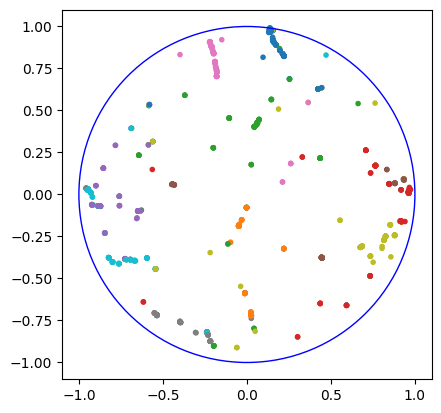

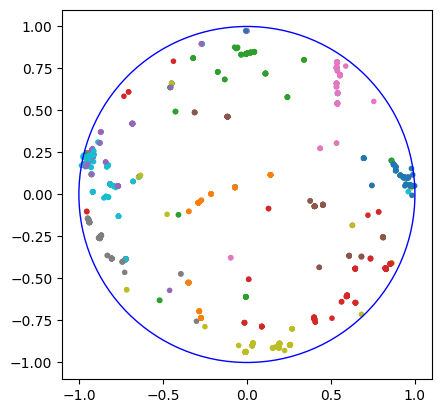

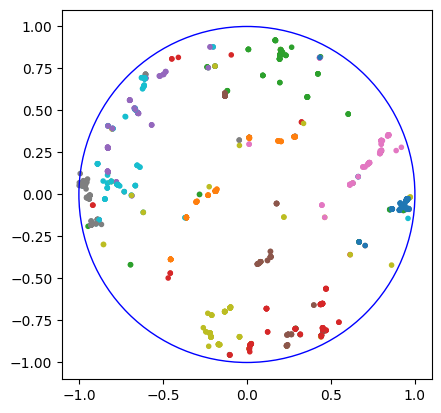

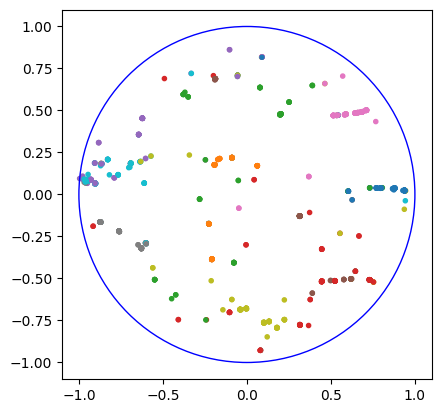

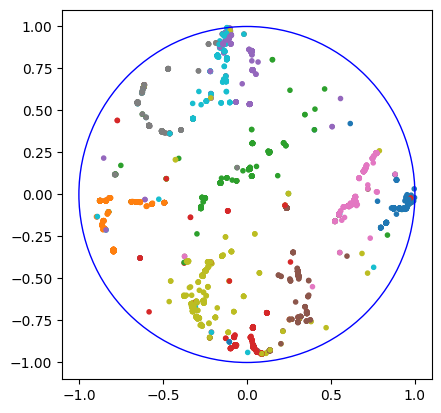

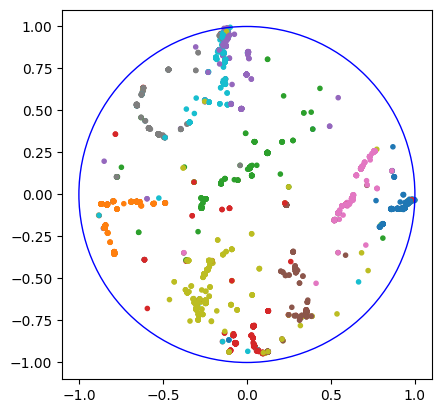

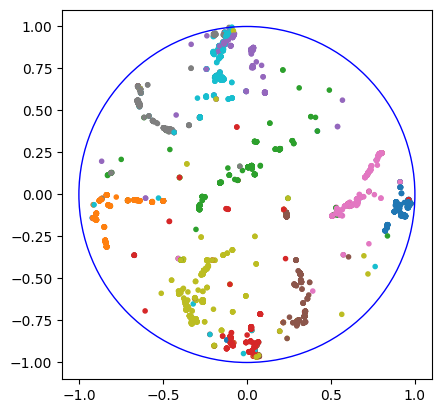

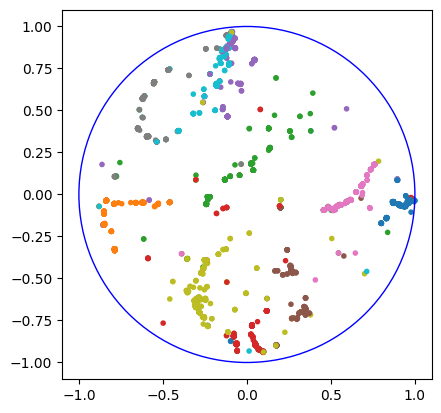

In [11]:
point_counts = [1000, 4000]#, 10000, 40000]
#u_grid_ns = [24]

exact_cpu_precisions = []
exact_cpu_recalls = []
exact_cpu_runtimes = []

exact_gpu_precisions = []
exact_gpu_recalls = []
exact_gpu_runtimes = []

ugrid_gpu_precisions = []
ugrid_gpu_recalls = []
ugrid_gpu_runtimes = []

qtree_cpu_precisions = []
qtree_cpu_recalls = []
qtree_cpu_runtimes = []

for num_points in point_counts:
    if (num_points <= 4000):
        p, r, t = run(num_points, True, False, 0) # Running exact CPU
        exact_cpu_precisions.append(p)
        exact_cpu_recalls.append(r)
        exact_cpu_runtimes.append(r)

    p, r, t = run(num_points, True, True, 0) # Running exact GPU
    exact_gpu_precisions.append(p)
    exact_gpu_recalls.append(r)
    exact_gpu_runtimes.append(r)

    p, r, t = run(num_points, False, True, 100) # Running approx. using uniform grid
    ugrid_gpu_precisions.append(p)
    ugrid_gpu_recalls.append(r)
    ugrid_gpu_runtimes.append(r)

    p, r, t = run(num_points, False, False, 0) # Running approx. using quadtree
    qtree_cpu_precisions.append(p)
    qtree_cpu_recalls.append(r)
    qtree_cpu_runtimes.append(r)

#for u_grid_n in u_grid_ns:
#    p, r = run(1000, False, True, u_grid_n) # Running approx. using uniform grid
#    ugrid_gpu_precisions.append(p)
#    ugrid_gpu_recalls.append(r)

In [7]:
def plot_points(datas, labels, label, x_label, y_label, x_values=None):
    
    if x_values == None:
        for data in datas:
            x = range(1, len(data) + 1)  # x-axis values from 1 to n
            plt.plot(x, data, marker='o', linestyle='-')  # Plot points connected by a line
    else:
        for data in datas:
            plt.plot(x_values, data, marker='o', linestyle='-')  # Plot points connected by a line

    plt.legend(labels)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(label)
    plt.grid(True)
    plt.show()

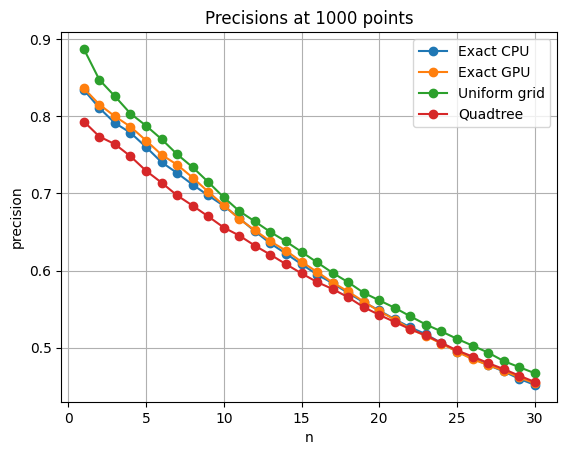

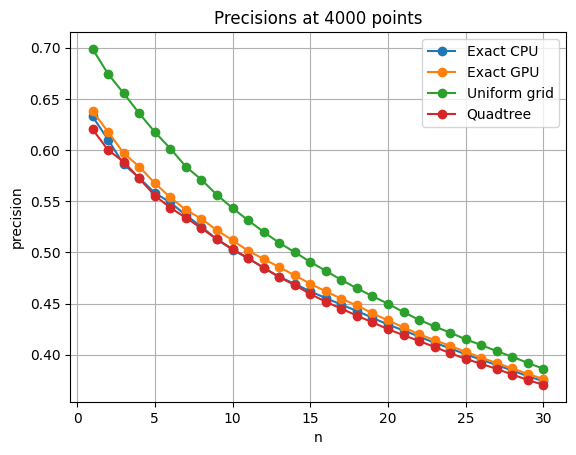

In [12]:
data = [exact_cpu_precisions[0], exact_gpu_precisions[0], ugrid_gpu_precisions[0], qtree_cpu_precisions[0]]
labels = ["Exact CPU", "Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[0]} points", "n", "precision")

data = [exact_cpu_precisions[1], exact_gpu_precisions[1], ugrid_gpu_precisions[1], qtree_cpu_precisions[1]]
labels = ["Exact CPU", "Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[1]} points", "n", "precision")

Exact CPU:
Precisions: [[0.82, 0.804, 0.7903333333333332, 0.7715, 0.7492000000000001, 0.7311666666666666, 0.7115714285714285, 0.698, 0.6802222222222222, 0.6687000000000001, 0.6545454545454545, 0.645, 0.6324615384615384, 0.619, 0.6075333333333333, 0.5949375, 0.5836470588235294, 0.5720555555555555, 0.5621052631578948, 0.5509000000000001, 0.540952380952381, 0.5315, 0.5210434782608695, 0.51075, 0.50112, 0.4918461538461538, 0.4840740740740741, 0.47617857142857145, 0.46551724137931033, 0.4570333333333333], [0.655, 0.627, 0.6040833333333333, 0.588625, 0.574, 0.561, 0.5492142857142857, 0.53675, 0.5259166666666666, 0.514575, 0.5047272727272727, 0.49575, 0.4864230769230769, 0.4781071428571429, 0.46953333333333336, 0.46190625, 0.4543088235294117, 0.44711111111111107, 0.44011842105263155, 0.4338, 0.42740476190476195, 0.42109090909090907, 0.4152282608695652, 0.4094895833333333, 0.4035300000000001, 0.3975480769230769, 0.3924259259259259, 0.38717857142857137, 0.3821379310344828, 0.37710000000000005]]

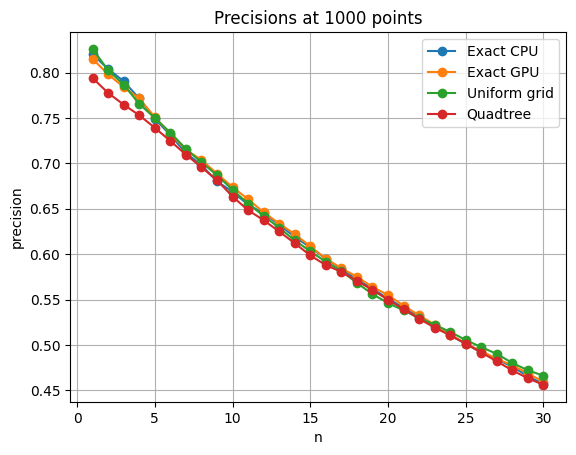

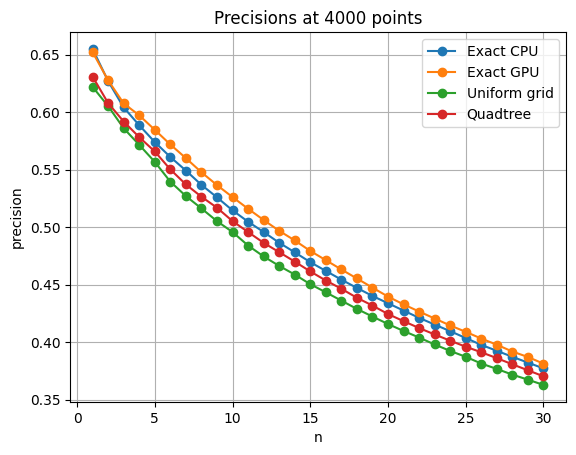

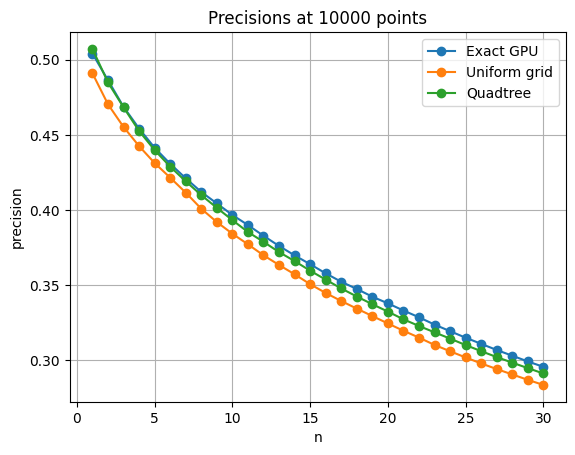

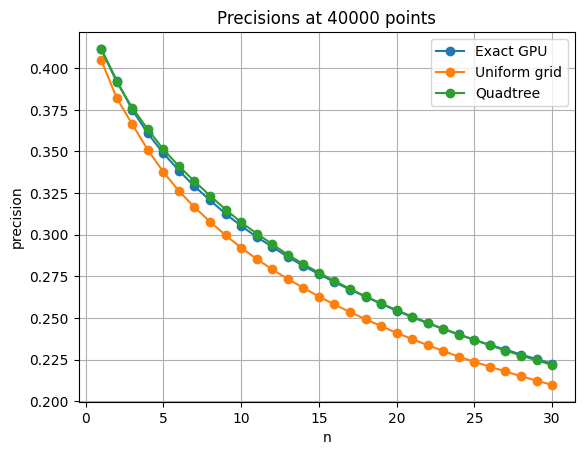

In [7]:
print("Exact CPU:")
print(f"Precisions: {exact_cpu_precisions}")
print(f"Recalls: {exact_cpu_recalls}")

print("Exact GPU:")
print(f"Precisions: {exact_gpu_precisions}")
print(f"Recalls: {exact_gpu_recalls}")

print("Uniform grid:")
print(f"Precisions: {ugrid_gpu_precisions}")
print(f"Recalls: {ugrid_gpu_recalls}")

print("Quadtree:")
print(f"Precisions: {qtree_cpu_precisions}")
print(f"Recalls: {qtree_cpu_recalls}")

data = [exact_cpu_precisions[0], exact_gpu_precisions[0], ugrid_gpu_precisions[0], qtree_cpu_precisions[0]]
labels = ["Exact CPU", "Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[0]} points", "n", "precision")

data = [exact_cpu_precisions[1], exact_gpu_precisions[1], ugrid_gpu_precisions[1], qtree_cpu_precisions[1]]
labels = ["Exact CPU", "Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[1]} points", "n", "precision")

data = [exact_gpu_precisions[2], ugrid_gpu_precisions[2], qtree_cpu_precisions[2]]
labels = ["Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[2]} points", "n", "precision")

data = [exact_gpu_precisions[3], ugrid_gpu_precisions[3], qtree_cpu_precisions[3]]
labels = ["Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[3]} points", "n", "precision")

Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.17200 grad_norm: 5.08648e-01: 100%|██████████| 250/250 [00:50<00:00,  4.96it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.63516 grad_norm: 7.82170e-01:  20%|█▉        | 149/750 [00:29<02:00,  4.98it/s]


4
[UGrid, n=20000, grid_n=5] Execution time: 80.41536474227905 seconds
Precision: [0.16645, 0.158225, 0.15256666666666666, 0.148325, 0.14449, 0.14154999999999998, 0.1385642857142857, 0.136275, 0.13426666666666667, 0.132195, 0.13022272727272724, 0.12877916666666667, 0.12718076923076926, 0.12571785714285713, 0.12450666666666665, 0.1229, 0.1216, 0.12029166666666667, 0.11914210526315787, 0.11821500000000001, 0.11723333333333333, 0.11629545454545452, 0.11537173913043478, 0.11445625, 0.11353600000000001, 0.11264807692307693, 0.11189074074074072, 0.1111482142857143, 0.11031896551724137, 0.10952], recall: [0.005548333333333334, 0.010548333333333333, 0.015256666666666667, 0.019776666666666665, 0.024081666666666668, 0.028310000000000002, 0.03233166666666666, 0.03634, 0.040279999999999996, 0.044065, 0.04774833333333334, 0.05151166666666667, 0.05511166666666667, 0.05866833333333333, 0.06225333333333333, 0.06554666666666667, 0.06890666666666666, 0.072175, 0.07545666666666666, 0.07881, 0.08206333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.17439 grad_norm: 5.08782e-01: 100%|██████████| 250/250 [00:51<00:00,  4.89it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.52564 grad_norm: 3.09394e-01:  21%|██        | 159/750 [00:32<01:59,  4.96it/s]


4
[UGrid, n=20000, grid_n=5] Execution time: 83.25581502914429 seconds
Precision: [0.15185, 0.141275, 0.13481666666666667, 0.129925, 0.12595000000000003, 0.122175, 0.11944285714285711, 0.116925, 0.11444444444444446, 0.112445, 0.11052727272727272, 0.10885416666666665, 0.10738076923076924, 0.10603214285714284, 0.10465666666666666, 0.103321875, 0.10215588235294118, 0.1009388888888889, 0.09989473684210526, 0.09899250000000002, 0.0980595238095238, 0.09707954545454545, 0.09623260869565216, 0.0956375, 0.09484400000000001, 0.0941173076923077, 0.09347222222222222, 0.09280357142857142, 0.09216551724137931, 0.09158166666666669], recall: [0.005061666666666667, 0.009418333333333334, 0.013481666666666666, 0.017323333333333333, 0.02099166666666667, 0.024435, 0.02787, 0.031179999999999996, 0.034333333333333334, 0.03748166666666666, 0.04052666666666666, 0.043541666666666666, 0.046531666666666666, 0.04948166666666666, 0.05232833333333333, 0.055104999999999994, 0.05788833333333333, 0.06056333333333333, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.18283 grad_norm: 5.08414e-01: 100%|██████████| 250/250 [00:50<00:00,  4.93it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.66171 grad_norm: 2.11728e-01:  20%|█▉        | 149/750 [00:30<02:01,  4.94it/s]


4
[UGrid, n=20000, grid_n=5] Execution time: 80.92654418945312 seconds
Precision: [0.16125, 0.153425, 0.14646666666666666, 0.141125, 0.13641999999999999, 0.134225, 0.13160714285714284, 0.12934375, 0.12727222222222223, 0.12519, 0.1229590909090909, 0.12094583333333332, 0.11927307692307691, 0.11775, 0.11639333333333333, 0.115059375, 0.11396176470588236, 0.11279444444444446, 0.11161052631578945, 0.110725, 0.10985, 0.10873863636363636, 0.10772608695652172, 0.10714375, 0.106208, 0.1053, 0.10459259259259258, 0.1038375, 0.10309310344827587, 0.10241166666666668], recall: [0.005375, 0.010228333333333332, 0.014646666666666667, 0.018816666666666666, 0.022736666666666665, 0.026844999999999997, 0.03070833333333333, 0.034491666666666664, 0.03818166666666667, 0.041729999999999996, 0.04508499999999999, 0.04837833333333333, 0.05168499999999999, 0.05495, 0.05819666666666667, 0.06136499999999999, 0.06457833333333333, 0.06767666666666666, 0.07068666666666666, 0.07381666666666667, 0.076895, 0.07974166666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.17817 grad_norm: 5.07613e-01: 100%|██████████| 250/250 [00:51<00:00,  4.88it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.60516 grad_norm: 7.80605e+00:  23%|██▎       | 169/750 [00:34<01:57,  4.95it/s]


4
[UGrid, n=20000, grid_n=5] Execution time: 85.39477944374084 seconds
Precision: [0.14185, 0.1345, 0.12874999999999998, 0.12515, 0.12191000000000002, 0.11887499999999998, 0.11609999999999998, 0.1143, 0.11241111111111111, 0.11113000000000002, 0.1099090909090909, 0.10867083333333333, 0.10723076923076924, 0.10605714285714285, 0.10524333333333334, 0.10435, 0.10365294117647059, 0.10274444444444446, 0.10181842105263157, 0.10087250000000002, 0.10014761904761905, 0.0995181818181818, 0.09892608695652172, 0.09830000000000001, 0.09759400000000001, 0.09689230769230771, 0.09627037037037035, 0.0956875, 0.09500689655172415, 0.09441166666666667], recall: [0.0047283333333333335, 0.008966666666666666, 0.012875, 0.01668666666666667, 0.020318333333333334, 0.023775, 0.027089999999999996, 0.030479999999999997, 0.033723333333333334, 0.03704333333333333, 0.0403, 0.04346833333333333, 0.04646666666666667, 0.04949333333333333, 0.05262166666666667, 0.05565333333333333, 0.058736666666666666, 0.06164666666666667, 

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.18183 grad_norm: 5.08301e-01: 100%|██████████| 250/250 [00:50<00:00,  4.93it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.50574 grad_norm: 8.67481e-01:  24%|██▍       | 179/750 [00:35<01:54,  4.98it/s]


4
[UGrid, n=20000, grid_n=5] Execution time: 86.63348484039307 seconds
Precision: [0.1522, 0.145925, 0.14126666666666665, 0.1370375, 0.1335, 0.13005, 0.12737142857142855, 0.12574375, 0.12395, 0.12183500000000001, 0.11989090909090908, 0.11855416666666665, 0.11694230769230769, 0.11557857142857142, 0.11428333333333332, 0.113075, 0.11185882352941176, 0.11083611111111114, 0.10992894736842104, 0.108975, 0.10808809523809523, 0.1069681818181818, 0.1061, 0.1052875, 0.10446200000000001, 0.10359807692307693, 0.10297037037037036, 0.10234642857142857, 0.10170344827586207, 0.10107833333333333], recall: [0.005073333333333333, 0.009728333333333334, 0.014126666666666668, 0.018271666666666665, 0.02225, 0.026010000000000002, 0.02972, 0.03353166666666667, 0.037184999999999996, 0.040611666666666664, 0.04396, 0.04742166666666666, 0.050675, 0.05393666666666667, 0.05714166666666666, 0.06030666666666666, 0.06338666666666666, 0.06650166666666667, 0.06962166666666667, 0.07265, 0.07566166666666667, 0.078443333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21980 grad_norm: 5.10296e-01: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.66178 grad_norm: 1.75760e-01:  23%|██▎       | 169/750 [00:36<02:04,  4.66it/s]


4
[UGrid, n=20000, grid_n=10] Execution time: 90.20245695114136 seconds
Precision: [0.24445, 0.232075, 0.22461666666666666, 0.217425, 0.21202, 0.2069083333333333, 0.20197142857142852, 0.1986375, 0.19536111111111112, 0.191675, 0.18863181818181815, 0.18580833333333335, 0.18309230769230772, 0.18055714285714283, 0.17804333333333333, 0.17583125, 0.17357941176470584, 0.1714333333333333, 0.16991052631578946, 0.167965, 0.16608095238095238, 0.1643, 0.1627195652173913, 0.16109791666666665, 0.159548, 0.1581, 0.15660925925925925, 0.15516785714285714, 0.15371034482758622, 0.1523566666666667], recall: [0.008148333333333332, 0.015471666666666667, 0.022461666666666668, 0.02899, 0.03533666666666667, 0.041381666666666664, 0.047126666666666664, 0.05297, 0.058608333333333325, 0.06389166666666668, 0.069165, 0.07432333333333334, 0.07934000000000001, 0.08426, 0.08902166666666667, 0.09377666666666667, 0.09836166666666667, 0.10286000000000001, 0.10761000000000001, 0.11197666666666667, 0.11625666666666669, 0.12

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.20836 grad_norm: 5.10925e-01: 100%|██████████| 250/250 [00:53<00:00,  4.65it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.58062 grad_norm: 6.25021e-01:  25%|██▌       | 189/750 [00:40<02:00,  4.65it/s]


4
[UGrid, n=20000, grid_n=10] Execution time: 94.41138911247253 seconds
Precision: [0.26885, 0.25625, 0.2461666666666667, 0.2376, 0.23089000000000007, 0.2246, 0.2197142857142857, 0.2150875, 0.2117166666666667, 0.20756999999999998, 0.20414545454545452, 0.20098333333333335, 0.19766538461538463, 0.19488571428571427, 0.19201000000000004, 0.1892125, 0.1864941176470588, 0.18407777777777778, 0.18195, 0.17975000000000002, 0.17766904761904762, 0.17559772727272724, 0.17355434782608695, 0.17169791666666667, 0.17009000000000002, 0.16837115384615386, 0.16697037037037038, 0.1653214285714286, 0.16392241379310343, 0.16255666666666668], recall: [0.008961666666666668, 0.017083333333333336, 0.02461666666666666, 0.03167999999999999, 0.038481666666666664, 0.044919999999999995, 0.05126666666666666, 0.05735666666666666, 0.06351499999999999, 0.06919000000000002, 0.07485333333333333, 0.08039333333333334, 0.08565500000000001, 0.09094666666666666, 0.09600500000000002, 0.10091333333333334, 0.10568000000000002, 0.

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.20956 grad_norm: 5.10712e-01: 100%|██████████| 250/250 [00:53<00:00,  4.69it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.53252 grad_norm: 9.58756e-01:  27%|██▋       | 199/750 [00:42<01:57,  4.68it/s]


4
[UGrid, n=20000, grid_n=10] Execution time: 95.85507035255432 seconds
Precision: [0.24165, 0.231225, 0.2232, 0.2160875, 0.21001000000000003, 0.205275, 0.20045, 0.196225, 0.19259444444444443, 0.18933000000000003, 0.18644545454545453, 0.1839, 0.1810576923076923, 0.17882857142857142, 0.17646333333333333, 0.174453125, 0.17215588235294116, 0.1701277777777778, 0.16839736842105263, 0.16660750000000002, 0.16479047619047618, 0.16306136363636362, 0.16149999999999998, 0.15996249999999998, 0.15856800000000004, 0.1570673076923077, 0.15567037037037038, 0.1543089285714286, 0.15300172413793103, 0.15165833333333334], recall: [0.008055000000000001, 0.015415, 0.022320000000000003, 0.028811666666666666, 0.03500166666666667, 0.041054999999999994, 0.04677166666666666, 0.05232666666666667, 0.05777833333333333, 0.06310999999999999, 0.06836333333333333, 0.07355999999999999, 0.07845833333333334, 0.08345333333333332, 0.08823166666666667, 0.09304166666666666, 0.09755499999999999, 0.10207666666666668, 0.10665166

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21300 grad_norm: 5.10116e-01: 100%|██████████| 250/250 [00:52<00:00,  4.72it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.62219 grad_norm: 1.65584e-01:  25%|██▌       | 189/750 [00:40<01:59,  4.71it/s]


4
[UGrid, n=20000, grid_n=10] Execution time: 93.09550094604492 seconds
Precision: [0.25615, 0.24435, 0.23216666666666666, 0.2237, 0.21613000000000002, 0.21024166666666666, 0.20512142857142854, 0.20056875, 0.1962611111111111, 0.192005, 0.1882772727272727, 0.18514166666666668, 0.18240384615384617, 0.17951071428571427, 0.1768066666666667, 0.1742875, 0.1721029411764706, 0.16998055555555558, 0.1679736842105263, 0.16596, 0.16424523809523808, 0.16235681818181816, 0.16058478260869566, 0.15894583333333331, 0.157364, 0.15595, 0.15451851851851853, 0.152975, 0.15157586206896548, 0.1502666666666667], recall: [0.008538333333333334, 0.01629, 0.02321666666666667, 0.029826666666666665, 0.03602166666666666, 0.042048333333333326, 0.047861666666666663, 0.053485000000000005, 0.05887833333333333, 0.06400166666666667, 0.06903499999999999, 0.07405666666666666, 0.07904166666666668, 0.08377166666666667, 0.08840333333333335, 0.09295333333333333, 0.097525, 0.10198833333333335, 0.10638333333333334, 0.11064, 0.114

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21370 grad_norm: 5.10357e-01: 100%|██████████| 250/250 [00:53<00:00,  4.67it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.60560 grad_norm: 8.01351e-01:  24%|██▍       | 179/750 [00:38<02:02,  4.67it/s]


4
[UGrid, n=20000, grid_n=10] Execution time: 91.87561106681824 seconds
Precision: [0.2453, 0.2357, 0.22725, 0.21975, 0.21324, 0.20781666666666665, 0.2033428571428571, 0.1995375, 0.19538888888888892, 0.192045, 0.18870454545454546, 0.1860166666666667, 0.1830384615384615, 0.18048214285714287, 0.17816666666666667, 0.1755625, 0.17322647058823526, 0.17125833333333335, 0.1691921052631579, 0.16745, 0.16546666666666665, 0.16360454545454542, 0.16184347826086956, 0.16013541666666667, 0.15848600000000002, 0.15699038461538461, 0.15553518518518517, 0.15413571428571426, 0.1527844827586207, 0.15139500000000003], recall: [0.008176666666666667, 0.015713333333333333, 0.022725000000000002, 0.0293, 0.035539999999999995, 0.041563333333333334, 0.04744666666666667, 0.05320999999999999, 0.058616666666666664, 0.064015, 0.06919166666666667, 0.07440666666666666, 0.07931666666666667, 0.084225, 0.08908333333333333, 0.09363333333333333, 0.09816166666666667, 0.102755, 0.10715500000000001, 0.11163333333333335, 0.1158

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22210 grad_norm: 5.11698e-01: 100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.58985 grad_norm: 5.80623e-01:  25%|██▌       | 189/750 [00:43<02:09,  4.32it/s]


4
[UGrid, n=20000, grid_n=15] Execution time: 101.19299793243408 seconds
Precision: [0.34535, 0.33255, 0.31966666666666665, 0.3083875, 0.29901000000000005, 0.29116666666666663, 0.28379999999999994, 0.277525, 0.27179444444444445, 0.265925, 0.2612181818181818, 0.25689166666666663, 0.25245384615384614, 0.24819285714285716, 0.24423666666666669, 0.2404375, 0.23672352941176472, 0.23334166666666664, 0.23005, 0.2271, 0.22416666666666665, 0.22129999999999994, 0.21845, 0.21590833333333334, 0.21351800000000004, 0.21115, 0.20891296296296297, 0.20660714285714285, 0.20432413793103446, 0.20202666666666666], recall: [0.011511666666666667, 0.02217, 0.031966666666666664, 0.04111833333333333, 0.049835, 0.058233333333333324, 0.06621999999999999, 0.07400666666666668, 0.08153833333333334, 0.08864166666666666, 0.09577999999999999, 0.10275666666666666, 0.10939666666666667, 0.11582333333333336, 0.12211833333333334, 0.12823333333333334, 0.13414333333333334, 0.14000500000000002, 0.14569833333333335, 0.1514, 0.15

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22539 grad_norm: 5.11961e-01: 100%|██████████| 250/250 [00:56<00:00,  4.41it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.60879 grad_norm: 1.02386e+00:  25%|██▌       | 189/750 [00:43<02:10,  4.30it/s]


4
[UGrid, n=20000, grid_n=15] Execution time: 100.74621725082397 seconds
Precision: [0.3129, 0.2983, 0.28683333333333333, 0.278775, 0.27072, 0.26413333333333333, 0.2566428571428571, 0.25074375, 0.24568333333333334, 0.24111000000000005, 0.2365681818181818, 0.23277083333333334, 0.2290846153846154, 0.22541071428571433, 0.22247333333333336, 0.219278125, 0.21617941176470584, 0.21321111111111107, 0.21058157894736843, 0.2080775, 0.20551428571428568, 0.20332499999999998, 0.20125217391304348, 0.19913958333333331, 0.197046, 0.19488846153846157, 0.1930055555555555, 0.19098928571428572, 0.18914999999999998, 0.18729500000000002], recall: [0.01043, 0.019886666666666667, 0.02868333333333333, 0.037169999999999995, 0.04512, 0.05282666666666667, 0.05988333333333332, 0.06686500000000001, 0.07370499999999999, 0.08037000000000001, 0.08674166666666668, 0.09310833333333333, 0.09927000000000001, 0.10519166666666667, 0.11123666666666668, 0.11694833333333333, 0.12250166666666669, 0.12792666666666666, 0.13336833

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21849 grad_norm: 5.11448e-01: 100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.54208 grad_norm: 1.25695e+04:  28%|██▊       | 209/750 [00:48<02:05,  4.31it/s]


4
[UGrid, n=20000, grid_n=15] Execution time: 102.88977432250977 seconds
Precision: [0.3385, 0.319125, 0.30626666666666663, 0.296525, 0.2875400000000001, 0.27893333333333337, 0.27259285714285714, 0.26719375, 0.2618888888888889, 0.25715, 0.25214999999999993, 0.2480875, 0.24348076923076925, 0.23923928571428568, 0.23551333333333332, 0.232046875, 0.22855, 0.2253527777777778, 0.22238157894736843, 0.21944500000000003, 0.21667619047619047, 0.21386363636363634, 0.2112108695652174, 0.20878958333333336, 0.206488, 0.2042096153846154, 0.20208333333333334, 0.19989464285714284, 0.1977965517241379, 0.19573500000000002], recall: [0.011283333333333331, 0.021275, 0.03062666666666666, 0.039536666666666664, 0.04792333333333333, 0.05578666666666666, 0.063605, 0.07125166666666667, 0.07856666666666667, 0.08571666666666668, 0.09245500000000002, 0.09923499999999999, 0.10550833333333334, 0.11164500000000001, 0.11775666666666666, 0.12375833333333335, 0.1295116666666667, 0.13521166666666667, 0.14084166666666667, 

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21641 grad_norm: 5.11247e-01: 100%|██████████| 250/250 [00:56<00:00,  4.39it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.64404 grad_norm: 1.78607e-01:  24%|██▍       | 179/750 [00:41<02:11,  4.34it/s]


4
[UGrid, n=20000, grid_n=15] Execution time: 98.17484498023987 seconds
Precision: [0.32495, 0.3058, 0.2941666666666667, 0.2829875, 0.27432, 0.2672, 0.26107857142857144, 0.25475625, 0.24932222222222222, 0.244275, 0.23933181818181815, 0.23482916666666664, 0.23116923076923077, 0.22739285714285715, 0.22423, 0.22105625, 0.21793529411764703, 0.21499166666666666, 0.21219736842105263, 0.2093675, 0.20668333333333336, 0.20440681818181813, 0.20208478260869564, 0.19975, 0.19744000000000003, 0.19556346153846152, 0.19335925925925926, 0.19131607142857143, 0.18940172413793105, 0.18764], recall: [0.010831666666666667, 0.020386666666666664, 0.029416666666666664, 0.03773166666666666, 0.04572, 0.05343999999999999, 0.06091833333333333, 0.067935, 0.07479666666666666, 0.081425, 0.08775500000000001, 0.09393166666666668, 0.10017333333333334, 0.10611666666666668, 0.112115, 0.11789666666666666, 0.1234966666666667, 0.12899500000000003, 0.13439166666666666, 0.13957833333333333, 0.14467833333333333, 0.149898333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21627 grad_norm: 5.11478e-01: 100%|██████████| 250/250 [00:56<00:00,  4.40it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.63690 grad_norm: 4.76962e-01:  24%|██▍       | 179/750 [00:40<02:09,  4.40it/s]


4
[UGrid, n=20000, grid_n=15] Execution time: 97.48545098304749 seconds
Precision: [0.3072, 0.296725, 0.28414999999999996, 0.2743875, 0.26608000000000004, 0.25865000000000005, 0.25205, 0.24625625, 0.24153888888888886, 0.236975, 0.23293181818181816, 0.22926666666666665, 0.22569230769230772, 0.22262142857142858, 0.21916999999999998, 0.216021875, 0.21315882352941176, 0.21033055555555558, 0.20785789473684207, 0.2051875, 0.20265, 0.20047499999999996, 0.19833695652173913, 0.19627708333333335, 0.19428800000000002, 0.19235384615384615, 0.19032222222222223, 0.18857678571428568, 0.18683793103448273, 0.18516333333333332], recall: [0.01024, 0.019781666666666666, 0.028415, 0.036585, 0.04434666666666667, 0.05173, 0.05881166666666666, 0.06566833333333333, 0.07246166666666667, 0.07899166666666667, 0.08540833333333335, 0.09170666666666669, 0.09780000000000001, 0.10389000000000001, 0.10958499999999999, 0.11521166666666668, 0.12078999999999998, 0.12619833333333333, 0.13164333333333333, 0.1367916666666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22226 grad_norm: 5.12655e-01: 100%|██████████| 250/250 [00:56<00:00,  4.44it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.42471 grad_norm: 6.27605e-01:  32%|███▏      | 239/750 [00:57<02:02,  4.16it/s]


4
[UGrid, n=20000, grid_n=20] Execution time: 113.77580738067627 seconds
Precision: [0.35705, 0.340475, 0.3277166666666667, 0.316, 0.30784, 0.29905, 0.29141428571428574, 0.284375, 0.2784722222222222, 0.27288999999999997, 0.26734545454545455, 0.2619875, 0.2573769230769231, 0.2533071428571429, 0.24898, 0.245028125, 0.24161176470588233, 0.23844444444444443, 0.23541842105263158, 0.23221, 0.22919523809523806, 0.2263863636363636, 0.2238913043478261, 0.2211770833333333, 0.21842200000000003, 0.21611923076923076, 0.21378888888888886, 0.21156607142857142, 0.20938965517241376, 0.20720666666666665], recall: [0.011901666666666666, 0.022698333333333334, 0.032771666666666664, 0.04213333333333333, 0.05130666666666666, 0.05981, 0.06799666666666666, 0.07583333333333334, 0.08354166666666668, 0.09096333333333334, 0.09802666666666666, 0.104795, 0.11153000000000002, 0.11821000000000001, 0.12449, 0.1306816666666667, 0.13691333333333336, 0.14306666666666665, 0.14909833333333333, 0.1548066666666667, 0.16043666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21620 grad_norm: 5.13049e-01: 100%|██████████| 250/250 [00:59<00:00,  4.23it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.47935 grad_norm: 2.29411e-01:  31%|███       | 229/750 [00:54<02:02,  4.24it/s]


4
[UGrid, n=20000, grid_n=20] Execution time: 113.15878391265869 seconds
Precision: [0.3623, 0.3502, 0.3371333333333333, 0.3245125, 0.3146900000000001, 0.3058666666666667, 0.2977785714285714, 0.29104375, 0.2846, 0.27878, 0.2732863636363636, 0.2685125, 0.26314615384615386, 0.25835, 0.2546166666666667, 0.250725, 0.24697352941176468, 0.24323055555555553, 0.23989210526315788, 0.2367475, 0.23367619047619045, 0.23076818181818176, 0.2278891304347826, 0.22490833333333335, 0.222298, 0.21960576923076924, 0.21708333333333335, 0.21444464285714285, 0.21194655172413795, 0.20962666666666668], recall: [0.012076666666666664, 0.023346666666666665, 0.03371333333333333, 0.04326833333333333, 0.05244833333333333, 0.061173333333333337, 0.06948166666666666, 0.07761166666666668, 0.08538000000000001, 0.09292666666666667, 0.10020499999999999, 0.107405, 0.11403000000000002, 0.12056333333333334, 0.12730833333333336, 0.13372000000000003, 0.1399516666666667, 0.14593833333333334, 0.15193166666666666, 0.15783166666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21961 grad_norm: 5.11946e-01: 100%|██████████| 250/250 [00:52<00:00,  4.77it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.47405 grad_norm: 1.72966e+00:  31%|███       | 229/750 [00:48<01:51,  4.69it/s]


4
[UGrid, n=20000, grid_n=20] Execution time: 101.29899454116821 seconds
Precision: [0.35345, 0.339125, 0.32606666666666667, 0.313025, 0.3033, 0.29496666666666665, 0.28674285714285713, 0.279275, 0.2733277777777778, 0.26746, 0.26201363636363634, 0.2568958333333333, 0.25240384615384615, 0.24837857142857142, 0.2437766666666667, 0.24013125, 0.23688823529411762, 0.23332777777777777, 0.23021052631578945, 0.227175, 0.22426904761904762, 0.22149772727272726, 0.2187304347826087, 0.21606875, 0.213652, 0.2111115384615385, 0.20882407407407405, 0.2066142857142857, 0.20442586206896554, 0.20251166666666667], recall: [0.011781666666666666, 0.02260833333333333, 0.032606666666666666, 0.041736666666666665, 0.05055, 0.05899333333333333, 0.06690666666666666, 0.07447333333333334, 0.08199833333333334, 0.08915333333333333, 0.09607166666666667, 0.10275833333333333, 0.109375, 0.11591000000000001, 0.12188833333333335, 0.12807000000000002, 0.13423666666666667, 0.13999666666666666, 0.1458, 0.15145, 0.15698833333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21439 grad_norm: 5.13201e-01: 100%|██████████| 250/250 [00:54<00:00,  4.63it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.39697 grad_norm: 6.99303e-01:  33%|███▎      | 249/750 [00:57<01:55,  4.33it/s]


4
[UGrid, n=20000, grid_n=20] Execution time: 111.52890062332153 seconds
Precision: [0.34195, 0.328525, 0.3168, 0.3065, 0.29795, 0.2910583333333334, 0.2832428571428571, 0.27668125, 0.2707944444444445, 0.26518500000000006, 0.25970909090909083, 0.255325, 0.2509807692307692, 0.24634285714285717, 0.24240666666666671, 0.2386375, 0.23515294117647054, 0.2320722222222222, 0.22880789473684207, 0.22564, 0.22266190476190478, 0.2200090909090909, 0.2173760869565217, 0.2150166666666667, 0.21266600000000002, 0.21025961538461543, 0.2077537037037037, 0.20570714285714284, 0.2036137931034483, 0.20161666666666667], recall: [0.011398333333333331, 0.021901666666666667, 0.03168, 0.04086666666666666, 0.04965833333333333, 0.058211666666666655, 0.06609, 0.07378166666666668, 0.08123833333333333, 0.088395, 0.09522666666666667, 0.10213000000000001, 0.10875833333333335, 0.11496000000000002, 0.12120333333333336, 0.12727333333333335, 0.13325333333333333, 0.13924333333333333, 0.1449116666666667, 0.15042666666666668, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21764 grad_norm: 5.12057e-01: 100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.34960 grad_norm: 2.40511e-01:  36%|███▌      | 269/750 [01:04<01:55,  4.17it/s]


4
[UGrid, n=20000, grid_n=20] Execution time: 123.38833832740784 seconds
Precision: [0.35265, 0.3352, 0.3205333333333333, 0.3106, 0.30099000000000004, 0.2935166666666667, 0.2862071428571428, 0.27873125, 0.27213333333333334, 0.26667, 0.2616954545454545, 0.25705833333333333, 0.2522846153846154, 0.247975, 0.24406, 0.240446875, 0.23663529411764703, 0.23319444444444443, 0.23026315789473684, 0.2271975, 0.22425238095238093, 0.2214954545454545, 0.2188173913043478, 0.21618333333333334, 0.21357000000000004, 0.21099807692307695, 0.20866666666666664, 0.20639464285714285, 0.20420172413793103, 0.20188166666666665], recall: [0.011754999999999998, 0.022346666666666667, 0.03205333333333333, 0.04141333333333333, 0.050164999999999994, 0.05870333333333333, 0.06678166666666666, 0.07432833333333333, 0.08164, 0.08889000000000001, 0.09595500000000001, 0.10282333333333336, 0.10932333333333333, 0.11572166666666667, 0.12203, 0.12823833333333334, 0.13409333333333334, 0.1399166666666667, 0.14583333333333334, 0.151

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21674 grad_norm: 5.12896e-01: 100%|██████████| 250/250 [00:52<00:00,  4.81it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.43752 grad_norm: 3.32548e-01:  32%|███▏      | 239/750 [00:54<01:56,  4.37it/s]


4
[UGrid, n=20000, grid_n=25] Execution time: 106.7331018447876 seconds
Precision: [0.3645, 0.34635, 0.3325333333333333, 0.3225375, 0.31253000000000003, 0.305125, 0.29742857142857143, 0.2899125, 0.2836777777777778, 0.27767000000000003, 0.2718954545454545, 0.26694166666666663, 0.2619692307692308, 0.25772142857142855, 0.2533233333333333, 0.24926875, 0.24571470588235292, 0.24233888888888888, 0.23896052631578946, 0.2360125, 0.23315, 0.2303431818181818, 0.22754565217391304, 0.22446458333333336, 0.221838, 0.21935769230769234, 0.21687962962962962, 0.214525, 0.21226724137931033, 0.2101233333333333], recall: [0.01215, 0.02309, 0.03325333333333333, 0.043005, 0.05208833333333332, 0.061025, 0.0694, 0.07730999999999999, 0.08510333333333334, 0.09255666666666668, 0.099695, 0.10677666666666669, 0.11352000000000001, 0.12027, 0.12666166666666664, 0.13294333333333333, 0.13923833333333335, 0.14540333333333333, 0.15134166666666668, 0.15734166666666669, 0.16320500000000002, 0.16891833333333334, 0.1744516666

c:\Git\hyperbolic-tsne\hyperbolicTSNE\visualization.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22369 grad_norm: 5.13754e-01: 100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.34340 grad_norm: 5.49815e-01:  36%|███▌      | 269/750 [01:04<01:55,  4.17it/s]


4
[UGrid, n=20000, grid_n=25] Execution time: 119.26351475715637 seconds
Precision: [0.37445, 0.3556, 0.34509999999999996, 0.3323, 0.32216000000000006, 0.31395, 0.30597142857142856, 0.2992625, 0.2921888888888889, 0.28637500000000005, 0.2807636363636363, 0.27592916666666667, 0.2708230769230769, 0.26630714285714285, 0.26163000000000003, 0.257440625, 0.25378235294117646, 0.24998333333333334, 0.24648421052631575, 0.24317249999999999, 0.23997857142857143, 0.23687727272727271, 0.23402826086956524, 0.23119791666666664, 0.228304, 0.22572115384615385, 0.2230907407407407, 0.2204803571428571, 0.2181603448275862, 0.21575833333333336], recall: [0.012481666666666667, 0.023706666666666664, 0.03451, 0.04430666666666666, 0.05369333333333333, 0.06279, 0.07139333333333332, 0.07980333333333334, 0.08765666666666667, 0.09545833333333335, 0.10294666666666667, 0.11037166666666667, 0.11735666666666668, 0.12427666666666669, 0.13081500000000001, 0.13730166666666668, 0.14381, 0.14999, 0.15610666666666667, 0.16211

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21744 grad_norm: 5.13002e-01: 100%|██████████| 250/250 [00:51<00:00,  4.84it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.51816 grad_norm: 5.23731e-01:  29%|██▉       | 219/750 [00:46<01:51,  4.75it/s]


4
[UGrid, n=20000, grid_n=25] Execution time: 97.682546377182 seconds
Precision: [0.3807, 0.3605, 0.3482833333333333, 0.3357125, 0.32405000000000006, 0.3143666666666666, 0.3059928571428571, 0.2984625, 0.2920833333333333, 0.28561500000000006, 0.2798818181818182, 0.27405833333333335, 0.26878076923076927, 0.2640607142857143, 0.2599, 0.2559375, 0.25194999999999995, 0.24820277777777774, 0.24449473684210524, 0.241285, 0.23807619047619047, 0.23506363636363636, 0.23221956521739134, 0.22937291666666665, 0.22691200000000003, 0.22415769230769228, 0.22163518518518519, 0.2192517857142857, 0.21688965517241382, 0.214565], recall: [0.012689999999999998, 0.02403333333333333, 0.034828333333333336, 0.044761666666666665, 0.054008333333333325, 0.06287333333333332, 0.07139833333333334, 0.07959, 0.087625, 0.09520500000000001, 0.10262333333333336, 0.10962333333333334, 0.11647166666666667, 0.12322833333333333, 0.12995, 0.1365, 0.14277166666666669, 0.14892166666666667, 0.15484666666666666, 0.16085666666666665, 

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21244 grad_norm: 5.13468e-01: 100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.44212 grad_norm: 9.43491e-01:  32%|███▏      | 239/750 [00:56<02:00,  4.26it/s]


4
[UGrid, n=20000, grid_n=25] Execution time: 110.37026166915894 seconds
Precision: [0.38245, 0.36645, 0.35416666666666663, 0.3412375, 0.33031000000000005, 0.32115, 0.31322142857142854, 0.305775, 0.2993722222222222, 0.29295499999999997, 0.28723636363636357, 0.2816083333333333, 0.27620769230769227, 0.27136785714285716, 0.26695666666666673, 0.262846875, 0.25846764705882347, 0.2543611111111111, 0.2509447368421053, 0.24756, 0.24421666666666667, 0.2412704545454545, 0.23825434782608695, 0.2354125, 0.23273000000000002, 0.22968269230769234, 0.2270462962962963, 0.22443392857142858, 0.22193793103448275, 0.21954], recall: [0.012748333333333332, 0.024429999999999997, 0.035416666666666666, 0.04549833333333332, 0.055051666666666665, 0.06423, 0.07308500000000001, 0.08154000000000002, 0.08981166666666668, 0.09765166666666666, 0.10532000000000001, 0.11264333333333335, 0.11969, 0.12663833333333332, 0.13347833333333337, 0.140185, 0.146465, 0.15261666666666668, 0.15893166666666667, 0.16504000000000002, 0.

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21356 grad_norm: 5.12712e-01: 100%|██████████| 250/250 [00:51<00:00,  4.81it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.42227 grad_norm: 5.59553e+01:  33%|███▎      | 249/750 [00:53<01:47,  4.65it/s]


4
[UGrid, n=20000, grid_n=25] Execution time: 105.51255989074707 seconds
Precision: [0.3786, 0.360675, 0.3463166666666667, 0.334825, 0.32385, 0.3148416666666667, 0.30612142857142854, 0.298625, 0.29184444444444446, 0.285525, 0.2795090909090909, 0.2743375, 0.2694538461538462, 0.2645321428571429, 0.2601333333333333, 0.2557375, 0.25183823529411764, 0.2482083333333333, 0.24465, 0.241285, 0.2379547619047619, 0.23489090909090907, 0.2318521739130435, 0.22895208333333336, 0.22626200000000005, 0.22365, 0.2212037037037037, 0.2187553571428571, 0.2165310344827586, 0.21409499999999998], recall: [0.01262, 0.024045, 0.03463166666666666, 0.04464333333333333, 0.053975, 0.06296833333333333, 0.07142833333333333, 0.07963333333333333, 0.08755333333333333, 0.095175, 0.10248666666666668, 0.10973500000000001, 0.11676333333333334, 0.12344833333333335, 0.13006666666666666, 0.13639333333333337, 0.14270833333333333, 0.148925, 0.15494499999999997, 0.16085666666666665, 0.16656833333333335, 0.17225333333333334, 0.177

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21933 grad_norm: 5.12252e-01: 100%|██████████| 250/250 [00:55<00:00,  4.48it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.50503 grad_norm: 1.22188e+04:  31%|███       | 229/750 [00:51<01:58,  4.41it/s]


4
[UGrid, n=20000, grid_n=30] Execution time: 107.79839134216309 seconds
Precision: [0.42065, 0.39565, 0.37806666666666666, 0.3636375, 0.35151000000000004, 0.34170833333333334, 0.33209285714285713, 0.32375, 0.3157222222222222, 0.308645, 0.3020045454545454, 0.29552083333333334, 0.28985000000000005, 0.2844357142857143, 0.2796166666666667, 0.274803125, 0.2705294117647059, 0.26619444444444446, 0.26189473684210524, 0.2581275, 0.2540928571428571, 0.25066363636363637, 0.24725434782608696, 0.24396041666666665, 0.24068, 0.23768653846153848, 0.23475, 0.2319, 0.22929827586206897, 0.22673833333333332], recall: [0.014021666666666667, 0.026376666666666666, 0.03780666666666667, 0.048485, 0.05858499999999999, 0.06834166666666666, 0.07748833333333333, 0.08633333333333333, 0.09471666666666667, 0.10288166666666666, 0.11073500000000001, 0.11820833333333335, 0.1256016666666667, 0.13273666666666667, 0.13980833333333334, 0.14656166666666667, 0.1533, 0.15971666666666667, 0.16586666666666666, 0.172085000000000

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21817 grad_norm: 5.12377e-01: 100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.34238 grad_norm: 4.39138e+03:  36%|███▌      | 269/750 [01:00<01:47,  4.47it/s]


4
[UGrid, n=20000, grid_n=30] Execution time: 115.34527325630188 seconds
Precision: [0.41635, 0.3973, 0.3829, 0.3688875, 0.35681, 0.3465833333333334, 0.33723571428571425, 0.32874375, 0.3202833333333333, 0.31289, 0.3059545454545454, 0.2999958333333333, 0.2944576923076923, 0.28863571428571433, 0.28365999999999997, 0.278975, 0.2742970588235294, 0.2698138888888889, 0.26541315789473685, 0.2611275, 0.25716904761904763, 0.2532772727272727, 0.2496630434782609, 0.24637916666666665, 0.24305800000000005, 0.24002115384615386, 0.23704444444444445, 0.23408392857142857, 0.23110862068965515, 0.22841833333333333], recall: [0.013878333333333333, 0.02648666666666667, 0.03829, 0.049185, 0.05946833333333334, 0.06931666666666667, 0.07868833333333332, 0.08766499999999999, 0.096085, 0.10429666666666668, 0.11218333333333333, 0.11999833333333333, 0.12759833333333334, 0.13469666666666666, 0.14182999999999998, 0.14878666666666668, 0.155435, 0.16188833333333336, 0.168095, 0.174085, 0.18001833333333334, 0.185736666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21841 grad_norm: 5.12439e-01: 100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.38719 grad_norm: 6.84697e-01:  33%|███▎      | 249/750 [00:57<01:55,  4.32it/s]


4
[UGrid, n=20000, grid_n=30] Execution time: 112.2168140411377 seconds
Precision: [0.4251, 0.405575, 0.38960000000000006, 0.3759625, 0.36383000000000004, 0.3533, 0.3434357142857143, 0.3344125, 0.32616111111111107, 0.31885, 0.3122454545454545, 0.3058833333333333, 0.2998423076923077, 0.29390714285714287, 0.28837666666666667, 0.28355625, 0.2789735294117647, 0.27418611111111113, 0.2702578947368421, 0.2660325, 0.26245000000000007, 0.25854772727272723, 0.2549413043478261, 0.2512520833333334, 0.24792000000000003, 0.2446346153846154, 0.24151481481481482, 0.23857678571428573, 0.2357810344827586, 0.23308833333333331], recall: [0.014169999999999999, 0.02703833333333333, 0.03896, 0.05012833333333332, 0.060638333333333336, 0.07066000000000001, 0.080135, 0.08917666666666667, 0.09784833333333334, 0.10628333333333335, 0.11449000000000001, 0.12235333333333333, 0.1299316666666667, 0.13715666666666665, 0.14418833333333334, 0.15123, 0.15808500000000003, 0.16451166666666667, 0.17116333333333336, 0.177355,

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22216 grad_norm: 5.13124e-01: 100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.29685 grad_norm: 7.50289e-01:  37%|███▋      | 279/750 [01:03<01:47,  4.37it/s]


4
[UGrid, n=20000, grid_n=30] Execution time: 121.3224835395813 seconds
Precision: [0.395, 0.3785, 0.36515, 0.35305, 0.34174, 0.33265, 0.32432142857142854, 0.316125, 0.3089666666666667, 0.302505, 0.2966772727272727, 0.2912625, 0.2864153846153846, 0.28168928571428575, 0.2773333333333334, 0.27315, 0.26897647058823526, 0.26473888888888886, 0.26094999999999996, 0.25733500000000004, 0.25388333333333335, 0.2506409090909091, 0.24751304347826086, 0.24461041666666666, 0.24171800000000002, 0.23878269230769233, 0.2361018518518518, 0.23365, 0.23100689655172413, 0.22851000000000005], recall: [0.013166666666666665, 0.02523333333333333, 0.036515, 0.047073333333333335, 0.05695666666666666, 0.06652999999999999, 0.075675, 0.0843, 0.09269000000000001, 0.10083500000000001, 0.10878166666666668, 0.11650500000000001, 0.12411333333333333, 0.131455, 0.1386666666666667, 0.14568000000000003, 0.15242, 0.15884333333333334, 0.16526833333333335, 0.17155666666666672, 0.17771833333333337, 0.18380333333333335, 0.189759

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21734 grad_norm: 5.11788e-01: 100%|██████████| 250/250 [00:55<00:00,  4.52it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.44378 grad_norm: 1.39781e+02:  32%|███▏      | 239/750 [00:52<01:53,  4.51it/s]


4
[UGrid, n=20000, grid_n=30] Execution time: 108.23618769645691 seconds
Precision: [0.3829, 0.36615, 0.35141666666666665, 0.33985, 0.33022, 0.3216583333333333, 0.3136428571428571, 0.30644375, 0.2994722222222222, 0.29308500000000004, 0.2876727272727272, 0.2823333333333333, 0.27751923076923074, 0.2728607142857143, 0.2680366666666667, 0.26390625, 0.2601235294117647, 0.25631666666666664, 0.25287631578947367, 0.24940500000000002, 0.24600952380952382, 0.24312272727272724, 0.2402586956521739, 0.23738958333333335, 0.23446400000000003, 0.2318076923076923, 0.22921296296296295, 0.2265660714285714, 0.22391206896551727, 0.22144333333333335], recall: [0.012763333333333333, 0.02441, 0.03514166666666666, 0.04531333333333333, 0.055036666666666664, 0.06433166666666666, 0.07318333333333335, 0.08171833333333332, 0.08984166666666667, 0.09769500000000002, 0.10548000000000002, 0.11293333333333334, 0.12025833333333334, 0.127335, 0.13401833333333335, 0.14075, 0.14740333333333333, 0.15379, 0.16015500000000002,

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22110 grad_norm: 5.12740e-01: 100%|██████████| 250/250 [00:56<00:00,  4.44it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.32641 grad_norm: 4.39401e+00:  36%|███▌      | 269/750 [01:02<01:51,  4.31it/s]


4
[UGrid, n=20000, grid_n=35] Execution time: 118.82019209861755 seconds
Precision: [0.43115, 0.41095, 0.395, 0.382475, 0.37038000000000004, 0.35901666666666665, 0.34887142857142855, 0.34056875, 0.3323833333333333, 0.32497, 0.3184272727272727, 0.3114833333333333, 0.3053461538461539, 0.299525, 0.29442333333333337, 0.28930625, 0.28446176470588236, 0.28013055555555555, 0.27562631578947366, 0.27140749999999997, 0.26753095238095237, 0.2635931818181818, 0.2600065217391304, 0.25620833333333337, 0.25286200000000003, 0.2497038461538462, 0.24672222222222218, 0.24378035714285712, 0.24067758620689655, 0.23793000000000003], recall: [0.014371666666666665, 0.027396666666666663, 0.0395, 0.050996666666666655, 0.06172999999999999, 0.07180333333333333, 0.08140333333333333, 0.09081833333333333, 0.09971500000000001, 0.10832333333333335, 0.11675666666666669, 0.12459333333333333, 0.13231666666666667, 0.13977833333333334, 0.14721166666666669, 0.15429666666666667, 0.161195, 0.16807833333333333, 0.1745633333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21944 grad_norm: 5.12854e-01: 100%|██████████| 250/250 [00:55<00:00,  4.47it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.44569 grad_norm: 5.74082e-01:  32%|███▏      | 239/750 [00:55<01:59,  4.29it/s]


4
[UGrid, n=20000, grid_n=35] Execution time: 111.71160817146301 seconds
Precision: [0.44285, 0.425025, 0.40729999999999994, 0.3932, 0.38005000000000005, 0.36841666666666667, 0.35798571428571424, 0.3485125, 0.34020555555555554, 0.331825, 0.32473636363636355, 0.3176166666666667, 0.3115384615384616, 0.30566071428571423, 0.30023666666666676, 0.295184375, 0.2900735294117647, 0.28529444444444446, 0.28060526315789464, 0.276185, 0.27190238095238095, 0.267825, 0.2639130434782609, 0.26045625, 0.257092, 0.25375576923076926, 0.25057407407407406, 0.2475142857142857, 0.24432241379310343, 0.24142166666666667], recall: [0.014761666666666664, 0.028334999999999996, 0.040729999999999995, 0.05242666666666666, 0.06334166666666666, 0.07368333333333332, 0.08353000000000001, 0.09293666666666668, 0.10206166666666666, 0.11060833333333335, 0.11907000000000002, 0.12704666666666667, 0.135, 0.1426416666666667, 0.15011833333333338, 0.15743166666666666, 0.164375, 0.1711766666666667, 0.17771666666666666, 0.1841233333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22610 grad_norm: 5.12552e-01: 100%|██████████| 250/250 [00:55<00:00,  4.48it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.44064 grad_norm: 7.73718e+01:  32%|███▏      | 239/750 [00:55<01:59,  4.28it/s]


4
[UGrid, n=20000, grid_n=35] Execution time: 111.57050204277039 seconds
Precision: [0.4464, 0.423425, 0.40525, 0.3901375, 0.37633000000000005, 0.36515, 0.3556214285714286, 0.3468625, 0.33885, 0.33116, 0.32347727272727267, 0.31719166666666665, 0.31071923076923075, 0.30493928571428564, 0.29914666666666667, 0.29371875, 0.2889088235294118, 0.2837222222222222, 0.2791, 0.274765, 0.2706833333333333, 0.2666545454545455, 0.2629326086956522, 0.25926875, 0.25573999999999997, 0.25246538461538465, 0.24928148148148147, 0.24603035714285715, 0.24285172413793102, 0.23980666666666667], recall: [0.014879999999999999, 0.02822833333333333, 0.04052499999999999, 0.052018333333333326, 0.06272166666666666, 0.07303000000000001, 0.08297833333333335, 0.09249666666666667, 0.101655, 0.11038666666666667, 0.11860833333333334, 0.1268766666666667, 0.13464500000000001, 0.142305, 0.14957333333333334, 0.15665, 0.163715, 0.17023333333333335, 0.17676333333333336, 0.18317666666666665, 0.18947833333333333, 0.1955466666666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22672 grad_norm: 5.13234e-01: 100%|██████████| 250/250 [00:52<00:00,  4.73it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.41685 grad_norm: 5.42550e-01:  33%|███▎      | 249/750 [01:00<02:02,  4.09it/s]


4
[UGrid, n=20000, grid_n=35] Execution time: 113.77179884910583 seconds
Precision: [0.43225, 0.412325, 0.3970333333333333, 0.381675, 0.3693, 0.3582166666666666, 0.34848571428571423, 0.33978125, 0.33168333333333333, 0.32404499999999997, 0.3169181818181818, 0.31049583333333336, 0.3047461538461539, 0.29901428571428573, 0.29393, 0.28859375, 0.28404705882352943, 0.27983611111111106, 0.27569473684210527, 0.27149500000000004, 0.26761428571428575, 0.2637909090909091, 0.2601652173913043, 0.25658958333333337, 0.25319200000000003, 0.24998269230769232, 0.24691666666666665, 0.24389464285714285, 0.24104310344827587, 0.23819833333333332], recall: [0.014408333333333334, 0.027488333333333333, 0.039703333333333334, 0.05089, 0.06155, 0.07164333333333334, 0.08131333333333335, 0.09060833333333333, 0.09950500000000001, 0.10801500000000001, 0.11620333333333335, 0.12419833333333336, 0.13205666666666668, 0.13954000000000003, 0.146965, 0.15391666666666667, 0.16096000000000002, 0.1679016666666667, 0.17460666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21973 grad_norm: 5.13574e-01: 100%|██████████| 250/250 [00:55<00:00,  4.48it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.41290 grad_norm: 7.92425e-01:  33%|███▎      | 249/750 [01:01<02:03,  4.06it/s]


4
[UGrid, n=20000, grid_n=35] Execution time: 117.14388418197632 seconds
Precision: [0.43355, 0.412925, 0.39469999999999994, 0.3801, 0.36884000000000006, 0.3587083333333333, 0.3486571428571428, 0.3394375, 0.33118333333333333, 0.32363500000000006, 0.3167318181818181, 0.3101875, 0.3043038461538462, 0.29834999999999995, 0.29330333333333336, 0.2884875, 0.28362058823529407, 0.27873333333333333, 0.27456578947368415, 0.270255, 0.26625952380952383, 0.2622363636363636, 0.2584782608695652, 0.25501874999999996, 0.25144400000000006, 0.2480961538461538, 0.24489444444444444, 0.24208214285714286, 0.23923965517241377, 0.23635666666666666], recall: [0.014451666666666665, 0.027528333333333332, 0.03946999999999999, 0.050679999999999996, 0.061473333333333324, 0.07174166666666668, 0.08135333333333335, 0.09051666666666666, 0.09935500000000001, 0.10787833333333333, 0.11613500000000002, 0.124075, 0.131865, 0.13923, 0.14665166666666668, 0.15386000000000002, 0.16071833333333335, 0.16724, 0.17389166666666664, 0.

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22168 grad_norm: 5.13081e-01: 100%|██████████| 250/250 [00:57<00:00,  4.36it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.44747 grad_norm: 7.50996e-01:  32%|███▏      | 239/750 [00:59<02:06,  4.03it/s]


4
[UGrid, n=20000, grid_n=40] Execution time: 116.64967775344849 seconds
Precision: [0.44055, 0.4191, 0.4026833333333333, 0.389725, 0.37722, 0.36604166666666665, 0.35579285714285713, 0.34708125, 0.33805, 0.330245, 0.32322727272727264, 0.316675, 0.3101615384615385, 0.30383928571428576, 0.2983133333333334, 0.293184375, 0.28825, 0.28346666666666664, 0.27908684210526313, 0.2746275, 0.27063809523809523, 0.2666, 0.2627695652173913, 0.25900208333333335, 0.25535, 0.25196346153846155, 0.24866296296296295, 0.24558214285714283, 0.2424310344827586, 0.23947166666666667], recall: [0.014685, 0.027939999999999996, 0.04026833333333334, 0.051963333333333334, 0.06287, 0.07320833333333332, 0.08301833333333333, 0.09255500000000001, 0.101415, 0.11008166666666669, 0.11851666666666665, 0.12667, 0.13440333333333335, 0.1417916666666667, 0.1491566666666667, 0.156365, 0.16334166666666666, 0.17008, 0.176755, 0.18308500000000003, 0.18944666666666668, 0.1955066666666667, 0.20145666666666667, 0.2072016666666667, 0.21

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22303 grad_norm: 5.13112e-01: 100%|██████████| 250/250 [00:57<00:00,  4.34it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.36758 grad_norm: 1.47763e-01:  35%|███▍      | 259/750 [01:03<02:01,  4.05it/s]


4
[UGrid, n=20000, grid_n=40] Execution time: 121.48991274833679 seconds
Precision: [0.4596, 0.43735, 0.4190833333333333, 0.4035875, 0.38908000000000004, 0.3780166666666667, 0.3680285714285714, 0.35731875, 0.34838888888888886, 0.340475, 0.3332454545454545, 0.3264833333333333, 0.3197423076923077, 0.3136428571428571, 0.30787000000000003, 0.302246875, 0.29724705882352936, 0.29233888888888887, 0.28761315789473685, 0.282915, 0.27869285714285713, 0.27450681818181816, 0.27049999999999996, 0.26683333333333337, 0.263376, 0.2598173076923077, 0.25637592592592584, 0.25288214285714283, 0.24975517241379308, 0.24666333333333332], recall: [0.015319999999999999, 0.029156666666666668, 0.04190833333333333, 0.053811666666666653, 0.06484666666666666, 0.07560333333333333, 0.08587333333333333, 0.09528500000000001, 0.10451666666666667, 0.11349166666666667, 0.12219000000000001, 0.13059333333333337, 0.138555, 0.14636666666666667, 0.15393500000000002, 0.16119833333333333, 0.16844, 0.17540333333333333, 0.18215499

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21934 grad_norm: 5.12615e-01: 100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.31991 grad_norm: 7.15292e+00:  36%|███▌      | 269/750 [01:05<01:57,  4.08it/s]


4
[UGrid, n=20000, grid_n=40] Execution time: 123.66890263557434 seconds
Precision: [0.44, 0.41925, 0.4023333333333334, 0.386925, 0.37404, 0.3618833333333333, 0.3514142857142857, 0.34235625, 0.3338, 0.32565999999999995, 0.3181909090909091, 0.3119916666666667, 0.3062038461538462, 0.3005928571428571, 0.29514666666666667, 0.2899875, 0.28497941176470587, 0.280375, 0.27588157894736837, 0.271725, 0.2676476190476191, 0.2638181818181818, 0.2602304347826087, 0.2566395833333333, 0.253298, 0.2500019230769231, 0.24659629629629626, 0.24360357142857142, 0.24062931034482757, 0.23773666666666668], recall: [0.014666666666666663, 0.02795, 0.040233333333333336, 0.05159, 0.06234, 0.07237666666666666, 0.08199666666666666, 0.091295, 0.10014, 0.10855333333333334, 0.11667000000000001, 0.12479666666666667, 0.13268833333333332, 0.14027666666666666, 0.14757333333333333, 0.15466000000000002, 0.16148833333333334, 0.168225, 0.174725, 0.18115, 0.18735333333333334, 0.19346666666666665, 0.19951, 0.20531166666666667, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22469 grad_norm: 5.12999e-01: 100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.39452 grad_norm: 1.40333e-01:  33%|███▎      | 249/750 [01:00<02:02,  4.09it/s]


4
[UGrid, n=20000, grid_n=40] Execution time: 118.32498788833618 seconds
Precision: [0.4429, 0.4213, 0.4060333333333333, 0.3927625, 0.3799, 0.36865, 0.3591857142857143, 0.3498625, 0.3417555555555556, 0.33451, 0.32709999999999995, 0.3204916666666667, 0.3140461538461539, 0.3077321428571428, 0.30203, 0.2964625, 0.2914323529411764, 0.28651388888888885, 0.281871052631579, 0.27754, 0.2732, 0.26908409090909086, 0.2653739130434783, 0.26169583333333335, 0.25809600000000005, 0.2547423076923077, 0.25149074074074074, 0.24835357142857142, 0.24517413793103446, 0.24209666666666668], recall: [0.014763333333333335, 0.028086666666666663, 0.04060333333333334, 0.05236833333333333, 0.06331666666666666, 0.07372999999999999, 0.08381, 0.09329666666666667, 0.10252666666666667, 0.11150333333333336, 0.11993666666666668, 0.12819666666666668, 0.1360866666666667, 0.14360833333333334, 0.151015, 0.15811333333333333, 0.16514500000000001, 0.17190833333333336, 0.17851833333333333, 0.1850266666666667, 0.19124000000000002

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22325 grad_norm: 5.13063e-01: 100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.32093 grad_norm: 1.63922e-01:  36%|███▌      | 269/750 [01:07<02:00,  3.99it/s]


4
[UGrid, n=20000, grid_n=40] Execution time: 125.2313973903656 seconds
Precision: [0.45175, 0.43255, 0.4132333333333333, 0.3989375, 0.38548000000000004, 0.37466666666666665, 0.36470714285714284, 0.35470625, 0.3464388888888889, 0.33816999999999997, 0.33120909090909084, 0.3247375, 0.3179538461538462, 0.311975, 0.30638333333333334, 0.300925, 0.2960323529411764, 0.2915111111111111, 0.28685263157894736, 0.28243, 0.27813095238095237, 0.274175, 0.27036739130434784, 0.26645, 0.26281600000000005, 0.25922692307692313, 0.25586111111111115, 0.2526446428571429, 0.24933965517241377, 0.24632166666666666], recall: [0.015058333333333332, 0.028836666666666667, 0.04132333333333334, 0.053191666666666665, 0.06424666666666666, 0.07493333333333332, 0.08509833333333333, 0.09458833333333334, 0.10393166666666669, 0.11272333333333333, 0.12144333333333333, 0.129895, 0.13778, 0.14558833333333335, 0.15319166666666667, 0.16049333333333335, 0.1677516666666667, 0.1749066666666667, 0.18167333333333335, 0.1882866666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22540 grad_norm: 5.12959e-01: 100%|██████████| 250/250 [00:57<00:00,  4.37it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.32756 grad_norm: 1.19550e+00:  36%|███▌      | 269/750 [01:03<01:53,  4.24it/s]


4
[UGrid, n=20000, grid_n=45] Execution time: 120.54034280776978 seconds
Precision: [0.4576, 0.435575, 0.4206833333333333, 0.4049875, 0.39276000000000005, 0.3805666666666667, 0.3702, 0.36071875, 0.3523611111111111, 0.34488, 0.33751363636363624, 0.33009166666666667, 0.3234269230769231, 0.3174214285714286, 0.3114733333333334, 0.30598125, 0.30070588235294116, 0.29570833333333335, 0.29104210526315794, 0.2861625, 0.28192619047619044, 0.27759999999999996, 0.27354782608695655, 0.26969375000000007, 0.26597000000000004, 0.2624115384615385, 0.25891296296296296, 0.25554999999999994, 0.2523034482758621, 0.249125], recall: [0.015253333333333332, 0.029038333333333333, 0.042068333333333326, 0.05399833333333332, 0.06546, 0.07611333333333334, 0.08638000000000001, 0.09619166666666668, 0.10570833333333335, 0.11496000000000002, 0.12375499999999999, 0.1320366666666667, 0.14015166666666667, 0.14813, 0.1557366666666667, 0.16319, 0.1704, 0.177425, 0.1843266666666667, 0.190775, 0.19734833333333335, 0.203573333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22154 grad_norm: 5.13462e-01: 100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.37448 grad_norm: 7.44176e-01:  35%|███▍      | 259/750 [01:02<01:58,  4.14it/s]


4
[UGrid, n=20000, grid_n=45] Execution time: 120.8756456375122 seconds
Precision: [0.45805, 0.434675, 0.4183333333333334, 0.4041875, 0.39028, 0.37961666666666666, 0.36925714285714284, 0.3602375, 0.3509944444444445, 0.34289000000000003, 0.3354545454545454, 0.3284583333333333, 0.32196538461538465, 0.315875, 0.30989333333333335, 0.304253125, 0.2990441176470588, 0.2940722222222222, 0.28945789473684214, 0.28504499999999994, 0.28055476190476186, 0.27612954545454543, 0.2719152173913043, 0.26809791666666666, 0.26436, 0.2607346153846154, 0.2571777777777778, 0.25385892857142855, 0.25055172413793103, 0.24762166666666666], recall: [0.015268333333333333, 0.02897833333333333, 0.04183333333333334, 0.053891666666666664, 0.06504666666666664, 0.07592333333333333, 0.08616, 0.09606333333333333, 0.10529833333333334, 0.11429666666666667, 0.123, 0.13138333333333335, 0.13951833333333333, 0.14740833333333334, 0.15494666666666668, 0.16226833333333335, 0.16945833333333335, 0.17644333333333337, 0.183323333333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22279 grad_norm: 5.13805e-01: 100%|██████████| 250/250 [00:59<00:00,  4.20it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.34344 grad_norm: 1.49351e-01:  36%|███▌      | 269/750 [01:03<01:52,  4.26it/s]


4
[UGrid, n=20000, grid_n=45] Execution time: 122.67250561714172 seconds
Precision: [0.44905, 0.43035, 0.41255, 0.397525, 0.38461000000000006, 0.3744583333333333, 0.36483571428571426, 0.35585, 0.34753888888888884, 0.33965, 0.3321318181818181, 0.3252583333333333, 0.31910769230769237, 0.31307142857142856, 0.30747, 0.302234375, 0.2972, 0.2922305555555555, 0.28745263157894735, 0.2827525000000001, 0.2785, 0.27427499999999994, 0.2703282608695652, 0.2666125, 0.262832, 0.25932692307692307, 0.25604259259259254, 0.25282142857142853, 0.24967068965517242, 0.24659666666666666], recall: [0.014968333333333333, 0.028689999999999997, 0.04125499999999999, 0.05300333333333333, 0.06410166666666667, 0.07489166666666666, 0.08512833333333333, 0.09489333333333334, 0.10426166666666668, 0.11321666666666667, 0.12178166666666668, 0.13010333333333335, 0.13828, 0.14610000000000004, 0.153735, 0.16119166666666668, 0.16841333333333333, 0.17533833333333332, 0.18205333333333332, 0.18850166666666668, 0.19495, 0.201134999

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22458 grad_norm: 5.13005e-01: 100%|██████████| 250/250 [00:57<00:00,  4.36it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.39913 grad_norm: 2.20609e-01:  33%|███▎      | 249/750 [00:59<02:00,  4.17it/s]


4
[UGrid, n=20000, grid_n=45] Execution time: 116.95818376541138 seconds
Precision: [0.4592, 0.4336, 0.4157666666666667, 0.3999875, 0.38735, 0.37576666666666664, 0.365, 0.35550625, 0.34703888888888884, 0.33957, 0.33191363636363636, 0.32556666666666667, 0.318873076923077, 0.313075, 0.3076433333333333, 0.302625, 0.29734705882352935, 0.29247222222222224, 0.2876526315789474, 0.28304500000000005, 0.2785142857142857, 0.27437045454545456, 0.2703369565217391, 0.2664750000000001, 0.2626780000000001, 0.2589942307692308, 0.25554814814814814, 0.2523071428571429, 0.2489948275862069, 0.24593333333333334], recall: [0.015306666666666666, 0.028906666666666667, 0.041576666666666665, 0.05333166666666666, 0.06455833333333334, 0.07515333333333334, 0.08516666666666667, 0.09480166666666667, 0.10411166666666669, 0.11319000000000001, 0.12170166666666667, 0.13022666666666669, 0.13817833333333332, 0.14610166666666666, 0.15382166666666666, 0.1614, 0.16849666666666668, 0.17548333333333335, 0.18218, 0.1886966666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22496 grad_norm: 5.13604e-01: 100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.33877 grad_norm: 1.01676e+00:  36%|███▌      | 269/750 [01:04<01:55,  4.16it/s]


4
[UGrid, n=20000, grid_n=45] Execution time: 123.05689406394958 seconds
Precision: [0.45275, 0.431575, 0.4153, 0.3998, 0.38731000000000004, 0.376975, 0.36756428571428573, 0.3578, 0.34928333333333333, 0.34110999999999997, 0.3332909090909091, 0.3266125, 0.3199923076923077, 0.3140785714285714, 0.30864, 0.3032875, 0.2982676470588235, 0.2933194444444444, 0.28823421052631576, 0.2837225, 0.27954285714285704, 0.27543863636363636, 0.27134565217391304, 0.26758750000000003, 0.26391, 0.26050192307692305, 0.25711851851851847, 0.25400357142857144, 0.25085689655172416, 0.24783833333333333], recall: [0.015091666666666666, 0.028771666666666664, 0.04153, 0.05330666666666666, 0.06455166666666666, 0.07539499999999999, 0.085765, 0.09541333333333335, 0.10478500000000002, 0.11370333333333334, 0.12220666666666669, 0.13064500000000004, 0.13866333333333333, 0.14657, 0.15432, 0.16175333333333333, 0.16901833333333333, 0.17599166666666666, 0.18254833333333337, 0.1891483333333333, 0.19568, 0.20198833333333333, 0.2

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21859 grad_norm: 5.13420e-01: 100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.36332 grad_norm: 1.45960e-01:  35%|███▍      | 259/750 [01:00<01:54,  4.27it/s]


4
[UGrid, n=20000, grid_n=50] Execution time: 118.80521607398987 seconds
Precision: [0.4602, 0.441125, 0.42275, 0.4071375, 0.3954, 0.3832916666666667, 0.3733142857142857, 0.36399375, 0.3551388888888889, 0.346775, 0.3394227272727272, 0.3324083333333333, 0.3259423076923077, 0.3195, 0.31372333333333335, 0.308265625, 0.3026823529411765, 0.2980166666666667, 0.29331052631578947, 0.2884375, 0.2841619047619048, 0.2799363636363636, 0.2757217391304348, 0.27176041666666667, 0.267906, 0.26438076923076925, 0.26090185185185183, 0.25754464285714285, 0.2542310344827586, 0.25098333333333334], recall: [0.015340000000000001, 0.02940833333333333, 0.042275, 0.05428499999999999, 0.0659, 0.07665833333333333, 0.08710666666666667, 0.09706500000000001, 0.10654166666666667, 0.11559166666666668, 0.12445500000000002, 0.13296333333333335, 0.14124166666666668, 0.1491, 0.15686166666666668, 0.16440833333333338, 0.17152000000000003, 0.17881, 0.18576333333333334, 0.19229166666666667, 0.19891333333333333, 0.2052866666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22170 grad_norm: 5.13570e-01: 100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.23352 grad_norm: 3.55523e-01:  40%|███▉      | 299/750 [01:08<01:43,  4.34it/s]


4
[UGrid, n=20000, grid_n=50] Execution time: 127.3031268119812 seconds
Precision: [0.4577, 0.436575, 0.4180166666666666, 0.40455, 0.392, 0.3805583333333333, 0.37092857142857144, 0.36178125, 0.3530833333333333, 0.345, 0.3372818181818181, 0.3302541666666666, 0.32408846153846155, 0.3178285714285714, 0.31223, 0.306621875, 0.30110588235294117, 0.2957, 0.29058684210526314, 0.28584499999999996, 0.28140714285714286, 0.2771318181818181, 0.27323260869565213, 0.26927083333333335, 0.265362, 0.2617711538461538, 0.25822222222222224, 0.2548625, 0.2516275862068965, 0.24846499999999996], recall: [0.015256666666666667, 0.029104999999999995, 0.04180166666666667, 0.053939999999999995, 0.06533333333333333, 0.07611166666666666, 0.08655, 0.096475, 0.105925, 0.115, 0.12367, 0.1321016666666667, 0.14043833333333333, 0.14832, 0.156115, 0.16353166666666666, 0.17062666666666668, 0.17742000000000002, 0.18403833333333333, 0.19056333333333333, 0.196985, 0.20323000000000002, 0.20947833333333332, 0.2154166666666667, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21873 grad_norm: 5.13883e-01: 100%|██████████| 250/250 [00:59<00:00,  4.24it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.26829 grad_norm: 2.10368e+00:  39%|███▊      | 289/750 [01:10<01:53,  4.08it/s]


4
[UGrid, n=20000, grid_n=50] Execution time: 129.92036724090576 seconds
Precision: [0.4661, 0.44305, 0.4263833333333334, 0.4103125, 0.39771000000000006, 0.387, 0.3762, 0.36698125, 0.3585277777777777, 0.34995, 0.3428045454545454, 0.33527916666666663, 0.328776923076923, 0.3228607142857143, 0.3167433333333333, 0.311428125, 0.3060529411764706, 0.3007972222222222, 0.2958342105263158, 0.29091999999999996, 0.28652857142857147, 0.2823272727272727, 0.2782739130434783, 0.2744604166666667, 0.27051400000000003, 0.26666538461538464, 0.2631351851851852, 0.2595821428571428, 0.2564931034482759, 0.25339500000000004], recall: [0.015536666666666664, 0.029536666666666666, 0.04263833333333333, 0.054708333333333324, 0.066285, 0.0774, 0.08778, 0.09786166666666667, 0.10755833333333335, 0.11665, 0.125695, 0.13411166666666668, 0.14247000000000004, 0.15066833333333335, 0.15837166666666666, 0.16609500000000002, 0.17343000000000003, 0.18047833333333332, 0.18736166666666668, 0.19394666666666666, 0.2005699999999999

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22201 grad_norm: 5.13587e-01: 100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.32847 grad_norm: 7.09656e-01:  36%|███▌      | 269/750 [00:59<01:45,  4.54it/s]


4
[UGrid, n=20000, grid_n=50] Execution time: 117.51329255104065 seconds
Precision: [0.4722, 0.4541, 0.43385, 0.4184875, 0.40466, 0.3923, 0.38063571428571424, 0.3698375, 0.36041666666666666, 0.35129499999999997, 0.3433636363636363, 0.33567500000000006, 0.32856153846153846, 0.3218714285714286, 0.3158166666666667, 0.309659375, 0.3043441176470588, 0.29901666666666665, 0.2941815789473684, 0.28984, 0.28523571428571426, 0.2807227272727273, 0.2766630434782609, 0.27262291666666666, 0.26851400000000003, 0.26466346153846154, 0.2610092592592592, 0.25743035714285717, 0.2539637931034483, 0.25053333333333333], recall: [0.015739999999999997, 0.030273333333333336, 0.043385, 0.055798333333333325, 0.06744333333333331, 0.07845999999999999, 0.08881499999999999, 0.09862333333333334, 0.108125, 0.11709833333333336, 0.1259, 0.13427, 0.14237666666666665, 0.15020666666666666, 0.15790833333333334, 0.16515166666666667, 0.17246166666666668, 0.17941000000000004, 0.186315, 0.19322666666666669, 0.199665, 0.2058633333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21936 grad_norm: 5.12976e-01: 100%|██████████| 250/250 [01:00<00:00,  4.15it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.26809 grad_norm: 1.65421e-01:  39%|███▊      | 289/750 [01:10<01:52,  4.08it/s]


4
[UGrid, n=20000, grid_n=50] Execution time: 131.0615689754486 seconds
Precision: [0.46875, 0.44885, 0.4317, 0.4164875, 0.40416, 0.39231666666666665, 0.38065714285714286, 0.37079375, 0.36167777777777776, 0.35336999999999996, 0.3449863636363636, 0.33799166666666663, 0.3309384615384616, 0.3250928571428572, 0.31908333333333333, 0.313353125, 0.30807058823529404, 0.3029861111111111, 0.2981263157894737, 0.29335500000000003, 0.28901190476190475, 0.2845227272727272, 0.2803239130434782, 0.27650625, 0.27247800000000005, 0.2686480769230769, 0.26492037037037036, 0.261425, 0.2580655172413793, 0.254835], recall: [0.015625, 0.02992333333333333, 0.04317000000000001, 0.05553166666666666, 0.06735999999999999, 0.07846333333333333, 0.08882000000000001, 0.09887833333333335, 0.10850333333333333, 0.11779, 0.126495, 0.13519666666666666, 0.14340666666666665, 0.15170999999999998, 0.15954166666666666, 0.1671216666666667, 0.17457333333333336, 0.18179166666666668, 0.18881333333333336, 0.19557000000000002, 0.20230

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22541 grad_norm: 5.12542e-01: 100%|██████████| 250/250 [00:59<00:00,  4.20it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.30131 grad_norm: 1.01578e+00:  37%|███▋      | 279/750 [01:03<01:47,  4.38it/s]


4
[UGrid, n=20000, grid_n=55] Execution time: 123.19537019729614 seconds
Precision: [0.47065, 0.4511, 0.4353666666666666, 0.419, 0.40516, 0.3927083333333333, 0.38142857142857145, 0.3711375, 0.36144444444444446, 0.35272, 0.34457272727272725, 0.3370666666666667, 0.32999230769230775, 0.3238714285714286, 0.31803000000000003, 0.312221875, 0.3065764705882353, 0.30148888888888886, 0.2967236842105263, 0.2921275, 0.28759285714285715, 0.2833159090909091, 0.2792, 0.2751125, 0.271274, 0.267523076923077, 0.26396111111111115, 0.2604160714285715, 0.25694655172413794, 0.2537433333333333], recall: [0.015688333333333332, 0.03007333333333333, 0.04353666666666667, 0.05586666666666666, 0.06752666666666667, 0.07854166666666668, 0.08900000000000001, 0.09896999999999999, 0.10843333333333335, 0.11757333333333334, 0.12634333333333334, 0.13482666666666668, 0.1429966666666667, 0.15114, 0.15901500000000002, 0.16651833333333335, 0.17372666666666667, 0.18089333333333335, 0.187925, 0.19475166666666666, 0.201315000000

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21635 grad_norm: 5.13472e-01: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.32855 grad_norm: 7.72600e-01:  36%|███▌      | 269/750 [01:06<01:59,  4.03it/s]


4
[UGrid, n=20000, grid_n=55] Execution time: 127.44384360313416 seconds
Precision: [0.4714, 0.444325, 0.4278666666666667, 0.4131625, 0.39837, 0.38745000000000007, 0.37680714285714284, 0.3667, 0.35696666666666665, 0.34843, 0.34103181818181816, 0.333775, 0.32720000000000005, 0.32085714285714284, 0.31492333333333333, 0.3091375, 0.30333823529411763, 0.29828055555555555, 0.29365526315789475, 0.289035, 0.28473809523809523, 0.28053863636363635, 0.2761239130434783, 0.27201458333333334, 0.268046, 0.2642326923076923, 0.26073148148148145, 0.25730714285714285, 0.2541137931034483, 0.2507583333333333], recall: [0.015713333333333333, 0.029621666666666664, 0.04278666666666667, 0.05508833333333332, 0.06639500000000001, 0.07748999999999999, 0.08792166666666668, 0.09778666666666666, 0.10709, 0.11614333333333333, 0.12504500000000002, 0.13351, 0.14178666666666667, 0.14973333333333336, 0.15746166666666667, 0.16487333333333334, 0.1718916666666667, 0.17896833333333337, 0.18598166666666668, 0.19269, 0.1993166

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21953 grad_norm: 5.13035e-01: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.21547 grad_norm: 3.56581e+03:  41%|████      | 309/750 [01:16<01:48,  4.06it/s]


4
[UGrid, n=20000, grid_n=55] Execution time: 136.68814826011658 seconds
Precision: [0.4399, 0.424, 0.4061833333333333, 0.3912125, 0.38025, 0.3693333333333333, 0.3602571428571429, 0.35205, 0.34381111111111107, 0.33624, 0.32936363636363636, 0.32329583333333334, 0.3168461538461539, 0.31099642857142856, 0.30555666666666664, 0.3002875, 0.29532058823529406, 0.290675, 0.2859315789473684, 0.28157499999999996, 0.2771761904761904, 0.2730295454545454, 0.26917608695652173, 0.2655541666666667, 0.261954, 0.25853076923076923, 0.25514999999999993, 0.2518464285714286, 0.24874827586206896, 0.24572166666666667], recall: [0.014663333333333332, 0.028266666666666662, 0.04061833333333333, 0.05216166666666667, 0.06337499999999999, 0.07386666666666666, 0.08406000000000001, 0.09388, 0.10314333333333334, 0.11208000000000001, 0.12076666666666667, 0.12931833333333334, 0.1373, 0.14513166666666666, 0.15277833333333332, 0.16015333333333334, 0.16734833333333332, 0.174405, 0.18109, 0.18771666666666667, 0.1940233333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22786 grad_norm: 5.13411e-01: 100%|██████████| 250/250 [00:59<00:00,  4.18it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.31742 grad_norm: 5.78447e-01:  37%|███▋      | 279/750 [01:02<01:45,  4.45it/s]


4
[UGrid, n=20000, grid_n=55] Execution time: 122.48680353164673 seconds
Precision: [0.4711, 0.4517, 0.43535, 0.42015, 0.40610000000000007, 0.393475, 0.38294999999999996, 0.3726625, 0.3636777777777777, 0.35493, 0.3466454545454545, 0.3394083333333333, 0.33267307692307696, 0.32623214285714286, 0.3200233333333334, 0.314378125, 0.3086558823529411, 0.3032388888888889, 0.2984342105263158, 0.293475, 0.28869285714285714, 0.2844159090909091, 0.28045434782608697, 0.27637708333333333, 0.27249000000000007, 0.268675, 0.26504259259259255, 0.26161428571428574, 0.2580862068965517, 0.2549866666666667], recall: [0.015703333333333333, 0.030113333333333332, 0.04353499999999999, 0.05601999999999999, 0.06768333333333333, 0.078695, 0.089355, 0.09937666666666667, 0.10910333333333333, 0.11831000000000001, 0.12710333333333335, 0.13576333333333335, 0.14415833333333336, 0.1522416666666667, 0.1600116666666667, 0.16766833333333334, 0.174905, 0.18194333333333335, 0.18900833333333336, 0.19565, 0.20208500000000001, 0.

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22620 grad_norm: 5.12595e-01: 100%|██████████| 250/250 [00:59<00:00,  4.19it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.34562 grad_norm: 2.92220e+02:  36%|███▌      | 269/750 [01:01<01:49,  4.40it/s]


4
[UGrid, n=20000, grid_n=55] Execution time: 120.72363448143005 seconds
Precision: [0.476, 0.45125, 0.4316666666666666, 0.41595, 0.40091000000000004, 0.38871666666666665, 0.3779642857142857, 0.3680625, 0.35854444444444444, 0.349675, 0.34147727272727263, 0.3340375, 0.3270076923076923, 0.32040357142857145, 0.31398000000000004, 0.308334375, 0.3028823529411765, 0.297725, 0.29284999999999994, 0.288405, 0.28409285714285715, 0.2798590909090909, 0.2755391304347826, 0.27156875, 0.26769400000000004, 0.26413846153846154, 0.26044074074074075, 0.2570607142857143, 0.25368620689655175, 0.2504533333333333], recall: [0.015866666666666668, 0.03008333333333333, 0.043166666666666666, 0.05546, 0.06681833333333333, 0.07774333333333334, 0.08819166666666667, 0.09815, 0.10756333333333334, 0.11655833333333335, 0.12520833333333337, 0.133615, 0.14170333333333338, 0.14952166666666666, 0.15699000000000002, 0.16444500000000004, 0.17163333333333336, 0.17863500000000002, 0.18547166666666665, 0.19227000000000002, 0.19

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22503 grad_norm: 5.12916e-01: 100%|██████████| 250/250 [01:01<00:00,  4.09it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.30160 grad_norm: 4.09259e-01:  37%|███▋      | 279/750 [01:09<01:56,  4.04it/s]


4
[UGrid, n=20000, grid_n=60] Execution time: 130.2488489151001 seconds
Precision: [0.4782, 0.453425, 0.4351833333333333, 0.42025, 0.40728000000000003, 0.3954416666666667, 0.38508571428571425, 0.37483125, 0.36558888888888885, 0.35669500000000004, 0.34881818181818175, 0.34172083333333336, 0.33477307692307695, 0.3286428571428572, 0.3226533333333334, 0.316853125, 0.311185294117647, 0.30597222222222215, 0.3009736842105263, 0.29633250000000005, 0.2919809523809524, 0.28772954545454543, 0.2834217391304348, 0.279325, 0.275512, 0.27199038461538466, 0.2682259259259259, 0.2645625, 0.2609310344827587, 0.25759333333333334], recall: [0.01594, 0.03022833333333333, 0.04351833333333333, 0.05603333333333334, 0.06788, 0.07908833333333332, 0.08985333333333334, 0.099955, 0.10967666666666669, 0.11889833333333333, 0.1279, 0.13668833333333333, 0.14506833333333333, 0.15336666666666668, 0.1613266666666667, 0.16898833333333338, 0.17633833333333335, 0.18358333333333335, 0.19061666666666666, 0.197555, 0.2043866666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21311 grad_norm: 5.13949e-01: 100%|██████████| 250/250 [01:01<00:00,  4.09it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.25366 grad_norm: 5.49292e-01:  39%|███▊      | 289/750 [01:11<01:54,  4.02it/s]


4
[UGrid, n=20000, grid_n=60] Execution time: 133.0892779827118 seconds
Precision: [0.46805, 0.447725, 0.4313833333333333, 0.41735, 0.40388, 0.3921, 0.38130714285714284, 0.37100625, 0.3619444444444444, 0.35293, 0.34484999999999993, 0.33755833333333335, 0.3304884615384615, 0.3238785714285714, 0.31775000000000003, 0.3119625, 0.3065647058823529, 0.30122777777777776, 0.29621315789473684, 0.29120250000000003, 0.2866285714285714, 0.2822318181818181, 0.2780826086956522, 0.27377916666666663, 0.26990200000000003, 0.26617692307692303, 0.2625037037037037, 0.2588803571428571, 0.2554551724137932, 0.2522733333333333], recall: [0.015601666666666665, 0.02984833333333333, 0.043138333333333334, 0.05564666666666666, 0.06731333333333335, 0.07842, 0.08897166666666668, 0.098935, 0.10858333333333335, 0.11764333333333334, 0.126445, 0.13502333333333333, 0.14321166666666668, 0.15114333333333335, 0.15887500000000002, 0.16638000000000003, 0.17372, 0.18073666666666666, 0.1876016666666667, 0.194135, 0.2006399999999

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22292 grad_norm: 5.12956e-01: 100%|██████████| 250/250 [01:00<00:00,  4.14it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.25850 grad_norm: 5.40677e-01:  39%|███▊      | 289/750 [01:10<01:52,  4.08it/s]


4
[UGrid, n=20000, grid_n=60] Execution time: 131.1181559562683 seconds
Precision: [0.4847, 0.460125, 0.4425, 0.42695, 0.41384000000000004, 0.4019333333333333, 0.3908357142857143, 0.3805875, 0.3702277777777778, 0.36195499999999997, 0.35424999999999995, 0.34643750000000006, 0.33944615384615384, 0.33317857142857144, 0.32674000000000003, 0.320990625, 0.31543529411764704, 0.3098694444444444, 0.3046763157894737, 0.29948, 0.2947785714285714, 0.2902295454545454, 0.2858260869565218, 0.2814833333333333, 0.27758, 0.2736461538461539, 0.27007777777777775, 0.26639464285714287, 0.262998275862069, 0.259615], recall: [0.016156666666666666, 0.030674999999999994, 0.04425, 0.05692666666666667, 0.06897333333333333, 0.08038666666666666, 0.091195, 0.10149000000000001, 0.11106833333333334, 0.12065166666666667, 0.12989166666666668, 0.13857500000000003, 0.14709333333333333, 0.15548333333333333, 0.16337000000000002, 0.171195, 0.17874666666666666, 0.18592166666666668, 0.19296166666666667, 0.19965333333333332, 0.

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22352 grad_norm: 5.13458e-01: 100%|██████████| 250/250 [01:00<00:00,  4.14it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.25252 grad_norm: 5.89529e-01:  39%|███▊      | 289/750 [01:11<01:53,  4.07it/s]


4
[UGrid, n=20000, grid_n=60] Execution time: 131.45620679855347 seconds
Precision: [0.47275, 0.450775, 0.4315166666666666, 0.41595, 0.40254000000000006, 0.390225, 0.3792714285714286, 0.36973125, 0.3602666666666666, 0.35206499999999996, 0.3444272727272727, 0.33707916666666665, 0.3298500000000001, 0.3234678571428571, 0.31732333333333335, 0.311390625, 0.30606176470588237, 0.3009583333333333, 0.29576315789473684, 0.29104500000000005, 0.28647619047619044, 0.2818590909090909, 0.2776086956521739, 0.2735708333333333, 0.269662, 0.265875, 0.26219444444444445, 0.25865, 0.2550551724137931, 0.25182166666666667], recall: [0.015758333333333333, 0.030051666666666664, 0.043151666666666665, 0.05545999999999999, 0.06708999999999998, 0.078045, 0.08849666666666667, 0.098595, 0.10808000000000002, 0.11735500000000001, 0.12629, 0.13483166666666668, 0.14293499999999998, 0.15095166666666668, 0.15866166666666667, 0.166075, 0.173435, 0.180575, 0.1873166666666667, 0.19403, 0.20053333333333334, 0.20669666666666667

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22614 grad_norm: 5.13657e-01: 100%|██████████| 250/250 [01:01<00:00,  4.04it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.29573 grad_norm: 1.45174e-01:  37%|███▋      | 279/750 [01:07<01:53,  4.14it/s]


4
[UGrid, n=20000, grid_n=60] Execution time: 129.24611282348633 seconds
Precision: [0.47395, 0.448175, 0.43, 0.414625, 0.40164000000000005, 0.3905666666666667, 0.37928571428571434, 0.3693, 0.3607111111111111, 0.35279499999999997, 0.34536818181818174, 0.3376041666666667, 0.33095, 0.3246642857142857, 0.31878, 0.31320625, 0.3080147058823529, 0.3028833333333333, 0.29815, 0.29361499999999996, 0.28916904761904755, 0.2847204545454545, 0.2805608695652174, 0.2765458333333333, 0.272502, 0.2685846153846154, 0.26506851851851854, 0.2615625, 0.25816379310344834, 0.25481], recall: [0.015798333333333334, 0.02987833333333333, 0.043, 0.05528333333333332, 0.06694000000000001, 0.07811333333333333, 0.08850000000000001, 0.09848000000000001, 0.10821333333333334, 0.11759833333333336, 0.126635, 0.13504166666666667, 0.1434116666666667, 0.15150999999999998, 0.15939, 0.16704333333333335, 0.1745416666666667, 0.18173000000000003, 0.18882833333333335, 0.19574333333333335, 0.20241833333333334, 0.20879499999999998, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22212 grad_norm: 5.13313e-01: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.18812 grad_norm: 8.22885e+02:  41%|████      | 309/750 [01:15<01:48,  4.08it/s]


4
[UGrid, n=20000, grid_n=65] Execution time: 136.32608079910278 seconds
Precision: [0.48625, 0.465675, 0.4471, 0.431625, 0.41779000000000005, 0.40590833333333337, 0.39538571428571423, 0.38544375, 0.37622222222222224, 0.367235, 0.3590727272727272, 0.35202916666666667, 0.3453115384615385, 0.338675, 0.3323, 0.32636875, 0.32042352941176466, 0.3148194444444445, 0.30957631578947364, 0.30478, 0.30015952380952376, 0.2956159090909091, 0.29112391304347823, 0.28683125, 0.28253400000000006, 0.2784846153846154, 0.27443333333333336, 0.2707732142857143, 0.26722068965517237, 0.2636833333333333], recall: [0.01620833333333333, 0.031045, 0.04471, 0.05755, 0.06963166666666666, 0.08118166666666667, 0.09225666666666667, 0.10278500000000002, 0.11286666666666667, 0.12241166666666668, 0.13166000000000003, 0.14081166666666667, 0.14963500000000002, 0.15804833333333335, 0.16615, 0.17406333333333332, 0.18157333333333336, 0.1888916666666667, 0.19606500000000002, 0.20318666666666668, 0.21011166666666667, 0.21678500

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21887 grad_norm: 5.13947e-01: 100%|██████████| 250/250 [01:01<00:00,  4.05it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.23133 grad_norm: 6.10977e-01:  40%|███▉      | 299/750 [01:07<01:41,  4.46it/s]


4
[UGrid, n=20000, grid_n=65] Execution time: 128.7550072669983 seconds
Precision: [0.48335, 0.460375, 0.44005, 0.425225, 0.4097, 0.3976333333333333, 0.3869714285714286, 0.3768625, 0.36747222222222214, 0.35965, 0.3516454545454545, 0.344325, 0.3375923076923077, 0.3311535714285715, 0.32508333333333334, 0.3191625, 0.3138, 0.3088777777777778, 0.30404473684210526, 0.2990975, 0.2944428571428572, 0.2899863636363636, 0.28587173913043473, 0.2818083333333333, 0.27797600000000006, 0.2741519230769231, 0.2705111111111111, 0.2668839285714285, 0.2635051724137931, 0.26010833333333333], recall: [0.016111666666666666, 0.030691666666666662, 0.044004999999999996, 0.05669666666666667, 0.06828333333333332, 0.07952666666666668, 0.09029333333333334, 0.10049666666666668, 0.11024166666666667, 0.11988333333333334, 0.12893666666666664, 0.13773000000000002, 0.14629, 0.15453833333333333, 0.16254166666666667, 0.17022, 0.17782, 0.18532666666666667, 0.1925616666666667, 0.19939833333333334, 0.20611, 0.21265666666666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22312 grad_norm: 5.12758e-01: 100%|██████████| 250/250 [01:01<00:00,  4.05it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.29982 grad_norm: 3.65086e+00:  37%|███▋      | 279/750 [01:08<01:55,  4.08it/s]


4
[UGrid, n=20000, grid_n=65] Execution time: 130.04515027999878 seconds
Precision: [0.47145, 0.4523, 0.43485, 0.420175, 0.40652999999999995, 0.3935916666666667, 0.38248571428571426, 0.37175, 0.3627, 0.353445, 0.3455363636363636, 0.3380958333333334, 0.3314269230769231, 0.32481785714285716, 0.3190566666666667, 0.313278125, 0.3079176470588235, 0.30295833333333333, 0.2976315789473684, 0.292935, 0.28818809523809524, 0.2837704545454546, 0.2795282608695652, 0.27553333333333335, 0.2718080000000001, 0.2680192307692308, 0.26450370370370374, 0.26104285714285713, 0.25767758620689657, 0.2543066666666667], recall: [0.015714999999999996, 0.03015333333333333, 0.043484999999999996, 0.05602333333333332, 0.067755, 0.07871833333333333, 0.08924666666666665, 0.09913333333333334, 0.10881000000000002, 0.117815, 0.12669666666666668, 0.13523833333333338, 0.14361833333333335, 0.15158166666666667, 0.15952833333333336, 0.16708166666666666, 0.17448666666666668, 0.181775, 0.1885, 0.19529000000000002, 0.201731666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22430 grad_norm: 5.13516e-01: 100%|██████████| 250/250 [01:01<00:00,  4.04it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.27037 grad_norm: 1.12725e+00:  39%|███▊      | 289/750 [01:09<01:51,  4.13it/s]


4
[UGrid, n=20000, grid_n=65] Execution time: 131.80683708190918 seconds
Precision: [0.48345, 0.467625, 0.4497833333333333, 0.4337875, 0.41946000000000006, 0.4062583333333333, 0.39612142857142857, 0.38583125, 0.3759777777777778, 0.36689499999999997, 0.3588318181818181, 0.3507125, 0.3436461538461538, 0.33644285714285715, 0.3300866666666667, 0.323709375, 0.3180941176470588, 0.3123166666666667, 0.3072605263157895, 0.30228999999999995, 0.29741190476190466, 0.2928590909090909, 0.2885695652173913, 0.28430208333333334, 0.28001200000000004, 0.27620000000000006, 0.2723296296296296, 0.26874642857142855, 0.26518448275862067, 0.26169499999999996], recall: [0.016115, 0.031175, 0.04497833333333333, 0.05783833333333333, 0.06991, 0.08125166666666667, 0.09242833333333333, 0.10288833333333335, 0.11279333333333334, 0.12229833333333333, 0.1315716666666667, 0.14028500000000002, 0.14891333333333334, 0.15700666666666666, 0.16504333333333335, 0.17264500000000002, 0.18025333333333335, 0.18739, 0.19459833333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22051 grad_norm: 5.13322e-01: 100%|██████████| 250/250 [00:59<00:00,  4.17it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.21334 grad_norm: 7.08176e+03:  41%|████      | 309/750 [01:14<01:46,  4.14it/s]


4
[UGrid, n=20000, grid_n=65] Execution time: 134.66325116157532 seconds
Precision: [0.47485, 0.455025, 0.4359333333333333, 0.420975, 0.40832000000000007, 0.3968833333333333, 0.3865071428571428, 0.37635, 0.3671055555555556, 0.35864, 0.3509636363636363, 0.34421666666666667, 0.3378461538461539, 0.3312178571428572, 0.3247533333333334, 0.319046875, 0.31394705882352936, 0.3089111111111111, 0.30410526315789477, 0.2991375, 0.29475714285714283, 0.2904136363636364, 0.286045652173913, 0.2819125, 0.277978, 0.27421346153846154, 0.27062037037037034, 0.2671232142857143, 0.2634948275862069, 0.26004499999999997], recall: [0.01582833333333333, 0.030334999999999997, 0.04359333333333333, 0.05612999999999999, 0.06805333333333333, 0.07937666666666666, 0.090185, 0.10036, 0.11013166666666666, 0.11954666666666668, 0.1286866666666667, 0.13768666666666668, 0.1464, 0.15456833333333334, 0.1623766666666667, 0.17015833333333336, 0.17790333333333333, 0.18534666666666666, 0.1926, 0.199425, 0.20633, 0.2129700000000000

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21719 grad_norm: 5.13179e-01: 100%|██████████| 250/250 [01:01<00:00,  4.07it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 6.51409 grad_norm: 7.43818e-02:   7%|▋         | 49/750 [00:11<02:43,  4.29it/s]


4
[UGrid, n=20000, grid_n=70] Execution time: 72.9009325504303 seconds
Precision: [0.31015, 0.297075, 0.2868, 0.278725, 0.27110000000000006, 0.26417499999999994, 0.25795, 0.25189375, 0.24683888888888886, 0.241925, 0.23763181818181817, 0.23325, 0.22956153846153848, 0.22601071428571426, 0.22263666666666668, 0.219159375, 0.21605588235294113, 0.21327222222222222, 0.21029210526315792, 0.2077025, 0.2047261904761905, 0.20220681818181815, 0.1999695652173913, 0.1976770833333333, 0.19539200000000004, 0.19316538461538466, 0.19113888888888886, 0.1894125, 0.18747241379310345, 0.18568500000000004], recall: [0.010338333333333335, 0.019805, 0.028679999999999997, 0.03716333333333334, 0.04518333333333333, 0.05283499999999999, 0.06018833333333333, 0.06717166666666667, 0.07405166666666667, 0.08064166666666667, 0.08713166666666668, 0.0933, 0.09947666666666669, 0.10547166666666667, 0.11131833333333334, 0.11688500000000002, 0.12243166666666669, 0.12796333333333335, 0.133185, 0.13846833333333333, 0.1433083333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22322 grad_norm: 5.12959e-01: 100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.95082 grad_norm: 7.84585e-02:  17%|█▋        | 129/750 [00:31<02:30,  4.13it/s]


4
[UGrid, n=20000, grid_n=70] Execution time: 93.48501014709473 seconds
Precision: [0.4415, 0.4157, 0.3977333333333333, 0.383175, 0.3715, 0.35990833333333333, 0.34976428571428575, 0.34028125, 0.33179444444444445, 0.32395999999999997, 0.3169181818181818, 0.31017083333333334, 0.30393846153846155, 0.29789642857142856, 0.29251333333333335, 0.287484375, 0.28231764705882345, 0.2779333333333333, 0.2735526315789473, 0.269175, 0.26496666666666663, 0.26112272727272723, 0.25750434782608694, 0.2539375, 0.25031400000000004, 0.2467884615384615, 0.24344814814814814, 0.2401964285714286, 0.2371448275862069, 0.23432666666666668], recall: [0.014716666666666663, 0.027713333333333333, 0.03977333333333333, 0.051089999999999997, 0.06191666666666666, 0.07198166666666667, 0.08161166666666668, 0.09074166666666668, 0.09953833333333334, 0.10798666666666668, 0.11620333333333333, 0.12406833333333334, 0.1317066666666667, 0.13901833333333333, 0.14625666666666667, 0.15332500000000002, 0.15998, 0.16676000000000002, 0.1

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22423 grad_norm: 5.13462e-01: 100%|██████████| 250/250 [01:01<00:00,  4.05it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.59460 grad_norm: 9.27977e-02:  28%|██▊       | 209/750 [00:51<02:12,  4.08it/s]


4
[UGrid, n=20000, grid_n=70] Execution time: 112.94912004470825 seconds
Precision: [0.46395, 0.43915, 0.42025, 0.40415, 0.39133, 0.3789916666666666, 0.3681, 0.35780625, 0.3492333333333333, 0.340245, 0.3321636363636363, 0.3249291666666666, 0.31856153846153845, 0.31227142857142853, 0.3062533333333333, 0.300646875, 0.29548823529411766, 0.29061111111111115, 0.2859973684210526, 0.281475, 0.2771619047619047, 0.2729636363636363, 0.268995652173913, 0.26527291666666664, 0.26170200000000005, 0.25806153846153845, 0.25457407407407406, 0.25123214285714285, 0.2482, 0.24530666666666667], recall: [0.015464999999999998, 0.029276666666666666, 0.042025, 0.05388666666666666, 0.06522166666666665, 0.07579833333333333, 0.08589000000000001, 0.095415, 0.10477, 0.11341500000000002, 0.12179333333333334, 0.12997166666666668, 0.13804333333333335, 0.14572666666666667, 0.15312666666666666, 0.16034500000000002, 0.16744333333333333, 0.17436666666666667, 0.1811316666666667, 0.18765, 0.19401333333333332, 0.200173333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21904 grad_norm: 5.13820e-01: 100%|██████████| 250/250 [01:01<00:00,  4.05it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 6.63765 grad_norm: 7.57834e-02:   5%|▌         | 39/750 [00:08<02:39,  4.46it/s]


4
[UGrid, n=20000, grid_n=70] Execution time: 70.52466130256653 seconds
Precision: [0.29795, 0.286475, 0.27541666666666664, 0.2675375, 0.25962, 0.253075, 0.24752142857142853, 0.24265, 0.23769444444444449, 0.23334500000000002, 0.2293909090909091, 0.22544583333333335, 0.22196538461538468, 0.2187357142857143, 0.2153666666666667, 0.21239375, 0.2095764705882353, 0.20716388888888887, 0.20464999999999997, 0.2019875, 0.19965, 0.19734090909090907, 0.1949913043478261, 0.1928083333333333, 0.19093200000000002, 0.18886346153846156, 0.18686111111111112, 0.18504285714285712, 0.1832913793103448, 0.18145166666666668], recall: [0.009931666666666667, 0.019098333333333335, 0.027541666666666662, 0.035671666666666664, 0.043269999999999996, 0.050615, 0.057754999999999994, 0.06470666666666668, 0.07130833333333332, 0.07778166666666668, 0.08411000000000002, 0.09017833333333335, 0.09618500000000002, 0.10207666666666666, 0.10768333333333335, 0.11327666666666666, 0.11876000000000002, 0.12429833333333336, 0.1296116

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22687 grad_norm: 5.12781e-01: 100%|██████████| 250/250 [01:02<00:00,  4.00it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 6.63614 grad_norm: 7.49827e-02:   5%|▌         | 39/750 [00:09<02:51,  4.15it/s]


4
[UGrid, n=20000, grid_n=70] Execution time: 71.85411262512207 seconds
Precision: [0.3023, 0.291525, 0.28179999999999994, 0.2738625, 0.26746, 0.26092499999999996, 0.2548571428571428, 0.2491125, 0.24432777777777778, 0.239325, 0.23524090909090906, 0.23128333333333334, 0.22775, 0.22447857142857142, 0.2213, 0.21841875, 0.2158235294117647, 0.21321111111111107, 0.21045526315789476, 0.20783250000000003, 0.2051404761904762, 0.20264090909090907, 0.2003304347826087, 0.19805833333333334, 0.19612800000000002, 0.1939865384615385, 0.19203703703703703, 0.19003571428571428, 0.18820689655172415, 0.18657833333333332], recall: [0.010076666666666666, 0.019435, 0.028179999999999997, 0.036515, 0.04457666666666667, 0.052185, 0.05946666666666666, 0.06643, 0.07329833333333334, 0.079775, 0.08625500000000001, 0.09251333333333335, 0.09869166666666668, 0.10475666666666666, 0.11065, 0.11649000000000001, 0.1223, 0.12792666666666666, 0.13328833333333334, 0.138555, 0.14359833333333336, 0.14860333333333334, 0.15358666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22726 grad_norm: 5.12387e-01: 100%|██████████| 250/250 [01:03<00:00,  3.95it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.13756 grad_norm: 5.85874e+01:  44%|████▍     | 329/750 [01:20<01:43,  4.08it/s]


4
[UGrid, n=20000, grid_n=75] Execution time: 143.90189909934998 seconds
Precision: [0.4943, 0.47305, 0.45645, 0.4409625, 0.42838999999999994, 0.4150333333333333, 0.40364285714285714, 0.39294375, 0.38386111111111115, 0.37490500000000004, 0.36679999999999996, 0.35935, 0.35183846153846154, 0.34506785714285715, 0.3383766666666667, 0.33244375, 0.32646470588235293, 0.3209666666666667, 0.3156236842105262, 0.31067999999999996, 0.3056952380952381, 0.3010340909090909, 0.2965521739130435, 0.29230625, 0.28800800000000004, 0.28401538461538467, 0.2801296296296297, 0.27636428571428573, 0.2727793103448276, 0.26932999999999996], recall: [0.016476666666666664, 0.031536666666666664, 0.04564499999999999, 0.05879499999999999, 0.07139833333333334, 0.08300666666666667, 0.09418333333333334, 0.10478500000000002, 0.11515833333333335, 0.12496833333333333, 0.13449333333333333, 0.14374000000000003, 0.15246333333333337, 0.16103166666666668, 0.16918833333333336, 0.17730333333333334, 0.18499666666666667, 0.192580000

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21792 grad_norm: 5.14110e-01: 100%|██████████| 250/250 [01:01<00:00,  4.05it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.23107 grad_norm: 8.06180e-01:  40%|███▉      | 299/750 [01:14<01:52,  4.00it/s]


4
[UGrid, n=20000, grid_n=75] Execution time: 136.57572269439697 seconds
Precision: [0.4741, 0.449325, 0.43205, 0.416375, 0.40365999999999996, 0.3925833333333333, 0.38160714285714287, 0.37194375, 0.3633277777777778, 0.35472, 0.3470318181818181, 0.3397833333333333, 0.3334730769230769, 0.3274107142857143, 0.32142333333333334, 0.315865625, 0.31042941176470584, 0.30535833333333334, 0.3003026315789473, 0.29543, 0.29099761904761906, 0.2867590909090909, 0.2826847826086957, 0.2786291666666667, 0.274702, 0.27088461538461545, 0.267337037037037, 0.2637517857142857, 0.26041034482758624, 0.2571716666666667], recall: [0.015803333333333332, 0.029954999999999996, 0.04320499999999999, 0.055516666666666666, 0.06727666666666668, 0.07851666666666668, 0.08904166666666667, 0.099185, 0.10899833333333334, 0.11824000000000001, 0.12724500000000002, 0.13591333333333333, 0.14450500000000002, 0.1527916666666667, 0.16071166666666667, 0.16846166666666668, 0.17591, 0.18321500000000002, 0.19019166666666665, 0.19695333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22199 grad_norm: 5.13310e-01: 100%|██████████| 250/250 [01:01<00:00,  4.04it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.40672 grad_norm: 2.41678e+01:  33%|███▎      | 249/750 [01:02<02:05,  4.00it/s]


4
[UGrid, n=20000, grid_n=75] Execution time: 124.05328869819641 seconds
Precision: [0.48245, 0.45965, 0.4404666666666666, 0.4246625, 0.4101700000000001, 0.3974, 0.38687857142857135, 0.37548125, 0.3655555555555556, 0.35674999999999996, 0.3490318181818181, 0.34158333333333335, 0.3346807692307692, 0.3280571428571428, 0.3216533333333334, 0.3156375, 0.30997941176470584, 0.30493333333333333, 0.3000815789473684, 0.295095, 0.2904333333333333, 0.2858318181818182, 0.28140869565217397, 0.27728125, 0.273258, 0.2694730769230769, 0.26564444444444446, 0.2620928571428572, 0.2586534482758621, 0.25532999999999995], recall: [0.016081666666666668, 0.030643333333333335, 0.044046666666666665, 0.05662166666666666, 0.06836166666666667, 0.07948, 0.09027166666666667, 0.10012833333333335, 0.10966666666666668, 0.11891666666666667, 0.1279783333333334, 0.13663333333333333, 0.14502833333333334, 0.15309333333333333, 0.1608266666666667, 0.16834000000000002, 0.175655, 0.18295999999999998, 0.19005166666666665, 0.196730

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22594 grad_norm: 5.13196e-01: 100%|██████████| 250/250 [01:02<00:00,  4.03it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.21083 grad_norm: 1.79595e-01:  41%|████      | 309/750 [01:17<01:50,  3.97it/s]


4
[UGrid, n=20000, grid_n=75] Execution time: 139.81040287017822 seconds
Precision: [0.48575, 0.46375, 0.4470333333333333, 0.4326125, 0.4189, 0.406975, 0.3966571428571429, 0.3865125, 0.37745, 0.36863500000000005, 0.3608772727272727, 0.35381250000000003, 0.34651538461538467, 0.33993214285714285, 0.33396333333333333, 0.328146875, 0.3226176470588235, 0.31736666666666663, 0.31209473684210526, 0.30738, 0.3027261904761905, 0.2980659090909091, 0.2937369565217391, 0.2894833333333333, 0.28520200000000007, 0.2811519230769231, 0.2770740740740741, 0.2733214285714286, 0.26951034482758623, 0.2660516666666667], recall: [0.016191666666666667, 0.030916666666666662, 0.04470333333333333, 0.05768166666666666, 0.06981666666666665, 0.08139500000000001, 0.09255333333333333, 0.10307000000000002, 0.11323499999999999, 0.12287833333333333, 0.13232166666666667, 0.141525, 0.15015666666666666, 0.15863500000000003, 0.16698166666666667, 0.17501166666666668, 0.1828166666666667, 0.19042, 0.19766, 0.20492000000000002, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21988 grad_norm: 5.13785e-01: 100%|██████████| 250/250 [01:01<00:00,  4.04it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.25358 grad_norm: 6.56746e-01:  39%|███▊      | 289/750 [01:11<01:54,  4.02it/s]


4
[UGrid, n=20000, grid_n=75] Execution time: 133.74222874641418 seconds
Precision: [0.49675, 0.474075, 0.4555333333333333, 0.4391625, 0.42516000000000004, 0.4121166666666667, 0.4009857142857142, 0.3905375, 0.38074444444444444, 0.371995, 0.3633727272727272, 0.3553416666666667, 0.3476923076923077, 0.34077142857142856, 0.3341266666666667, 0.32836875, 0.3222970588235294, 0.31671388888888885, 0.3114052631578947, 0.3064925, 0.30165476190476187, 0.2970068181818182, 0.29229565217391307, 0.2877895833333333, 0.28333800000000003, 0.27924807692307685, 0.27535185185185185, 0.27139285714285716, 0.26765, 0.2638916666666667], recall: [0.016558333333333335, 0.031604999999999994, 0.04555333333333333, 0.058554999999999996, 0.07086000000000002, 0.08242333333333333, 0.09356333333333335, 0.10414333333333334, 0.11422333333333336, 0.12399833333333334, 0.13323666666666667, 0.1421366666666667, 0.1506666666666667, 0.15902666666666668, 0.16706333333333334, 0.17513, 0.182635, 0.19002833333333335, 0.19722333333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21872 grad_norm: 5.13459e-01: 100%|██████████| 250/250 [01:02<00:00,  3.99it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.22973 grad_norm: 8.19123e-01:  40%|███▉      | 299/750 [01:13<01:50,  4.08it/s]


4
[UGrid, n=20000, grid_n=80] Execution time: 135.93320989608765 seconds
Precision: [0.47265, 0.45155, 0.4336833333333333, 0.418925, 0.40611, 0.3944583333333334, 0.38464285714285706, 0.37536875, 0.3671222222222222, 0.35929, 0.35178636363636356, 0.3448458333333333, 0.3383038461538462, 0.3317428571428571, 0.3261266666666666, 0.32066875, 0.31554705882352935, 0.31029722222222217, 0.30514473684210525, 0.3003175, 0.2957047619047619, 0.2912090909090909, 0.2870173913043478, 0.28289791666666664, 0.2789940000000001, 0.27512500000000006, 0.27132407407407405, 0.2675125, 0.26398275862068965, 0.2606366666666667], recall: [0.015754999999999998, 0.03010333333333333, 0.04336833333333333, 0.05585666666666666, 0.06768500000000001, 0.07889166666666667, 0.08975, 0.10009833333333333, 0.11013666666666667, 0.11976333333333335, 0.12898833333333334, 0.13793833333333336, 0.14659833333333333, 0.15481333333333333, 0.1630633333333333, 0.17102333333333336, 0.17881000000000002, 0.18617833333333333, 0.1932583333333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21729 grad_norm: 5.13731e-01: 100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.15156 grad_norm: 7.38809e-01:  44%|████▍     | 329/750 [01:20<01:42,  4.10it/s]


4
[UGrid, n=20000, grid_n=80] Execution time: 142.6911849975586 seconds
Precision: [0.46435, 0.44635, 0.4298666666666667, 0.4159, 0.40447000000000005, 0.393875, 0.3830785714285714, 0.3737875, 0.36518333333333336, 0.35619, 0.34933181818181813, 0.34278333333333333, 0.3366615384615385, 0.33076071428571424, 0.32485, 0.3193, 0.3140676470588235, 0.3088861111111111, 0.303628947368421, 0.298985, 0.29462142857142853, 0.29004545454545455, 0.2859891304347826, 0.28186875, 0.27819000000000005, 0.2743307692307692, 0.27077037037037033, 0.26711785714285713, 0.2638, 0.26047], recall: [0.015478333333333334, 0.029756666666666667, 0.042986666666666666, 0.055453333333333334, 0.06741166666666666, 0.078775, 0.08938499999999999, 0.09967666666666669, 0.10955500000000001, 0.11873000000000002, 0.12808833333333333, 0.13711333333333334, 0.1458866666666667, 0.15435500000000002, 0.162425, 0.17029333333333335, 0.17797166666666667, 0.18533166666666667, 0.19229833333333332, 0.19932333333333332, 0.206235, 0.2127, 0.2192

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21849 grad_norm: 5.13350e-01: 100%|██████████| 250/250 [01:03<00:00,  3.95it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.42696 grad_norm: 1.21869e-01:  33%|███▎      | 249/750 [01:01<02:03,  4.05it/s]


4
[UGrid, n=20000, grid_n=80] Execution time: 124.69326090812683 seconds
Precision: [0.482, 0.462875, 0.4472833333333333, 0.431825, 0.4175900000000001, 0.4051666666666667, 0.3928142857142857, 0.381925, 0.37208888888888886, 0.363555, 0.3555681818181818, 0.3481458333333333, 0.34089615384615385, 0.33391785714285716, 0.32732000000000006, 0.321253125, 0.31565882352941177, 0.3100972222222222, 0.30484736842105264, 0.2998, 0.29488333333333333, 0.2902704545454545, 0.2857021739130435, 0.28152916666666666, 0.27745400000000003, 0.2735326923076923, 0.2697277777777778, 0.2659125, 0.2623465517241379, 0.2589333333333333], recall: [0.016066666666666667, 0.03085833333333333, 0.04472833333333333, 0.057576666666666665, 0.06959833333333333, 0.08103333333333333, 0.09165666666666668, 0.10184666666666667, 0.1116266666666667, 0.12118499999999999, 0.130375, 0.13925833333333335, 0.14772166666666667, 0.15582833333333332, 0.16366000000000003, 0.17133500000000004, 0.17887333333333336, 0.18605833333333335, 0.19307, 

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22058 grad_norm: 5.13339e-01: 100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.37238 grad_norm: 2.28684e+00:  35%|███▍      | 259/750 [01:02<01:59,  4.12it/s]


4
[UGrid, n=20000, grid_n=80] Execution time: 125.00625848770142 seconds
Precision: [0.5107, 0.487075, 0.4654666666666666, 0.4486, 0.43345, 0.4197333333333333, 0.4079, 0.39655, 0.38632777777777777, 0.376415, 0.3677454545454545, 0.3597916666666667, 0.35225000000000006, 0.3449285714285714, 0.33823333333333333, 0.33156875, 0.32543823529411764, 0.31990277777777776, 0.3143184210526316, 0.30922, 0.3039952380952381, 0.2990840909090909, 0.29444130434782606, 0.2898875, 0.28558200000000006, 0.28142884615384617, 0.27739444444444444, 0.2735125, 0.26958448275862074, 0.26598], recall: [0.01702333333333333, 0.03247166666666666, 0.04654666666666667, 0.05981333333333333, 0.07224166666666668, 0.08394666666666667, 0.09517666666666667, 0.10574666666666667, 0.11589833333333334, 0.12547166666666668, 0.13484000000000002, 0.14391666666666666, 0.15264166666666668, 0.1609666666666667, 0.16911666666666667, 0.17683666666666667, 0.184415, 0.1919416666666667, 0.19906833333333335, 0.20614666666666667, 0.212796666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21993 grad_norm: 5.12596e-01: 100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.22313 grad_norm: 8.44326e-01:  40%|███▉      | 299/750 [01:13<01:50,  4.08it/s]


4
[UGrid, n=20000, grid_n=80] Execution time: 135.6766219139099 seconds
Precision: [0.4921, 0.467875, 0.4516, 0.4341625, 0.41981, 0.4077, 0.39685714285714285, 0.3871375, 0.3777333333333333, 0.36958, 0.361690909090909, 0.3541916666666667, 0.3470923076923077, 0.34047857142857135, 0.334, 0.32783125, 0.32226764705882355, 0.31690277777777776, 0.31159473684210526, 0.306605, 0.30189523809523816, 0.29724772727272725, 0.2929130434782608, 0.2886729166666667, 0.28452000000000005, 0.2804153846153846, 0.27643703703703704, 0.27259464285714285, 0.2690413793103448, 0.26567166666666664], recall: [0.016403333333333332, 0.031191666666666663, 0.04516, 0.05788833333333332, 0.06996833333333333, 0.08154, 0.0926, 0.10323666666666668, 0.11332, 0.12319333333333334, 0.13262000000000002, 0.1416766666666667, 0.15040666666666666, 0.15889, 0.167, 0.17484333333333335, 0.18261833333333333, 0.19014166666666665, 0.19734333333333332, 0.20440333333333335, 0.21132666666666663, 0.21798166666666666, 0.22456666666666666, 0.23

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22489 grad_norm: 5.12998e-01: 100%|██████████| 250/250 [01:04<00:00,  3.87it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.25317 grad_norm: 7.16352e-01:  40%|███▉      | 299/750 [01:13<01:51,  4.06it/s]


4
[UGrid, n=20000, grid_n=85] Execution time: 138.25348496437073 seconds
Precision: [0.4704, 0.451875, 0.43515, 0.418425, 0.40452, 0.393525, 0.38295, 0.37319375, 0.3643833333333333, 0.356465, 0.3485681818181818, 0.3415041666666667, 0.33465384615384614, 0.3284392857142857, 0.32191333333333333, 0.3162375, 0.31061176470588236, 0.30532499999999996, 0.30042631578947365, 0.2956875, 0.2909952380952381, 0.2867931818181818, 0.2826, 0.27864375, 0.274944, 0.2713269230769231, 0.2678203703703703, 0.2641678571428571, 0.26083103448275863, 0.25745999999999997], recall: [0.01568, 0.030125, 0.043515, 0.055789999999999985, 0.06742, 0.078705, 0.08935499999999999, 0.09951833333333333, 0.10931500000000001, 0.11882166666666667, 0.12780833333333336, 0.13660166666666668, 0.14501666666666665, 0.15327166666666667, 0.16095666666666666, 0.16866, 0.17601333333333335, 0.18319500000000002, 0.19027, 0.197125, 0.20369666666666666, 0.21031499999999997, 0.21666000000000005, 0.222915, 0.22912000000000002, 0.23515, 0.24103

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22450 grad_norm: 5.13144e-01: 100%|██████████| 250/250 [01:04<00:00,  3.90it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.17359 grad_norm: 1.60851e+03:  43%|████▎     | 319/750 [01:19<01:47,  4.00it/s]


4
[UGrid, n=20000, grid_n=85] Execution time: 143.9283537864685 seconds
Precision: [0.4985, 0.471975, 0.4533333333333333, 0.43775, 0.42473, 0.411625, 0.4011142857142857, 0.3909125, 0.3817111111111111, 0.373115, 0.3649636363636363, 0.35694999999999993, 0.35001923076923075, 0.34340714285714286, 0.3371133333333334, 0.331146875, 0.3253705882352941, 0.3193888888888889, 0.3143394736842105, 0.30936749999999996, 0.3043595238095238, 0.2995068181818182, 0.29487826086956526, 0.2903125, 0.28633800000000004, 0.2825173076923077, 0.27874999999999994, 0.2750875, 0.2715, 0.26810666666666666], recall: [0.016616666666666665, 0.031465, 0.04533333333333332, 0.058366666666666664, 0.07078833333333333, 0.082325, 0.09359333333333333, 0.10424333333333334, 0.11451333333333334, 0.12437166666666667, 0.13382, 0.14277999999999996, 0.151675, 0.1602566666666667, 0.1685566666666667, 0.17661166666666667, 0.1843766666666667, 0.19163333333333335, 0.19908166666666668, 0.20624499999999998, 0.2130516666666667, 0.219638333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22455 grad_norm: 5.13377e-01: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.37434 grad_norm: 1.30261e+00:  35%|███▍      | 259/750 [01:04<02:02,  4.01it/s]


4
[UGrid, n=20000, grid_n=85] Execution time: 129.29537057876587 seconds
Precision: [0.4974, 0.47065, 0.45113333333333333, 0.435775, 0.42121000000000003, 0.408225, 0.39595, 0.38569375, 0.3759277777777778, 0.366635, 0.3581590909090908, 0.35022083333333337, 0.3429115384615385, 0.335975, 0.3290966666666667, 0.322921875, 0.31721176470588236, 0.3119, 0.3067473684210526, 0.3016525, 0.29682857142857144, 0.2922159090909091, 0.2877586956521739, 0.2835104166666667, 0.27929, 0.27518653846153845, 0.2713037037037037, 0.2675214285714286, 0.26381206896551723, 0.2603266666666667], recall: [0.016579999999999998, 0.031376666666666664, 0.04511333333333333, 0.05810333333333333, 0.07020166666666666, 0.081645, 0.09238833333333334, 0.10285166666666666, 0.11277833333333336, 0.12221166666666668, 0.131325, 0.14008833333333334, 0.14859499999999998, 0.15678833333333334, 0.16454833333333335, 0.172225, 0.17975333333333332, 0.18714, 0.19427333333333333, 0.20110166666666668, 0.20778000000000002, 0.21429166666666669, 

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22100 grad_norm: 5.13149e-01: 100%|██████████| 250/250 [01:03<00:00,  3.92it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.37964 grad_norm: 1.02160e-01:  35%|███▍      | 259/750 [01:03<02:00,  4.08it/s]


4
[UGrid, n=20000, grid_n=85] Execution time: 127.26812863349915 seconds
Precision: [0.4771, 0.453775, 0.4366666666666667, 0.4214, 0.40733, 0.39615833333333333, 0.38618571428571424, 0.3760625, 0.3673944444444444, 0.35935, 0.35177727272727266, 0.3443, 0.3370038461538462, 0.330525, 0.3240866666666667, 0.31845, 0.3129941176470588, 0.3076611111111111, 0.3023578947368421, 0.2973375, 0.2926547619047619, 0.2881136363636363, 0.2839630434782609, 0.2798854166666667, 0.2758860000000001, 0.2722173076923077, 0.2684925925925926, 0.26470357142857137, 0.26134482758620686, 0.25804666666666665], recall: [0.015903333333333332, 0.030251666666666666, 0.043666666666666666, 0.056186666666666656, 0.06788833333333333, 0.07923166666666669, 0.09011, 0.10028333333333335, 0.11021833333333333, 0.11978333333333335, 0.12898500000000002, 0.13772, 0.146035, 0.154245, 0.16204333333333334, 0.16984000000000002, 0.17736333333333335, 0.18459666666666666, 0.19149333333333335, 0.198225, 0.20485833333333334, 0.2112833333333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22076 grad_norm: 5.13556e-01: 100%|██████████| 250/250 [01:03<00:00,  3.93it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.29068 grad_norm: 1.67446e-01:  39%|███▊      | 289/750 [01:10<01:53,  4.08it/s]


4
[UGrid, n=20000, grid_n=85] Execution time: 134.5933439731598 seconds
Precision: [0.4616, 0.4422, 0.42485, 0.4096125, 0.39616, 0.38523333333333337, 0.3754142857142857, 0.365575, 0.35598888888888885, 0.348045, 0.341190909090909, 0.3344958333333333, 0.3283230769230769, 0.32205, 0.3161933333333333, 0.310571875, 0.30500294117647053, 0.3001222222222223, 0.29558684210526315, 0.29132250000000004, 0.2870214285714286, 0.2827022727272727, 0.2788239130434783, 0.27491458333333335, 0.27113000000000004, 0.2677769230769231, 0.2641407407407407, 0.26080178571428575, 0.25745344827586203, 0.2543316666666667], recall: [0.015386666666666668, 0.029479999999999996, 0.042484999999999995, 0.054615, 0.06602666666666666, 0.07704666666666667, 0.08759666666666667, 0.09748666666666668, 0.10679666666666666, 0.11601500000000001, 0.12510333333333334, 0.13379833333333332, 0.14227333333333336, 0.15029, 0.15809666666666666, 0.16563833333333336, 0.17283500000000002, 0.18007333333333334, 0.187205, 0.194215, 0.200915, 0.2

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22168 grad_norm: 5.13251e-01: 100%|██████████| 250/250 [01:04<00:00,  3.87it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.30734 grad_norm: 9.79515e-01:  37%|███▋      | 279/750 [01:08<01:54,  4.10it/s]


4
[UGrid, n=20000, grid_n=90] Execution time: 132.79824376106262 seconds
Precision: [0.4904, 0.46955, 0.4506166666666666, 0.4345875, 0.42074000000000006, 0.4079833333333333, 0.39637142857142854, 0.38601875, 0.3764944444444444, 0.36713500000000004, 0.3587272727272727, 0.35076666666666667, 0.3439115384615385, 0.3367678571428572, 0.3303266666666667, 0.3244875, 0.31892352941176466, 0.3136833333333333, 0.3081763157894737, 0.303155, 0.29835000000000006, 0.29361136363636364, 0.2892478260869565, 0.28490625, 0.28076, 0.2768865384615385, 0.27325555555555553, 0.26949285714285715, 0.2659103448275862, 0.26247666666666664], recall: [0.016346666666666666, 0.031303333333333336, 0.04506166666666667, 0.057944999999999997, 0.07012333333333333, 0.08159666666666666, 0.09248666666666668, 0.10293833333333334, 0.11294833333333333, 0.12237833333333333, 0.13153333333333334, 0.14030666666666666, 0.14902833333333335, 0.15715833333333334, 0.16516333333333336, 0.17306, 0.18072333333333335, 0.18821000000000002, 0.19

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22260 grad_norm: 5.13748e-01: 100%|██████████| 250/250 [01:05<00:00,  3.82it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.32114 grad_norm: 5.42120e+00:  37%|███▋      | 279/750 [01:09<01:57,  4.00it/s]


4
[UGrid, n=20000, grid_n=90] Execution time: 135.15420508384705 seconds
Precision: [0.48135, 0.458775, 0.44215, 0.4280625, 0.41463999999999995, 0.40135, 0.3895, 0.37879375, 0.36924444444444443, 0.3605900000000001, 0.35224545454545453, 0.344975, 0.33772307692307696, 0.3314607142857143, 0.3251, 0.31911875, 0.3136647058823529, 0.3083888888888889, 0.3032315789473684, 0.2984075, 0.2939, 0.28964999999999996, 0.2852195652173913, 0.2810645833333333, 0.27710999999999997, 0.27340576923076926, 0.26962777777777774, 0.26610535714285716, 0.2626258620689655, 0.25927999999999995], recall: [0.016045, 0.030585, 0.044215, 0.057075, 0.06910666666666668, 0.08027000000000001, 0.09088333333333334, 0.10101166666666668, 0.11077333333333333, 0.12019666666666667, 0.12915666666666667, 0.13799, 0.14634666666666668, 0.1546816666666667, 0.16255, 0.17019666666666666, 0.17774333333333334, 0.18503333333333333, 0.19204666666666667, 0.19893833333333336, 0.20573000000000002, 0.21241, 0.21866833333333333, 0.22485166666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21801 grad_norm: 5.13144e-01: 100%|██████████| 250/250 [01:03<00:00,  3.92it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.09698 grad_norm: 1.40453e+00:  45%|████▌     | 339/750 [01:23<01:41,  4.05it/s]


4
[UGrid, n=20000, grid_n=90] Execution time: 147.56303572654724 seconds
Precision: [0.49905, 0.4823, 0.4642333333333333, 0.4484875, 0.43629000000000007, 0.4248416666666666, 0.41394285714285717, 0.40355, 0.39394999999999997, 0.385005, 0.3765590909090909, 0.3685375, 0.3608538461538462, 0.35353928571428567, 0.34732, 0.340878125, 0.3347823529411764, 0.3290277777777778, 0.3232710526315789, 0.3177725, 0.3123785714285714, 0.3073840909090909, 0.3026891304347826, 0.2981208333333333, 0.293586, 0.28929230769230774, 0.2852388888888889, 0.28127142857142856, 0.2774793103448276, 0.27382666666666666], recall: [0.016635000000000004, 0.03215333333333334, 0.04642333333333333, 0.059798333333333335, 0.072715, 0.08496833333333334, 0.09658666666666667, 0.10761333333333334, 0.11818500000000001, 0.128335, 0.13807166666666668, 0.14741500000000002, 0.15637, 0.164985, 0.17366, 0.1818016666666667, 0.18971000000000002, 0.19741666666666666, 0.20473833333333336, 0.21184833333333336, 0.218665, 0.225415, 0.23206166666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22591 grad_norm: 5.13635e-01: 100%|██████████| 250/250 [01:02<00:00,  3.97it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.13761 grad_norm: 1.02164e+03:  44%|████▍     | 329/750 [01:20<01:43,  4.09it/s]


4
[UGrid, n=20000, grid_n=90] Execution time: 143.4641191959381 seconds
Precision: [0.49285, 0.46945, 0.4517833333333333, 0.435125, 0.4208, 0.4092166666666667, 0.3973857142857143, 0.387375, 0.37795, 0.3692599999999999, 0.3612181818181818, 0.3537666666666667, 0.34676153846153845, 0.3398607142857143, 0.3337666666666667, 0.327496875, 0.32185, 0.31659444444444446, 0.31133421052631577, 0.3063675, 0.30162619047619044, 0.2970840909090909, 0.2927304347826087, 0.28851875, 0.28446800000000005, 0.28044615384615385, 0.276637037037037, 0.2729196428571428, 0.2693, 0.26593666666666665], recall: [0.016428333333333333, 0.03129666666666667, 0.04517833333333333, 0.05801666666666666, 0.07013333333333333, 0.08184333333333334, 0.09272333333333334, 0.1033, 0.11338500000000001, 0.12308666666666668, 0.13244666666666666, 0.14150666666666667, 0.15026333333333333, 0.1586016666666667, 0.16688333333333336, 0.17466500000000001, 0.1823816666666667, 0.1899566666666667, 0.19717833333333334, 0.204245, 0.2111383333333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22416 grad_norm: 5.13154e-01: 100%|██████████| 250/250 [01:04<00:00,  3.88it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.20572 grad_norm: 1.54690e+00:  41%|████      | 309/750 [01:18<01:51,  3.96it/s]


4
[UGrid, n=20000, grid_n=90] Execution time: 142.59301567077637 seconds
Precision: [0.48315, 0.46895, 0.4528166666666667, 0.43695, 0.4238200000000001, 0.4116166666666667, 0.4003428571428571, 0.38930625, 0.37950555555555554, 0.370605, 0.36257727272727264, 0.3548875, 0.3478884615384616, 0.34129642857142856, 0.33513000000000004, 0.329234375, 0.32357647058823524, 0.3181916666666666, 0.3129078947368421, 0.30816750000000004, 0.3035690476190476, 0.2989931818181818, 0.2946869565217391, 0.29039583333333335, 0.28647800000000007, 0.2825173076923077, 0.2786518518518518, 0.2750267857142857, 0.2715741379310345, 0.2681383333333333], recall: [0.016105, 0.03126333333333333, 0.04528166666666666, 0.05825999999999999, 0.07063666666666665, 0.08232333333333333, 0.09341333333333335, 0.103815, 0.11385166666666668, 0.12353500000000002, 0.132945, 0.14195500000000003, 0.1507516666666667, 0.1592716666666667, 0.16756500000000002, 0.17559166666666665, 0.18336000000000002, 0.190915, 0.198175, 0.20544500000000002, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22207 grad_norm: 5.13383e-01: 100%|██████████| 250/250 [01:04<00:00,  3.85it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.26120 grad_norm: 6.39561e-01:  39%|███▊      | 289/750 [01:13<01:56,  3.95it/s]


4
[UGrid, n=20000, grid_n=95] Execution time: 138.1177041530609 seconds
Precision: [0.51005, 0.488775, 0.46935, 0.4525875, 0.43831000000000003, 0.4243416666666666, 0.41307857142857146, 0.40215625, 0.3918111111111111, 0.38207, 0.37316363636363636, 0.36430833333333335, 0.3563692307692308, 0.3487071428571428, 0.3418, 0.335365625, 0.32940294117647057, 0.323325, 0.3177, 0.3122875, 0.30722380952380957, 0.30233863636363634, 0.2974108695652174, 0.2930020833333334, 0.2886120000000001, 0.28456538461538466, 0.2804833333333333, 0.2764642857142857, 0.2726758620689655, 0.26909666666666665], recall: [0.017001666666666665, 0.03258499999999999, 0.046935000000000004, 0.060344999999999996, 0.07305166666666667, 0.08486833333333332, 0.096385, 0.10724166666666668, 0.11754333333333333, 0.12735666666666667, 0.13682666666666668, 0.14572333333333337, 0.15442666666666668, 0.16272999999999999, 0.1709, 0.17886166666666667, 0.18666166666666667, 0.193995, 0.20121, 0.2081916666666667, 0.21505666666666667, 0.221715, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22285 grad_norm: 5.13464e-01: 100%|██████████| 250/250 [01:05<00:00,  3.84it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.26482 grad_norm: 5.89615e+02:  39%|███▊      | 289/750 [01:12<01:56,  3.97it/s]


4
[UGrid, n=20000, grid_n=95] Execution time: 138.03198099136353 seconds
Precision: [0.50215, 0.475425, 0.4552333333333333, 0.439025, 0.42496000000000006, 0.4129583333333333, 0.4010714285714285, 0.39131875, 0.38169444444444445, 0.373075, 0.3647181818181818, 0.35703749999999995, 0.34975, 0.34316785714285714, 0.33646000000000004, 0.330009375, 0.32412941176470583, 0.3182916666666667, 0.3130131578947368, 0.3078525, 0.30297142857142856, 0.2983568181818182, 0.2937652173913043, 0.28948125, 0.284924, 0.2809153846153846, 0.2769777777777777, 0.27327321428571427, 0.2696620689655173, 0.26625166666666666], recall: [0.016738333333333334, 0.031695, 0.04552333333333333, 0.05853666666666667, 0.07082666666666665, 0.08259166666666666, 0.09358333333333334, 0.10435166666666666, 0.11450833333333335, 0.12435833333333335, 0.13373000000000002, 0.142815, 0.15155833333333335, 0.16014500000000004, 0.16823000000000002, 0.176005, 0.18367333333333333, 0.19097500000000003, 0.19824166666666668, 0.20523500000000003, 0.

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22197 grad_norm: 5.13549e-01: 100%|██████████| 250/250 [01:04<00:00,  3.87it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.31603 grad_norm: 1.23268e-01:  37%|███▋      | 279/750 [01:12<02:02,  3.84it/s]


4
[UGrid, n=20000, grid_n=95] Execution time: 137.32797145843506 seconds
Precision: [0.49165, 0.471, 0.4524, 0.4366, 0.4227, 0.40955, 0.39892142857142854, 0.3893, 0.3796388888888889, 0.37035999999999997, 0.36185909090909085, 0.353775, 0.34673461538461536, 0.3398, 0.33324000000000004, 0.32711875, 0.3213705882352941, 0.31599999999999995, 0.3108105263157895, 0.305765, 0.30095952380952384, 0.2963272727272727, 0.2918760869565218, 0.28750625, 0.283378, 0.2792846153846154, 0.2751962962962963, 0.27143928571428566, 0.26785, 0.264265], recall: [0.01638833333333333, 0.0314, 0.045239999999999995, 0.05821333333333333, 0.07045, 0.08191, 0.09308166666666666, 0.10381333333333334, 0.11389166666666667, 0.12345333333333336, 0.1326816666666667, 0.14151000000000002, 0.15025166666666667, 0.15857333333333334, 0.16662000000000002, 0.17446333333333336, 0.18211000000000002, 0.18960000000000002, 0.1968466666666667, 0.20384333333333335, 0.21067166666666667, 0.21730666666666665, 0.22377166666666667, 0.230004999999

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.21917 grad_norm: 5.14245e-01: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.17025 grad_norm: 2.20966e+00:  43%|████▎     | 319/750 [01:20<01:48,  3.96it/s]


4
[UGrid, n=20000, grid_n=95] Execution time: 145.2083170413971 seconds
Precision: [0.48875, 0.463525, 0.4459333333333333, 0.4321375, 0.4186500000000001, 0.4065916666666667, 0.3967642857142857, 0.386975, 0.37745000000000006, 0.368925, 0.3606545454545454, 0.35279166666666667, 0.34591923076923076, 0.3391107142857143, 0.33285, 0.326971875, 0.32135294117647056, 0.31614722222222225, 0.3111815789473684, 0.30637250000000005, 0.3015095238095238, 0.2970159090909091, 0.2928565217391304, 0.2885854166666667, 0.28448, 0.2805576923076923, 0.27695185185185184, 0.27321071428571425, 0.2695844827586206, 0.2659533333333333], recall: [0.016291666666666666, 0.030901666666666664, 0.044593333333333325, 0.05761833333333333, 0.069775, 0.08131833333333334, 0.09257833333333333, 0.10319333333333335, 0.11323500000000002, 0.122975, 0.13224, 0.1411166666666667, 0.14989833333333333, 0.15825166666666668, 0.166425, 0.17438499999999998, 0.1821, 0.18968833333333332, 0.19708166666666666, 0.20424833333333334, 0.21105666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22797 grad_norm: 5.13775e-01: 100%|██████████| 250/250 [01:04<00:00,  3.85it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.17429 grad_norm: 6.08078e-01:  43%|████▎     | 319/750 [01:20<01:48,  3.96it/s]


4
[UGrid, n=20000, grid_n=95] Execution time: 145.4540593624115 seconds
Precision: [0.485, 0.4638, 0.4467, 0.4316375, 0.41975, 0.40752499999999997, 0.39641428571428566, 0.38683125, 0.37804444444444446, 0.36949, 0.36134999999999995, 0.3544375, 0.34745, 0.34059285714285714, 0.33457000000000003, 0.328396875, 0.3229676470588235, 0.31795555555555555, 0.3128578947368421, 0.3080675, 0.30334999999999995, 0.2984659090909091, 0.29420869565217395, 0.2896104166666667, 0.28555, 0.2815403846153846, 0.2776277777777778, 0.2738910714285714, 0.27028103448275864, 0.26687000000000005], recall: [0.016166666666666666, 0.030919999999999993, 0.044669999999999994, 0.05755166666666667, 0.06995833333333333, 0.08150500000000001, 0.09249666666666669, 0.10315500000000002, 0.11341333333333334, 0.12316333333333335, 0.13249500000000003, 0.141775, 0.15056166666666668, 0.15894333333333335, 0.16728500000000002, 0.175145, 0.183015, 0.19077333333333332, 0.19814333333333334, 0.20537833333333333, 0.21234500000000003, 0.21887

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22411 grad_norm: 5.14347e-01: 100%|██████████| 250/250 [01:05<00:00,  3.81it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.28514 grad_norm: 2.10923e-01:  39%|███▊      | 289/750 [01:11<01:53,  4.06it/s]


4
[UGrid, n=20000, grid_n=100] Execution time: 136.90714764595032 seconds
Precision: [0.4953, 0.472575, 0.4565166666666667, 0.4396125, 0.42591999999999997, 0.4124666666666667, 0.40119285714285713, 0.39054375, 0.3809111111111111, 0.371845, 0.3631636363636363, 0.35542916666666663, 0.3478307692307692, 0.3409964285714286, 0.33458666666666664, 0.3285625, 0.32275882352941176, 0.31704444444444446, 0.3119315789473684, 0.30677, 0.3017142857142857, 0.2970659090909091, 0.2928021739130435, 0.2884166666666667, 0.28402200000000005, 0.27986923076923076, 0.2759351851851852, 0.2722375, 0.2685189655172414, 0.26500666666666667], recall: [0.016509999999999997, 0.031505, 0.04565166666666667, 0.058615, 0.07098666666666666, 0.08249333333333332, 0.09361166666666668, 0.104145, 0.11427333333333334, 0.12394833333333335, 0.13316, 0.14217166666666667, 0.15072666666666665, 0.15913166666666667, 0.16729333333333332, 0.17523333333333335, 0.18289666666666668, 0.19022666666666668, 0.19755666666666669, 0.2045133333333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22376 grad_norm: 5.13026e-01: 100%|██████████| 250/250 [01:05<00:00,  3.82it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.20255 grad_norm: 1.95499e+00:  41%|████      | 309/750 [01:15<01:48,  4.08it/s]


4
[UGrid, n=20000, grid_n=100] Execution time: 141.06596755981445 seconds
Precision: [0.48345, 0.468725, 0.4525166666666667, 0.436575, 0.42216000000000004, 0.4092666666666667, 0.3979, 0.38811875, 0.3784055555555555, 0.369385, 0.36136818181818176, 0.35352916666666667, 0.3464846153846154, 0.3397178571428571, 0.33313000000000004, 0.32709375, 0.3214676470588235, 0.3160666666666666, 0.31101842105263156, 0.30604750000000003, 0.301047619047619, 0.29622727272727273, 0.2917369565217391, 0.2872875, 0.283158, 0.279123076923077, 0.2754037037037037, 0.27153214285714283, 0.2680637931034483, 0.2647416666666667], recall: [0.016114999999999997, 0.031248333333333336, 0.04525166666666666, 0.05820999999999999, 0.07036, 0.08185333333333333, 0.09284333333333333, 0.10349833333333333, 0.11352166666666667, 0.12312833333333335, 0.13250166666666666, 0.14141166666666669, 0.15014333333333335, 0.15853500000000004, 0.16656500000000002, 0.17445, 0.18216500000000002, 0.18964, 0.19697833333333337, 0.2040316666666667, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22415 grad_norm: 5.13008e-01: 100%|██████████| 250/250 [01:05<00:00,  3.80it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.14970 grad_norm: 3.91776e-01:  44%|████▍     | 329/750 [01:22<01:45,  3.98it/s]


4
[UGrid, n=20000, grid_n=100] Execution time: 148.44462132453918 seconds
Precision: [0.47815, 0.458425, 0.44475, 0.430025, 0.41635, 0.4043, 0.3940785714285714, 0.383925, 0.37467222222222224, 0.36554, 0.3575227272727272, 0.35020833333333334, 0.34311538461538466, 0.33675714285714287, 0.33071666666666666, 0.32471875, 0.3191088235294118, 0.31426111111111116, 0.3091236842105263, 0.30415, 0.29950714285714286, 0.2951318181818182, 0.2906260869565217, 0.28660208333333337, 0.28285, 0.27890961538461545, 0.27512962962962967, 0.27154464285714286, 0.2680810344827586, 0.264825], recall: [0.015938333333333332, 0.030561666666666668, 0.044475, 0.05733666666666667, 0.06939166666666666, 0.08085999999999999, 0.09195166666666667, 0.10238000000000001, 0.11240166666666669, 0.12184666666666667, 0.13109166666666666, 0.14008333333333334, 0.14868333333333333, 0.15715333333333334, 0.16535833333333333, 0.17318333333333336, 0.18082833333333334, 0.18855666666666665, 0.19577833333333333, 0.2027666666666667, 0.209655,

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22146 grad_norm: 5.13460e-01: 100%|██████████| 250/250 [01:05<00:00,  3.80it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.23390 grad_norm: 2.00972e-01:  40%|███▉      | 299/750 [01:16<01:55,  3.91it/s]


4
[UGrid, n=20000, grid_n=100] Execution time: 142.36538314819336 seconds
Precision: [0.4952, 0.4737, 0.4537833333333333, 0.4365375, 0.42172, 0.4088, 0.39770714285714287, 0.3881125, 0.37852777777777774, 0.370285, 0.36234545454545447, 0.354975, 0.34779230769230773, 0.34103214285714284, 0.33477666666666667, 0.329009375, 0.32300588235294114, 0.31753888888888887, 0.31218421052631573, 0.30742500000000006, 0.3026047619047619, 0.2978818181818182, 0.29331739130434786, 0.28904166666666664, 0.284978, 0.28108653846153847, 0.27726666666666666, 0.2735553571428572, 0.26986724137931034, 0.26624], recall: [0.016506666666666666, 0.031580000000000004, 0.04537833333333333, 0.05820499999999999, 0.07028666666666666, 0.08175999999999999, 0.09279833333333334, 0.10349666666666667, 0.11355833333333334, 0.12342833333333333, 0.13285999999999998, 0.14199, 0.15071, 0.15914833333333336, 0.16738833333333333, 0.17547166666666666, 0.18303666666666665, 0.19052333333333332, 0.19771666666666668, 0.20495, 0.21182333333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 113.22138 grad_norm: 5.13232e-01: 100%|██████████| 250/250 [01:06<00:00,  3.76it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.39151 grad_norm: 1.29799e-01:  35%|███▍      | 259/750 [01:03<01:59,  4.10it/s]


4
[UGrid, n=20000, grid_n=100] Execution time: 129.70321559906006 seconds
Precision: [0.497, 0.4777, 0.4603666666666666, 0.44325, 0.4285900000000001, 0.41525, 0.4031642857142857, 0.39229375, 0.3818944444444444, 0.373105, 0.3646863636363636, 0.35694166666666666, 0.3496115384615384, 0.3425892857142857, 0.3361166666666667, 0.32975625, 0.3238470588235294, 0.31810555555555553, 0.3124368421052632, 0.30696249999999997, 0.30205714285714286, 0.29729545454545453, 0.2926891304347827, 0.2882645833333333, 0.28384000000000004, 0.27973846153846155, 0.27566666666666667, 0.2717, 0.2680862068965517, 0.2644866666666667], recall: [0.016566666666666667, 0.03184666666666666, 0.04603666666666666, 0.0591, 0.07143166666666667, 0.08305, 0.09407166666666666, 0.10461166666666667, 0.11456833333333334, 0.12436833333333334, 0.13371833333333333, 0.1427766666666667, 0.15149833333333335, 0.15987500000000002, 0.16805833333333334, 0.17587, 0.18351333333333336, 0.19086333333333333, 0.1978766666666667, 0.20464166666666664,

C:\Users\Milan\AppData\Local\Temp\ipykernel_28436\2337219505.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


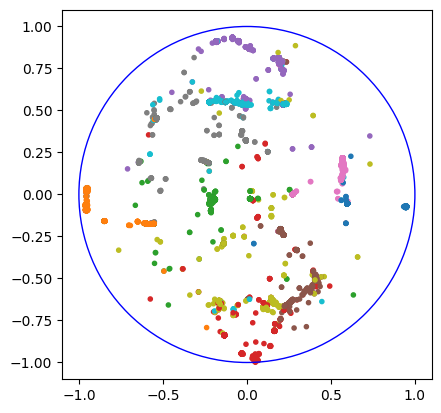

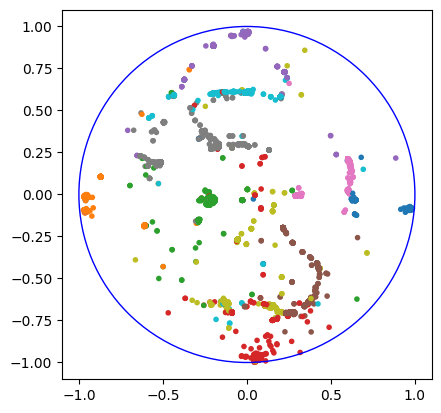

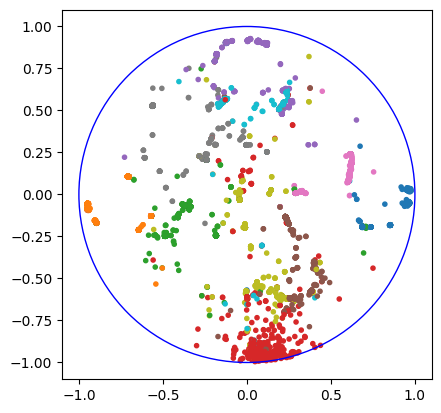

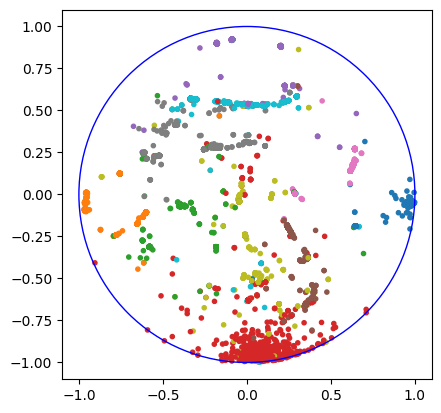

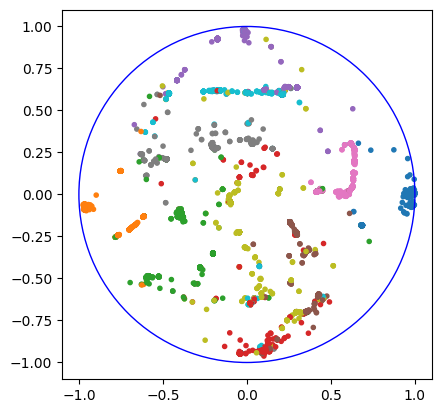

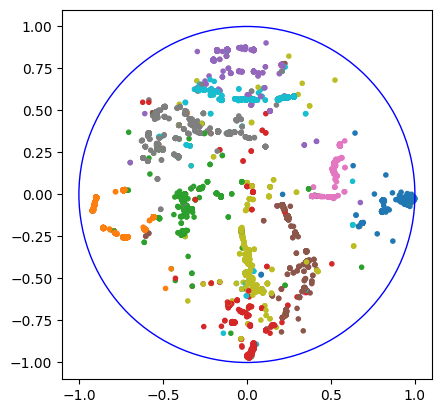

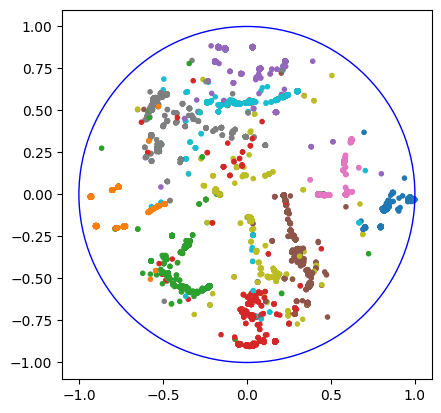

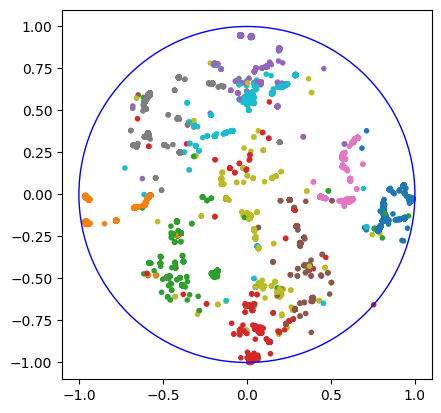

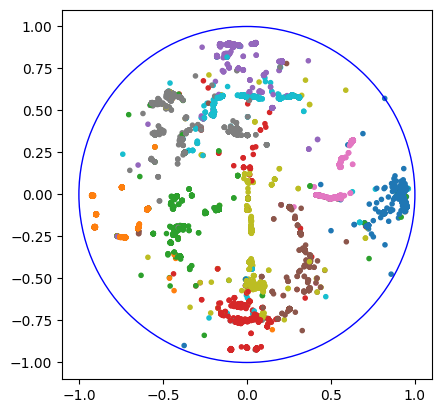

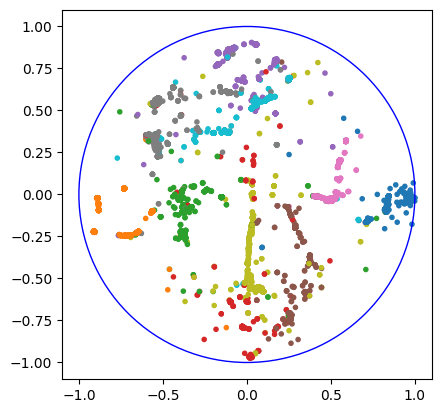

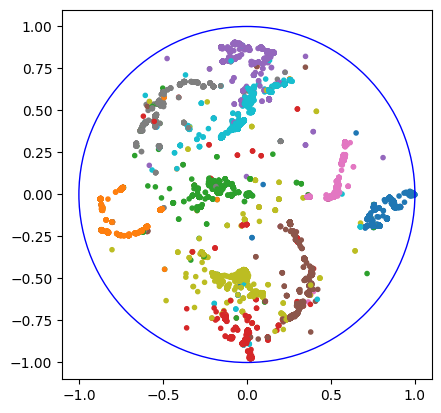

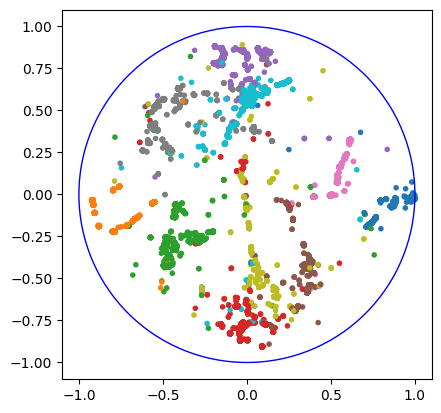

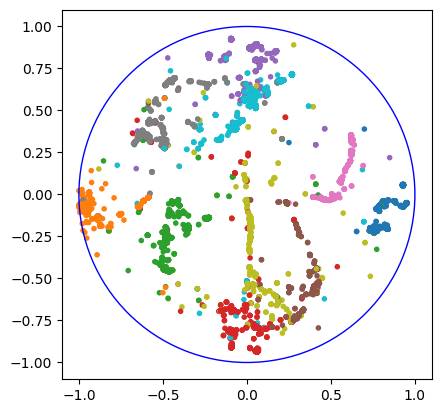

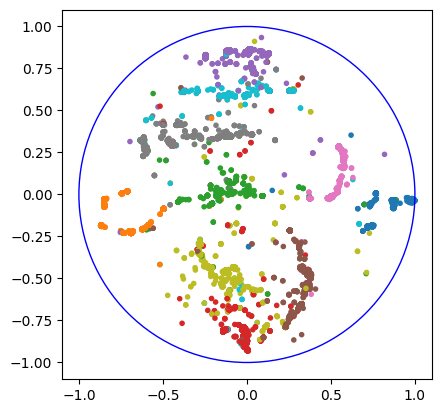

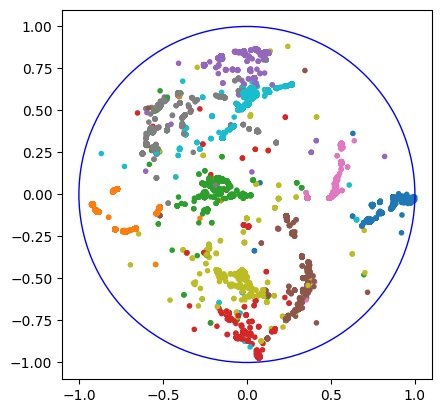

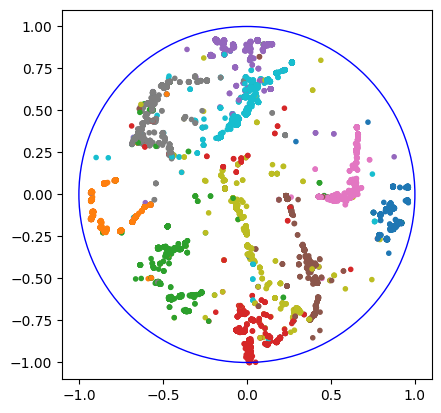

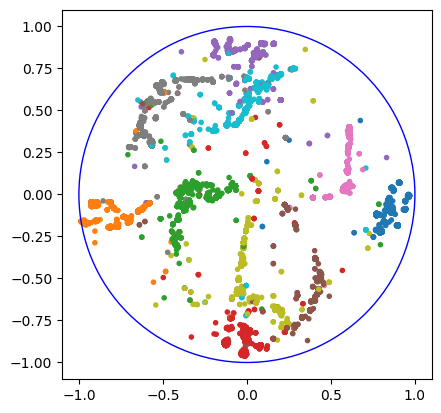

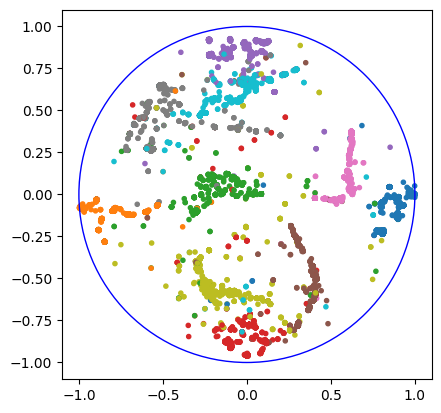

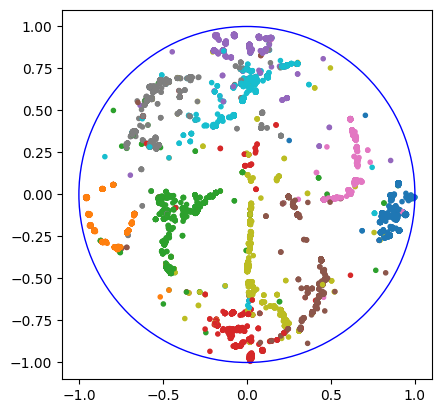

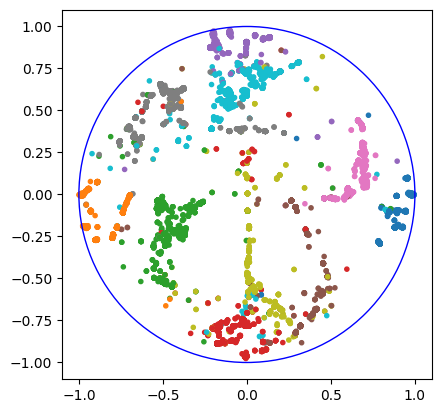

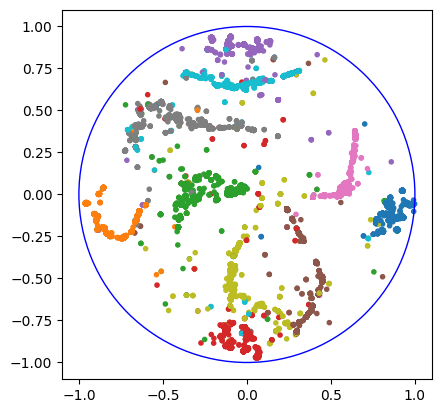

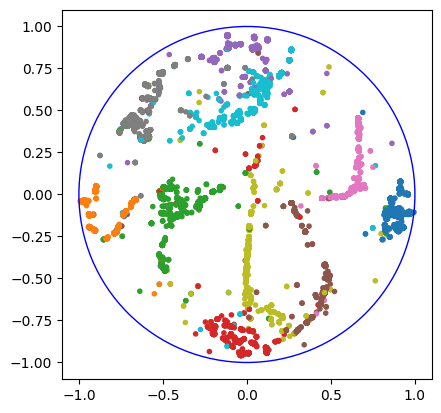

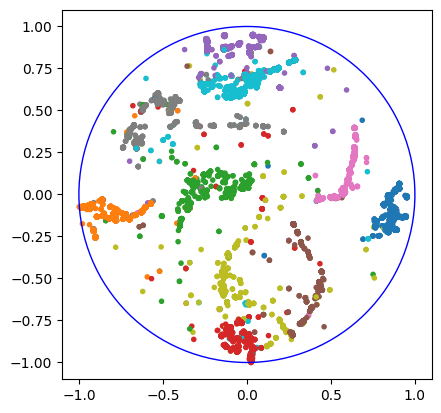

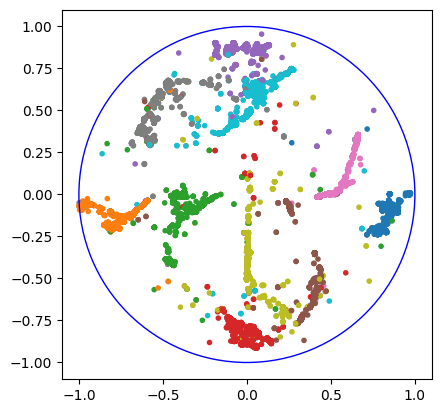

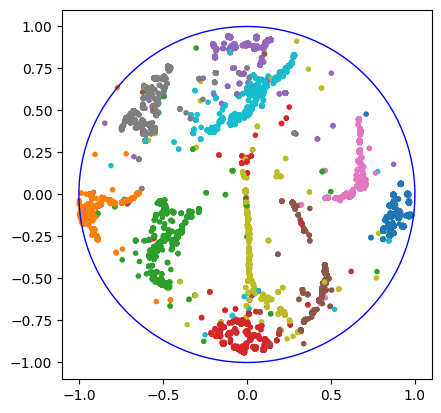

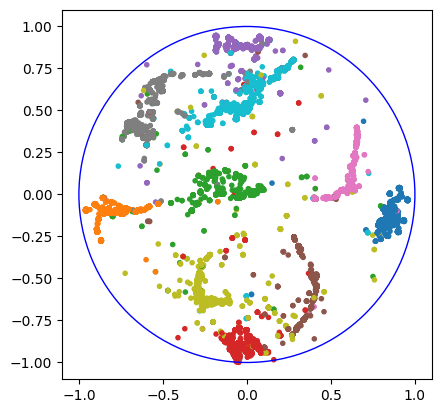

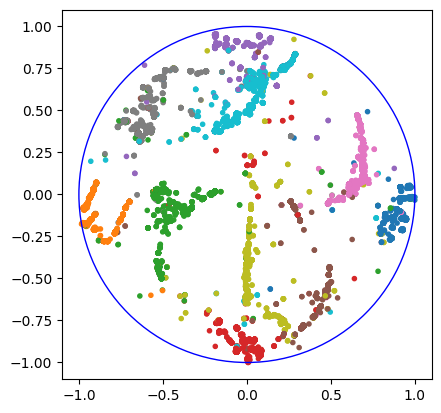

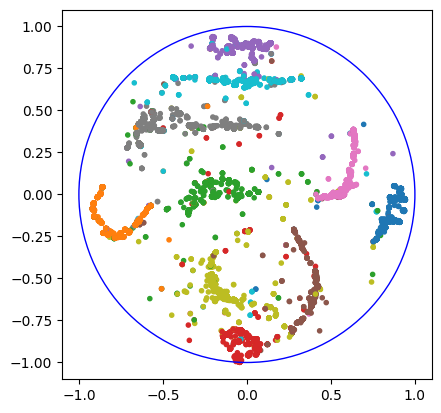

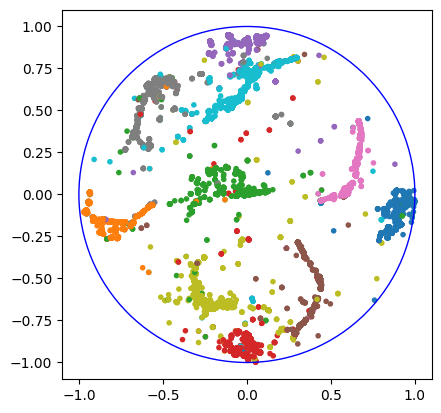

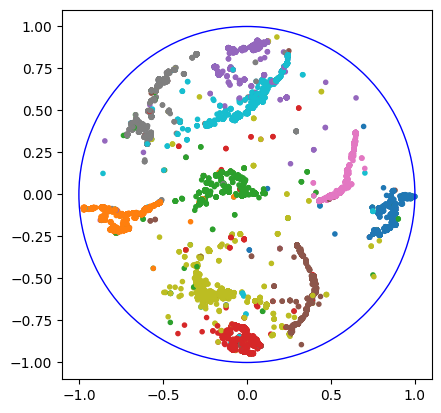

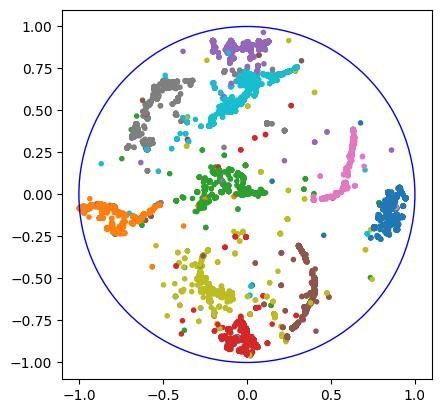

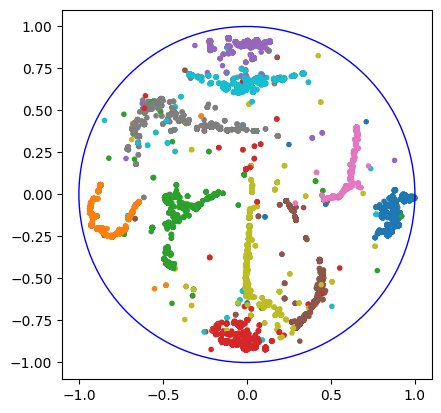

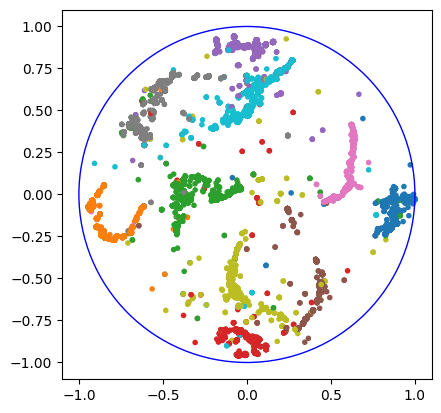

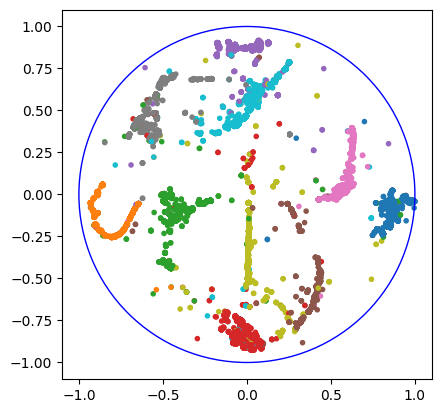

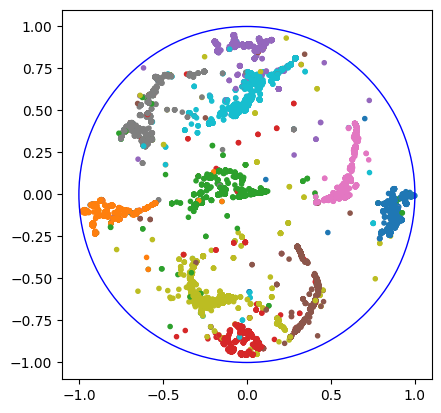

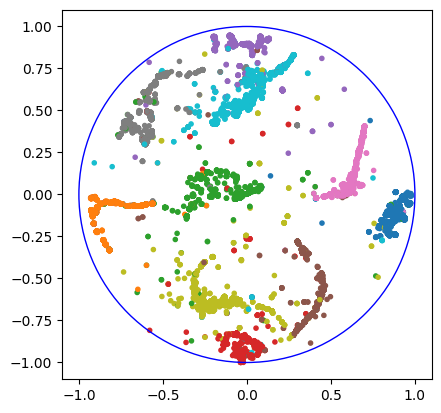

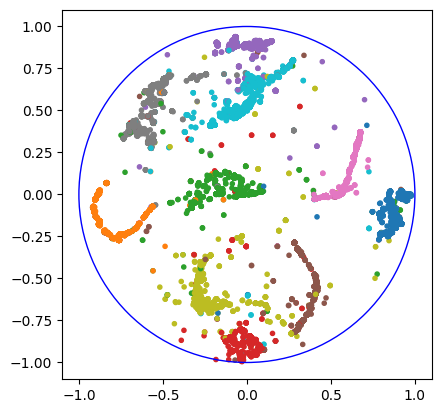

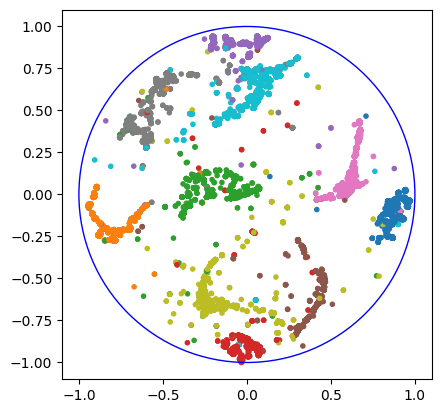

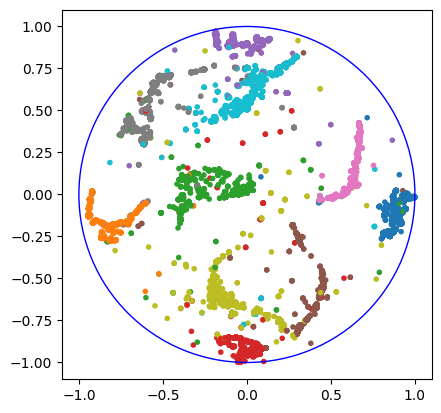

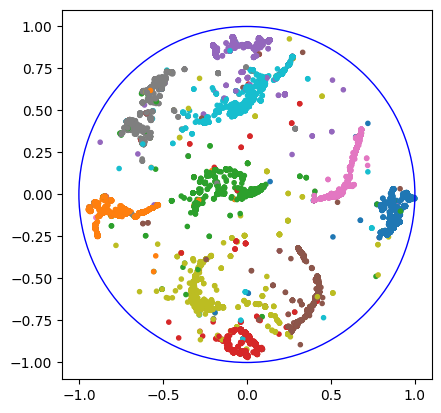

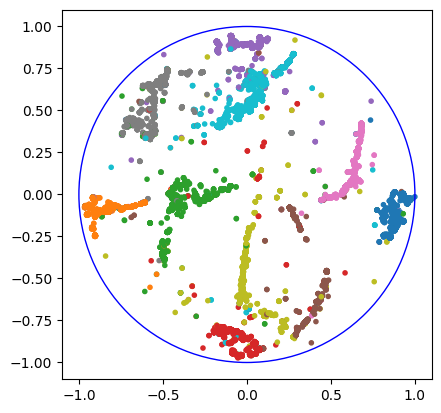

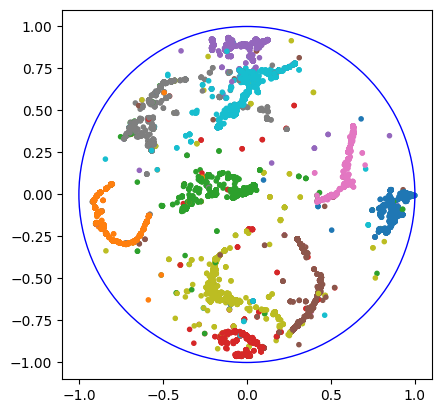

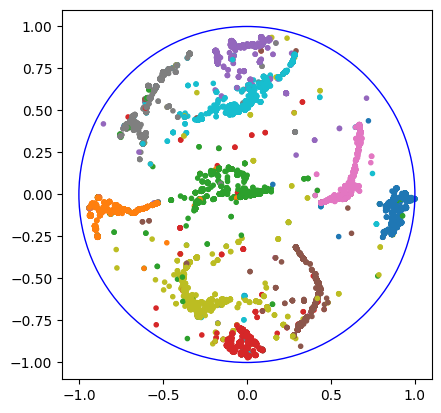

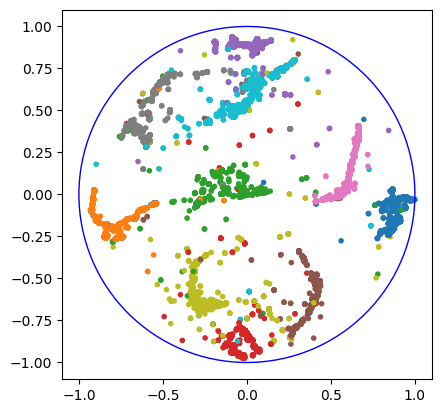

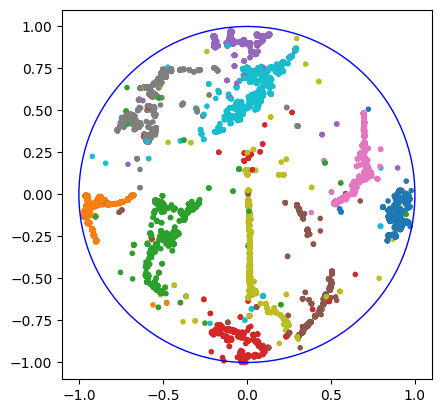

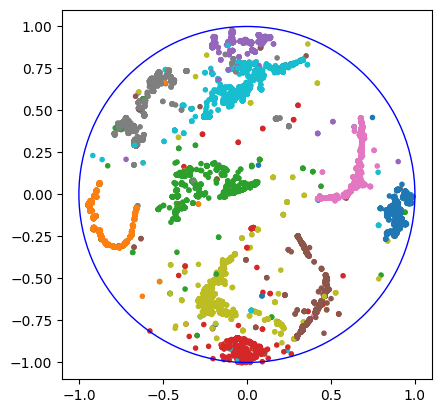

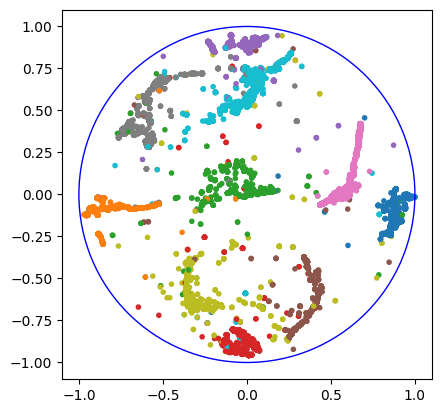

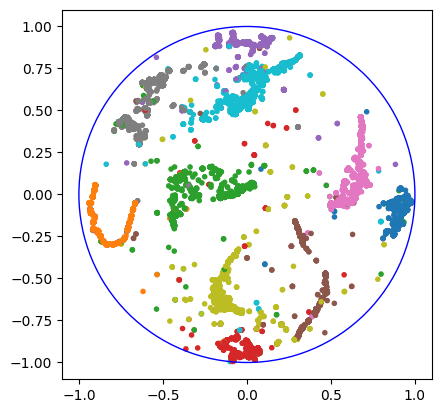

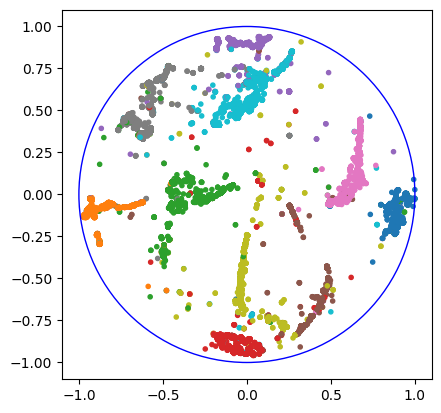

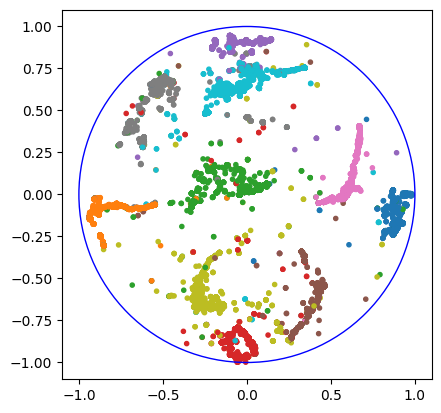

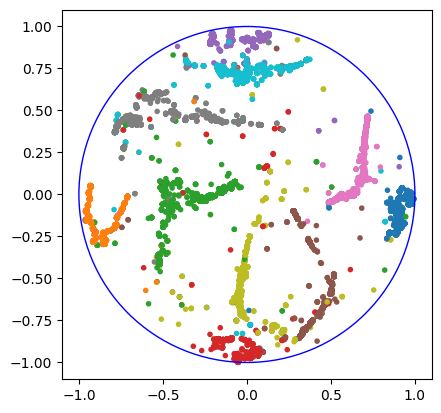

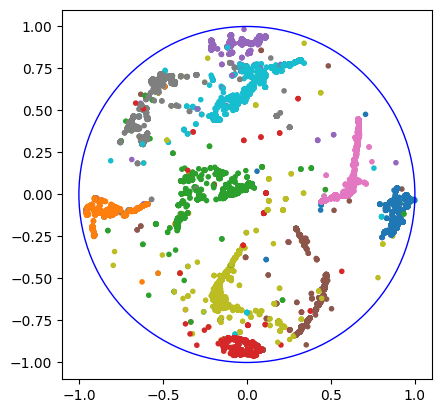

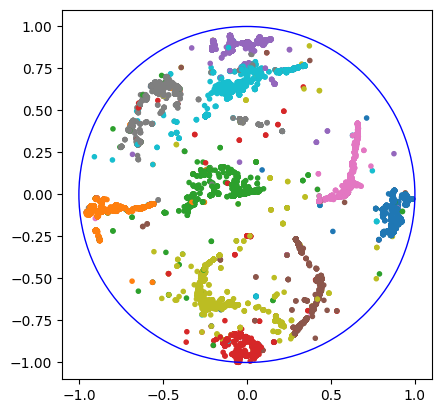

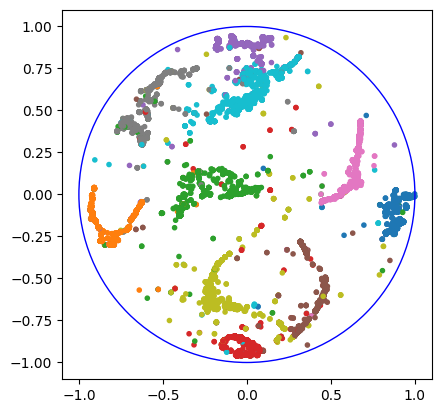

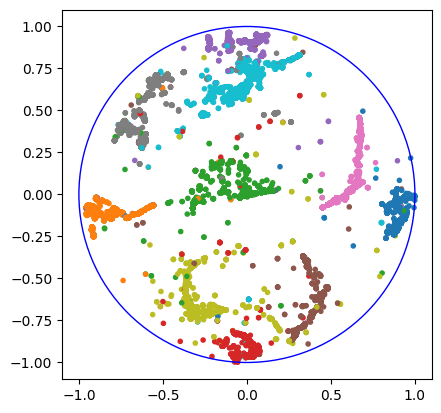

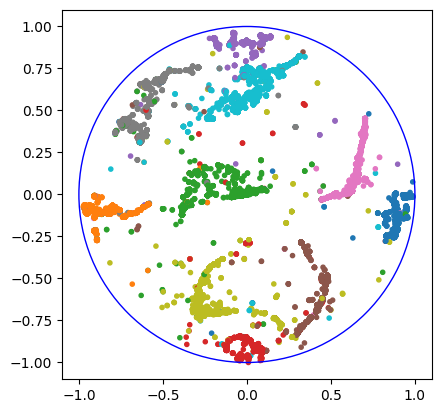

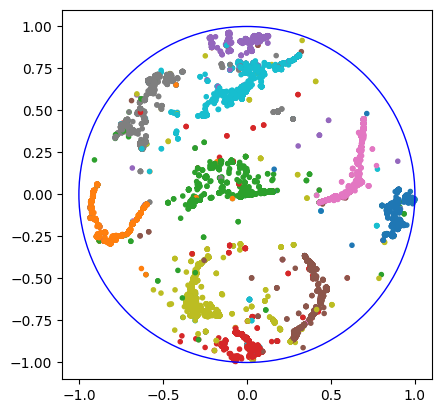

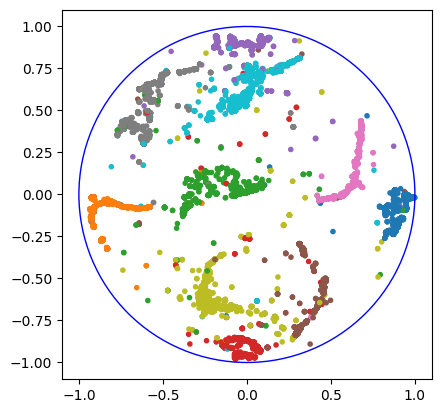

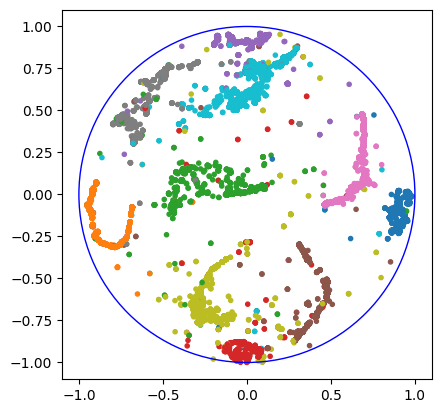

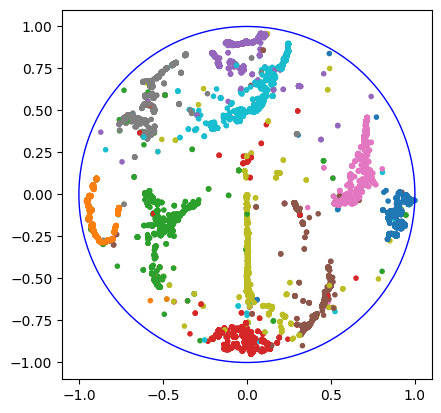

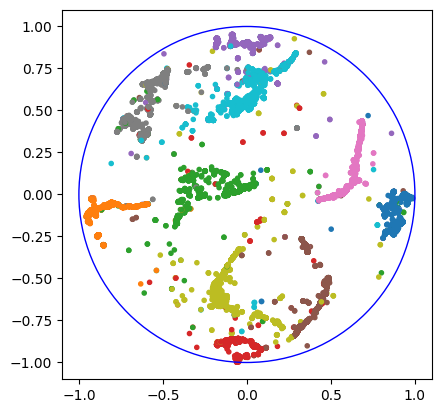

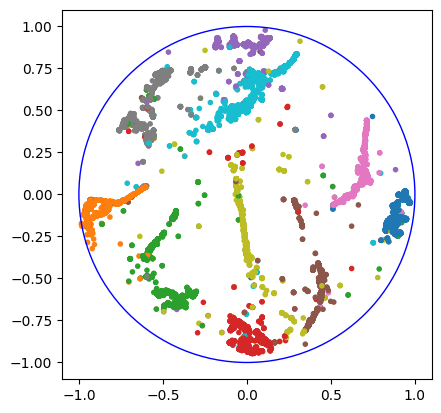

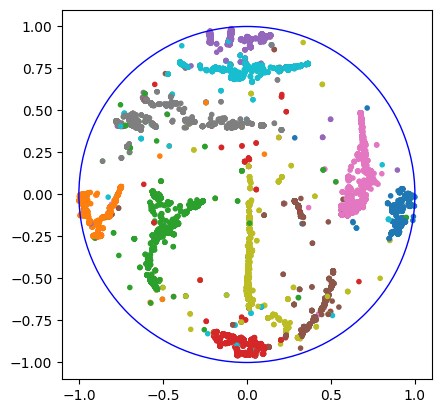

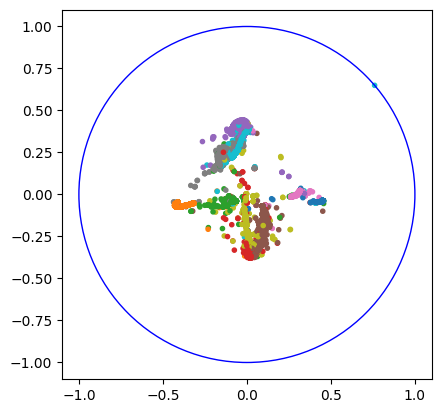

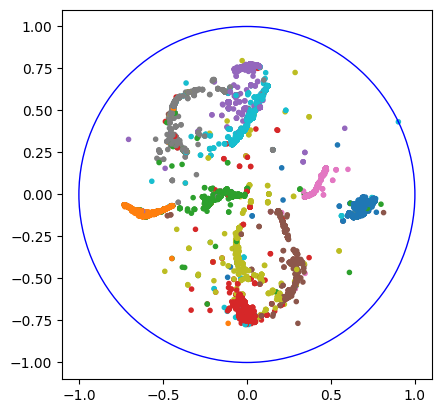

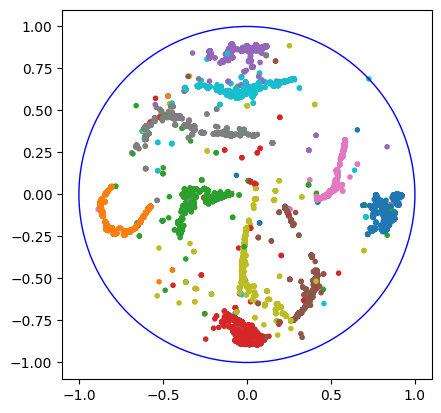

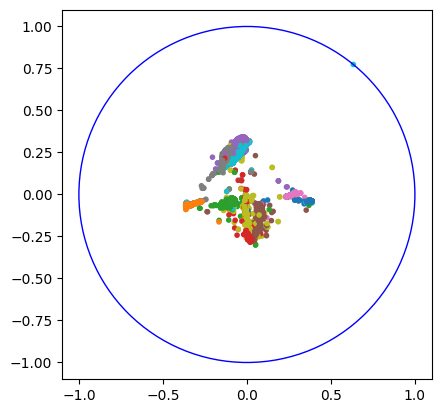

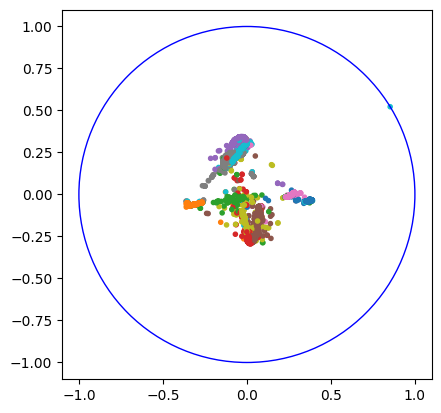

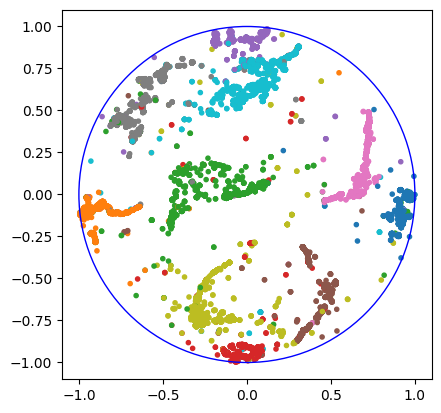

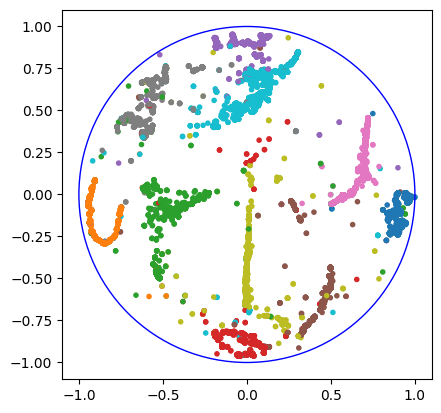

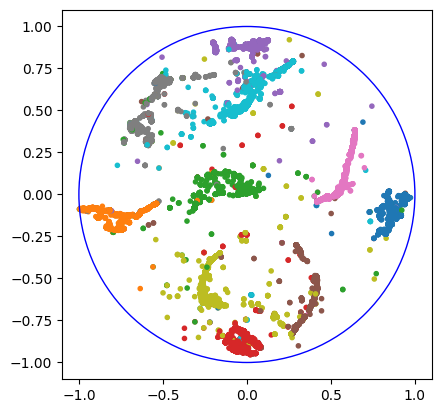

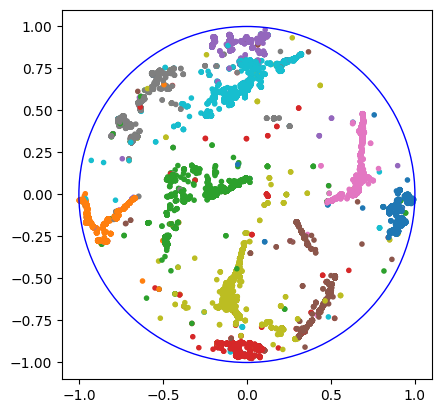

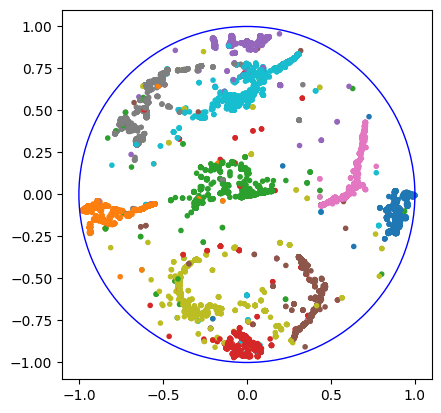

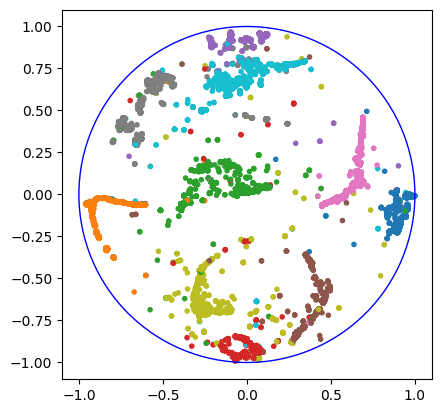

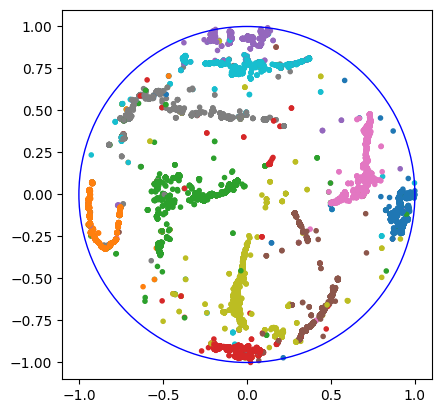

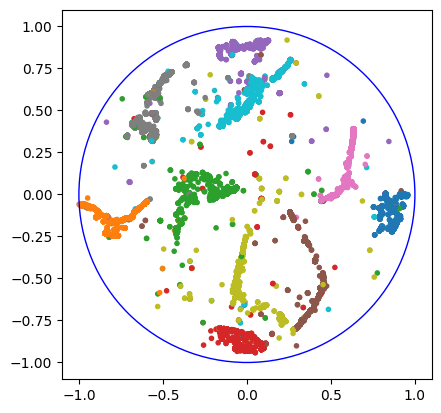

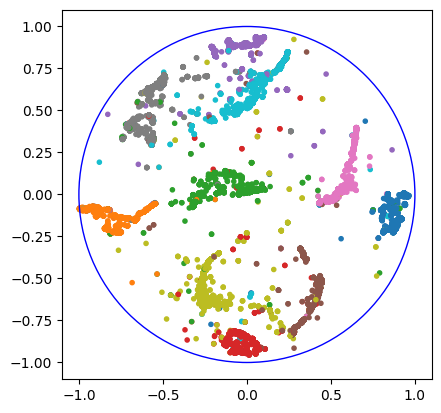

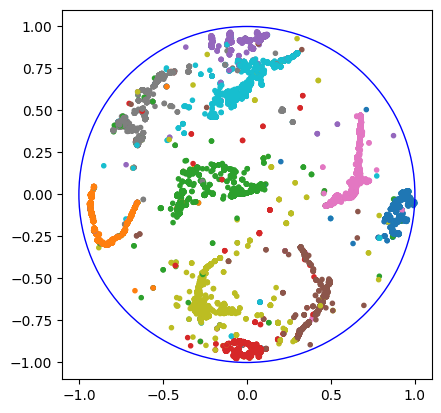

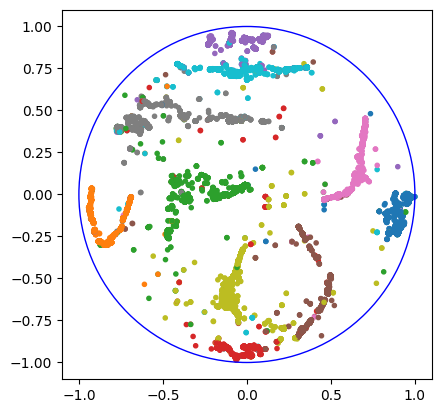

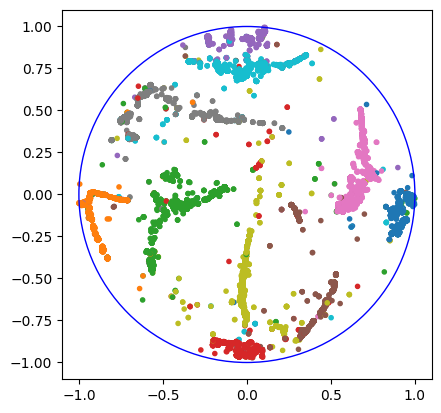

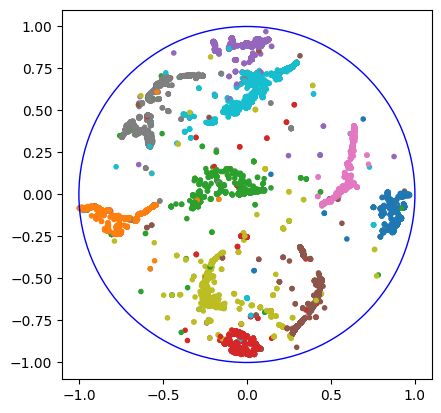

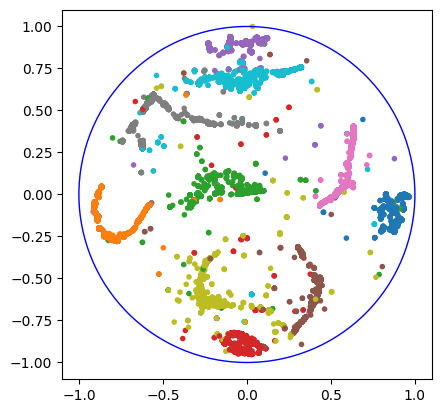

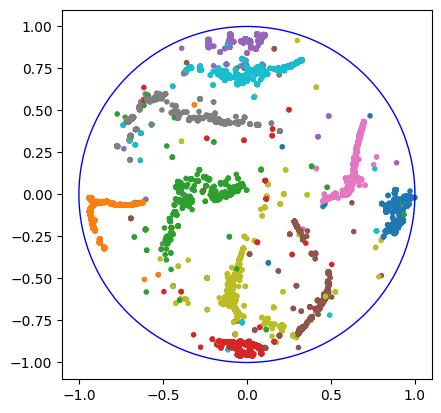

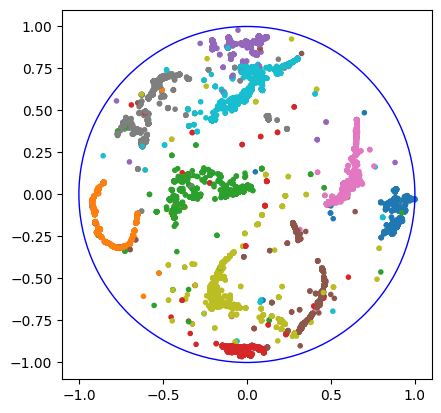

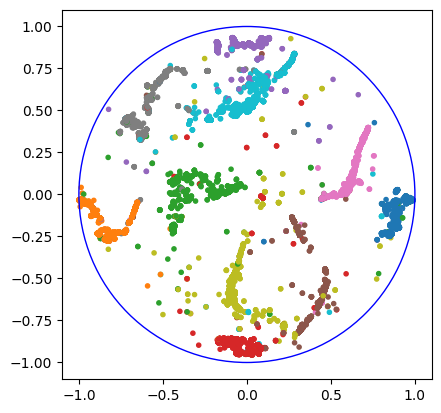

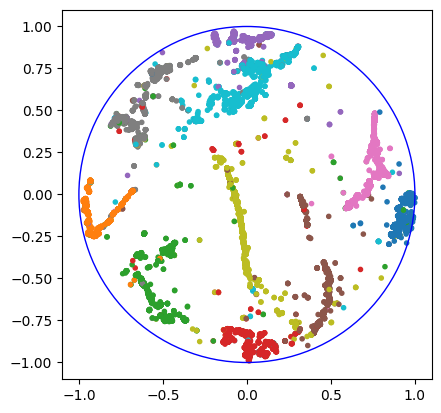

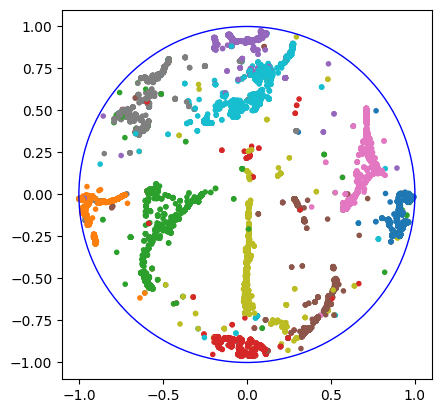

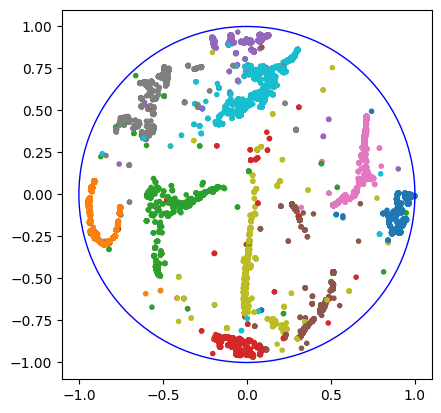

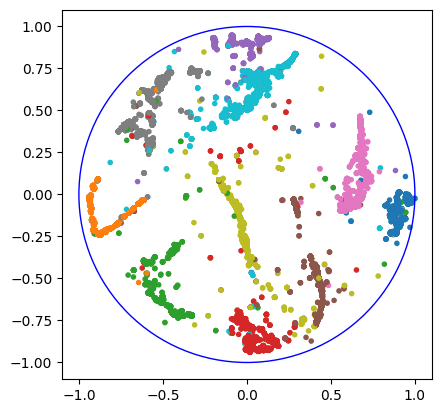

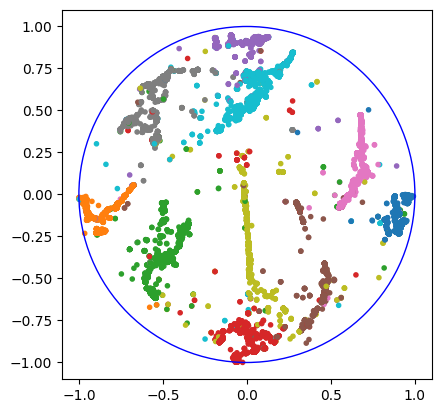

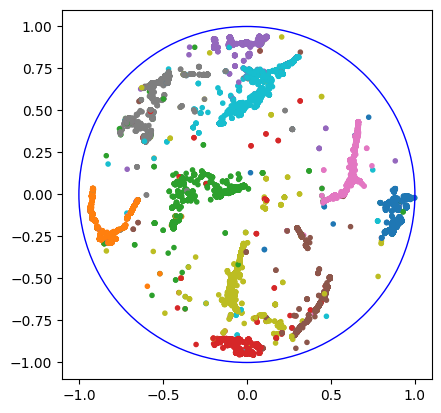

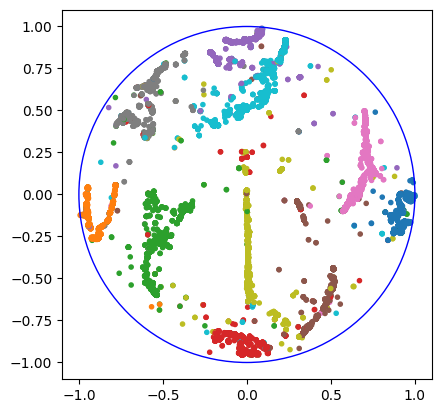

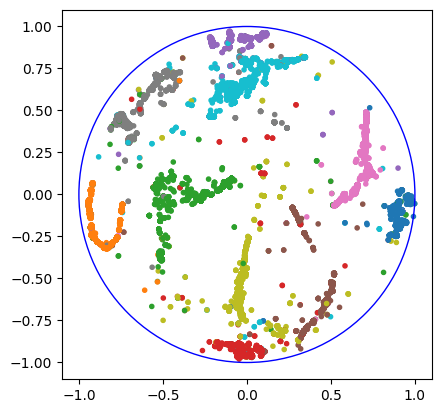

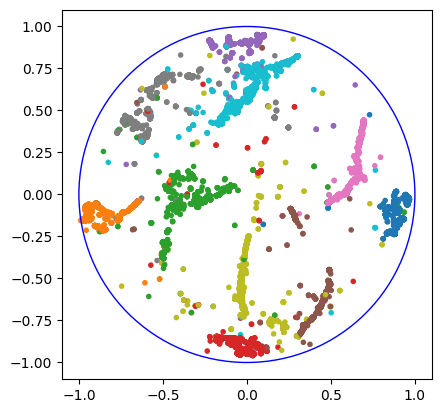

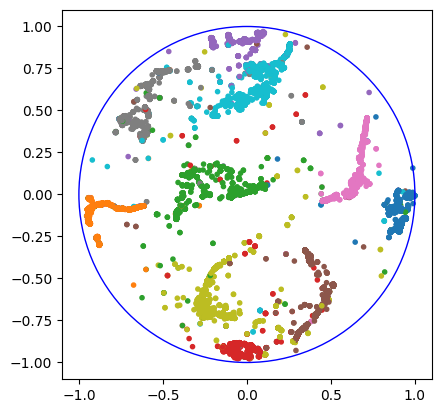

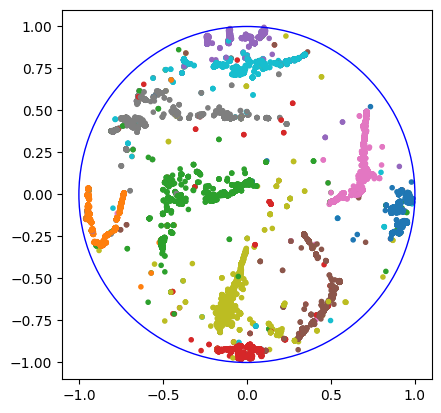

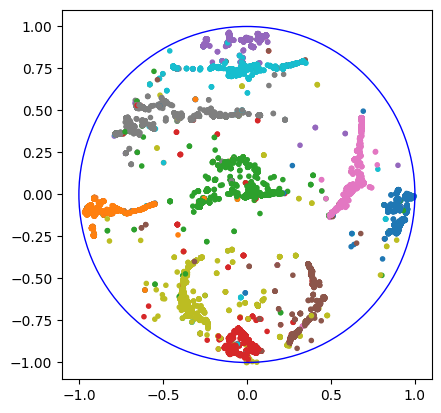

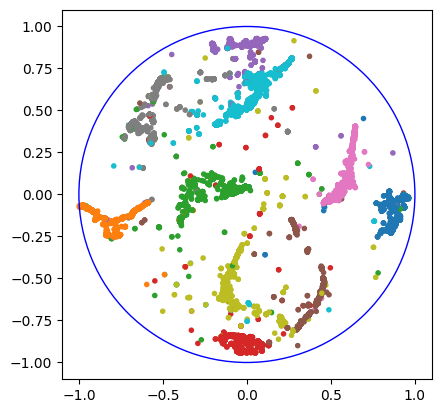

In [31]:
# TEST FOR DIFFERENT GRID_N VALUES
u_grid_ns = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
num_points = 20000

ugrid_gpu_precisions = []
ugrid_gpu_recalls = []
ugrid_gpu_runtimes = []

for u_grid_n in u_grid_ns:
    p, r, t = run_mult(5, num_points, False, True, u_grid_n) # Running approx. using uniform grid
    ugrid_gpu_precisions.append(p)
    ugrid_gpu_recalls.append(r)
    ugrid_gpu_runtimes.append(t)

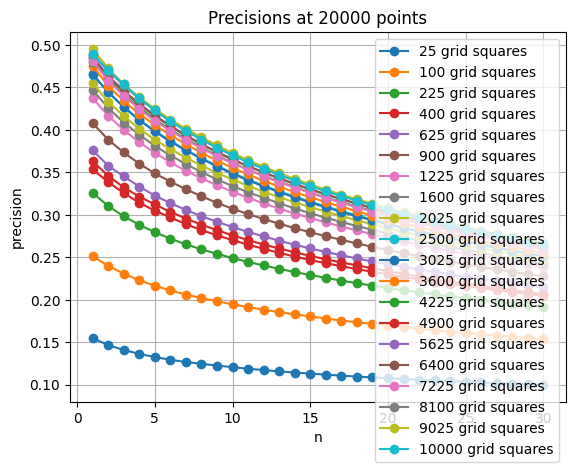

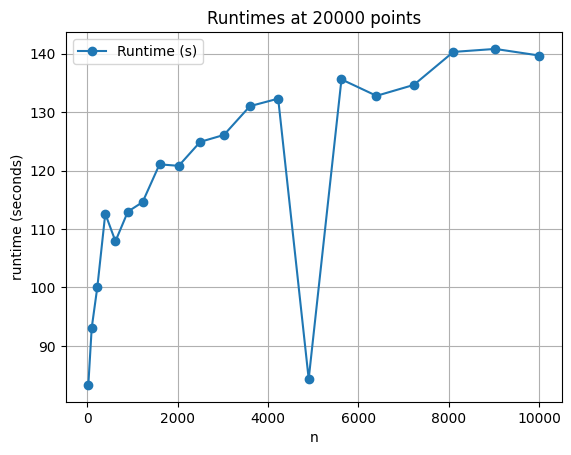

In [32]:
# RESULT DISPLAYING FOR DIFFERENT GRID_N_VALUES_TEST

data = ugrid_gpu_precisions
labels = [str(u_grid_n*u_grid_n) + " grid squares" for u_grid_n in u_grid_ns]
plot_points(data, labels, f"Precisions at {num_points} points", "n", "precision")

data = [ugrid_gpu_runtimes]
#labels = [str(u_grid_n*u_grid_n) + " grid squares" for u_grid_n in u_grid_ns]
plot_points(data, ["Runtime (s)"], f"Runtimes at {num_points} points", "n", "runtime (seconds)", [u_grid_n*u_grid_n for u_grid_n in u_grid_ns])